# Power plant optimization problem

# Requirements

In [50]:
import json
import gurobipy as gp
from gurobipy import GRB
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random

# First draft

## Data loading

In [51]:
random.seed(42)  # for reproducibility

# ---------------------------
# Basic structure
# ---------------------------
num_days = 7
TECHS = ["Oil", "Gas", "Coal"]
SUPPLIERS = {
    "Oil": ["Oil_Supplier_1", "Oil_Supplier_2", "Oil_Supplier_3"],
    "Gas": ["Gas_Supplier_1", "Gas_Supplier_2", "Gas_Supplier_3"],
    "Coal": ["Coal_Supplier_1", "Coal_Supplier_2", "Coal_Supplier_3"],
}

# Max generation & storage
max_gen = {"Oil": 50.0*24, "Gas": 40.0*24, "Coal": 30.0*24}
storage_cap = {"Oil": max_gen["Oil"]*3, "Gas": max_gen["Gas"]*3, "Coal": max_gen["Coal"]*3}
storage_rent = {"Oil": 1.5, "Gas": 1.0, "Coal": 0.8}
init_inventory = {"Oil": 0.0, "Gas": 0.0, "Coal": 0.0}

# Weekly demand (inelastic)
demand_total = 12612  # MWh, similar scale as before

# ---------------------------
# Volatile price generation
# ---------------------------

def generate_price_path(base, daily_vol, spike_prob, spike_size_low, spike_size_high, num_days):
    """
    Generate a price path with:
      - base: average level
      - daily_vol: normal noise (std dev)
      - spike_prob: probability of a spike each day
      - spike_size_low/high: range for spike magnitude (additive)
    """
    prices = []
    level = base
    for d in range(num_days):
        # normal daily noise
        shock = random.gauss(0, daily_vol)
        level += shock

        # occasional spike
        if random.random() < spike_prob:
            spike = random.uniform(spike_size_low, spike_size_high)
            level += spike

        # avoid negative prices
        level = max(5.0, level)

        prices.append(round(level, 1))
    return prices

fuel_bids = {}

# Rough typical cost levels (fuel + CO2 + VOM) in €/MWh:
# Coal cheaper, gas medium, oil most expensive.
tech_config = {
    "Coal": {
        "base_price": 65.0,
        "daily_vol": 3.0,
        "spike_prob": 0.15,
        "spike_size_low": 5.0,
        "spike_size_high": 20.0,
    },
    "Gas": {
        "base_price": 80.0,
        "daily_vol": 5.0,
        "spike_prob": 0.25,
        "spike_size_low": 10.0,
        "spike_size_high": 40.0,
    },
    "Oil": {
        "base_price": 100.0,
        "daily_vol": 4.0,
        "spike_prob": 0.20,
        "spike_size_low": 8.0,
        "spike_size_high": 30.0,
    },
}

fuel_bids = {}

for tech in TECHS:
    fuel_bids[tech] = {}
    cfg = tech_config[tech]

    # Supplier 1: cheapest but limited quantity
    # Supplier 2: mid-price, more volume
    # Supplier 3: most expensive, plenty of volume (emergency/risk supplier)
    for idx, supplier in enumerate(SUPPLIERS[tech], start=1):
        # Small price premium between suppliers (but still follow the same volatility pattern)
        premium = (idx - 1) * 3.0  # e.g. +0, +3, +6 €/MWh

        base = cfg["base_price"] + premium

        prices = generate_price_path(
            base=base,
            daily_vol=cfg["daily_vol"],
            spike_prob=cfg["spike_prob"],
            spike_size_low=cfg["spike_size_low"],
            spike_size_high=cfg["spike_size_high"],
            num_days=num_days
        )

        # Max quantity per day: increase with supplier index
        # (cheapest has less, most expensive has most)
        base_qty = (10.0 * idx/60)*0.8*sum(max_gen[i] for i in max_gen)*3
        max_qty = [base_qty for _ in range(num_days)]

        fuel_bids[tech][supplier] = {
            "price_EUR_per_MWh": prices,
            "max_MWh_per_day": max_qty
        }

# ---------------------------
# Demand bid (still inelastic)
# ---------------------------
demand_bid = {
    "type": "inelastic",
    "quantity_MWh": demand_total,
    "value_EUR_per_MWh": 1000.0
}

# ---------------------------
# Build full data structure
# ---------------------------
data = {
    "time": {
        "num_days": num_days
    },
    "demand": {
        "weekly_MWh": demand_total
    },
    "technologies": TECHS,
    "max_gen_MWh_per_day": max_gen,
    "storage_capacity_MWh": storage_cap,
    "storage_rent_EUR_per_MWh_per_day": storage_rent,
    "initial_inventory_MWh": init_inventory,
    "suppliers": SUPPLIERS,
    "fuel_bids": fuel_bids,
    "demand_bid": demand_bid
}

# ---------------------------
# Create data directory if it doesn't exist
data_folder = Path("data")
data_folder.mkdir(exist_ok=True)

# Write to data folder
with open(data_folder / "data_draft_1.json", "w") as f:
    json.dump(data, f, indent=2)

print("Volatile data/data_draft_1.json generated.")


Volatile data/data_draft_1.json generated.


In [52]:
# -------------------------------------------------------
# Load data from JSON file
# -------------------------------------------------------
data_folder = Path("data")
data_file_path = data_folder / "data_draft_1.json"
data_file_path = data_file_path.resolve()
with open(data_file_path, "r") as f:
    data = json.load(f)

# Basic sets
TECHS = data["technologies"]
num_days = data["time"]["num_days"]
DAYS = range(num_days)

# Suppliers per technology
SUPPLIERS = {tech: data["suppliers"][tech] for tech in TECHS}

# Parameters
demand_total = data["demand"]["weekly_MWh"]

max_gen = data["max_gen_MWh_per_day"]  # dict tech -> float
storage_cap = data["storage_capacity_MWh"]
storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
init_inventory = data["initial_inventory_MWh"]

fuel_bids = data["fuel_bids"]  # nested dict: tech -> supplier -> {price[], max[]}
display(fuel_bids)

{'Oil': {'Oil_Supplier_1': {'price_EUR_per_MWh': [99.4,
    98.7,
    98.2,
    109.5,
    112.3,
    125.2,
    122.2],
   'max_MWh_per_day': [1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0]},
  'Oil_Supplier_2': {'price_EUR_per_MWh': [98.9,
    99.1,
    98.7,
    97.4,
    99.4,
    100.9,
    101.9],
   'max_MWh_per_day': [2304.0,
    2304.0,
    2304.0,
    2304.0,
    2304.0,
    2304.0,
    2304.0]},
  'Oil_Supplier_3': {'price_EUR_per_MWh': [108.3,
    102.2,
    98.6,
    102.1,
    105.4,
    114.5,
    114.1],
   'max_MWh_per_day': [3456.0,
    3456.0,
    3456.0,
    3456.0,
    3456.0,
    3456.0,
    3456.0]}},
 'Gas': {'Gas_Supplier_1': {'price_EUR_per_MWh': [100.3,
    97.2,
    111.6,
    118.3,
    147.3,
    149.9,
    154.0],
   'max_MWh_per_day': [1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0,
    1152.0]},
  'Gas_Supplier_2': {'price_EUR_per_MWh': [75.9,
    73.2,
    73.4,
    74.7,
    77.6,
    89.2,
    86.4

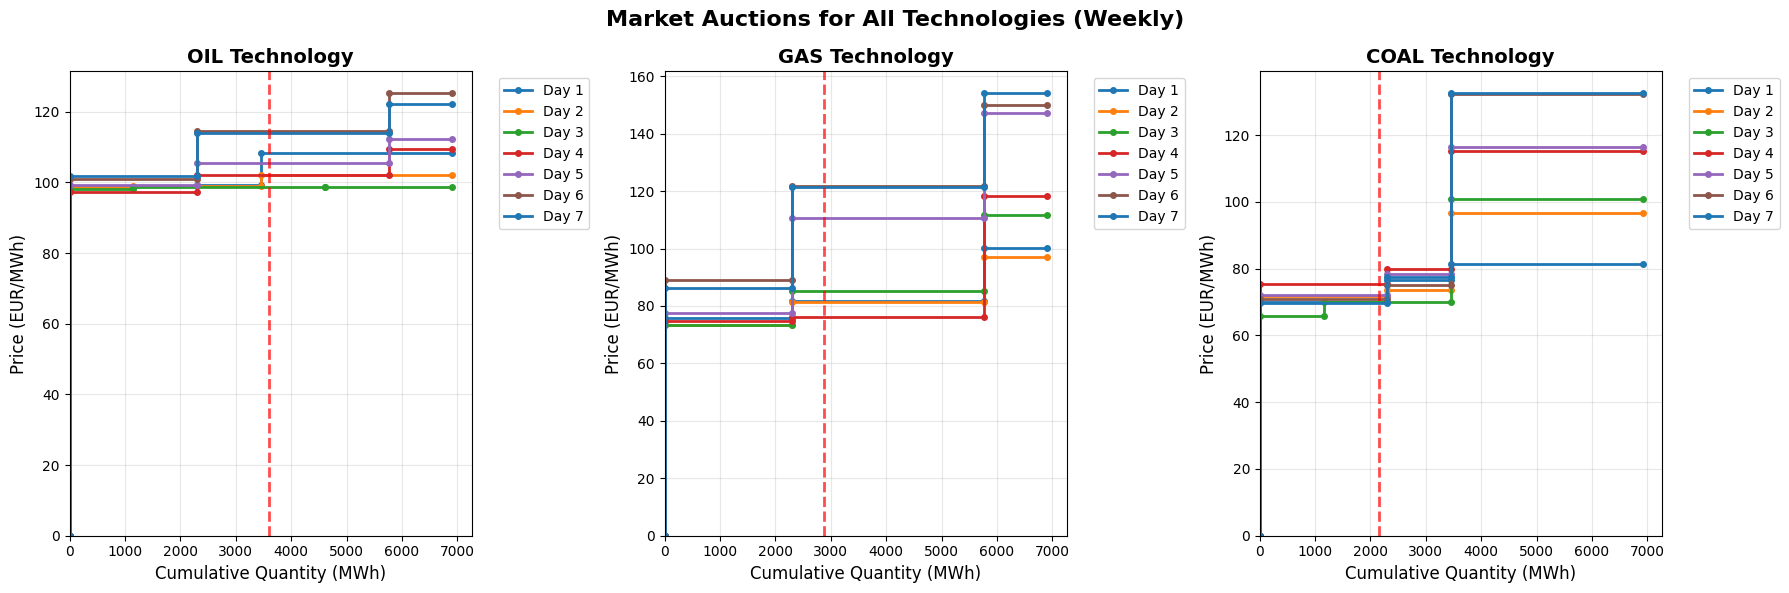


MARKET AUCTION SUMMARY

OIL Technology:
  Max Generation Capacity: 1200.0 MWh/day
  Number of Suppliers: 3
  Price Range: 97.40 - 125.20 EUR/MWh
  Average Price: 105.10 EUR/MWh
  Total Available Capacity: 6912.00 MWh/day

GAS Technology:
  Max Generation Capacity: 960.0 MWh/day
  Number of Suppliers: 3
  Price Range: 73.20 - 154.00 EUR/MWh
  Average Price: 100.34 EUR/MWh
  Total Available Capacity: 6912.00 MWh/day

COAL Technology:
  Max Generation Capacity: 720.0 MWh/day
  Number of Suppliers: 3
  Price Range: 65.70 - 132.50 EUR/MWh
  Average Price: 85.82 EUR/MWh
  Total Available Capacity: 6912.00 MWh/day


In [53]:
# Create market auction plots for each technology
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Market Auctions for All Technologies (Weekly)', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for tech_idx, tech in enumerate(TECHS):
    ax = axes[tech_idx]
    
    # Plot supply curves for each day
    for day in DAYS:
        # Get all suppliers for this technology
        suppliers = SUPPLIERS[tech]
        
        # Collect price and quantity data for this day
        prices = []
        cumulative_quantities = []
        current_quantity = 0
        
        # Sort suppliers by price for proper merit order
        supplier_data = []
        for supplier in suppliers:
            price = fuel_bids[tech][supplier]["price_EUR_per_MWh"][day]
            max_quantity = fuel_bids[tech][supplier]["max_MWh_per_day"][day]
            supplier_data.append((price, max_quantity, supplier))
        
        # Sort by price (merit order)
        supplier_data.sort(key=lambda x: x[0])
        
        # Build supply curve
        prices.append(0)  # Start from 0
        cumulative_quantities.append(current_quantity)
        
        for price, max_quantity, supplier in supplier_data:
            # Add horizontal line at current quantity
            prices.append(price)
            cumulative_quantities.append(current_quantity)
            
            # Add vertical line to next quantity level
            current_quantity += max_quantity
            prices.append(price)
            cumulative_quantities.append(current_quantity)
        
        # Plot the supply curve for this day
        color = colors[day % len(colors)]
        ax.plot(cumulative_quantities, prices, 
               label=f'Day {day + 1}', 
               color=color, 
               linewidth=2,
               marker='o',
               markersize=4)
    
    # Formatting
    ax.set_title(f'{tech.upper()} Technology', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cumulative Quantity (MWh)', fontsize=12)
    ax.set_ylabel('Price (EUR/MWh)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add maximum generation limit line
    if tech in storage_cap:
        ax.axvline(x=storage_cap[tech], color='red', linestyle='--', 
                  linewidth=2, alpha=0.7, label=f'Max Gen: {max_gen[tech]} MWh')
    
    # Set reasonable axis limits
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print summary information
print("\n" + "="*80)
print("MARKET AUCTION SUMMARY")
print("="*80)

for tech in TECHS:
    print(f"\n{tech.upper()} Technology:")
    print(f"  Max Generation Capacity: {max_gen.get(tech, 'N/A')} MWh/day")
    print(f"  Number of Suppliers: {len(SUPPLIERS[tech])}")
    
    # Calculate average prices across all days and suppliers
    all_prices = []
    total_capacity = 0
    
    for day in DAYS:
        day_capacity = 0
        for supplier in SUPPLIERS[tech]:
            price = fuel_bids[tech][supplier]["price_EUR_per_MWh"][day]
            quantity = fuel_bids[tech][supplier]["max_MWh_per_day"][day]
            all_prices.append(price)
            day_capacity += quantity
        total_capacity = max(total_capacity, day_capacity)
    
    print(f"  Price Range: {min(all_prices):.2f} - {max(all_prices):.2f} EUR/MWh")
    print(f"  Average Price: {np.mean(all_prices):.2f} EUR/MWh")
    print(f"  Total Available Capacity: {total_capacity:.2f} MWh/day")

## Optimization program

In [54]:
# -------------------------------------------------------
# Model
# -------------------------------------------------------
m = gp.Model("Weekly_Fuel_Procurement_and_Storage_MultiSupplier")

# -------------------------------------------------------
# Decision variables
# -------------------------------------------------------

# purchase[tech, supplier, day]: energy purchased from supplier s for tech t on day d (MWh)
purchase = m.addVars(
    ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
    name="purchase",
    lb=0.0
)

# generate[tech, day]: energy generated by tech t on day d (MWh)
generate = m.addVars(
    ((t, d) for t in TECHS for d in DAYS),
    name="generate",
    lb=0.0
)

# inventory[tech, day]: inventory of fuel for tech t at end of day d (MWh)
inventory = m.addVars(
    ((t, d) for t in TECHS for d in DAYS),
    name="inventory",
    lb=0.0
)

# -------------------------------------------------------
# Objective: Minimize fuel purchase cost + storage cost
# -------------------------------------------------------

# Fuel purchase cost
purchase_cost = gp.quicksum(
    fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d]
    for t in TECHS
    for s in SUPPLIERS[t]
    for d in DAYS
)

# Storage cost (rent per MWh stored per day)
storage_cost = gp.quicksum(
    storage_rent[t] * inventory[t, d]
    for t in TECHS
    for d in DAYS
)

m.setObjective(purchase_cost + storage_cost, GRB.MINIMIZE)

# -------------------------------------------------------
# Constraints
# -------------------------------------------------------

# 1) Inventory balance:
#    inventory[t,d] = inventory[t,d-1] + sum_s purchase[t,s,d] - generate[t,d]
#    -> ensures conservation of energy per technology over time
for t in TECHS:
    for d in DAYS:
        if d == 0:
            prev_inventory = init_inventory[t]
        else:
            prev_inventory = inventory[t, d - 1]

        m.addConstr(
            inventory[t, d] ==
            prev_inventory
            + gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t])
            - generate[t, d],
            name=f"inv_balance_{t}_day{d}"
        )

# 2) Generation capacity:
#    generate[t,d] <= max_gen[t]
#    -> respects physical max daily generation per technology
for t in TECHS:
    for d in DAYS:
        m.addConstr(
            generate[t, d] <= max_gen[t],
            name=f"gen_cap_{t}_day{d}"
        )

# 3) Storage capacity:
#    inventory[t,d] <= storage_cap[t]
#    -> cannot store more fuel than the storage capacity
for t in TECHS:
    for d in DAYS:
        m.addConstr(
            inventory[t, d] <= storage_cap[t],
            name=f"storage_cap_{t}_day{d}"
        )

# 4) Supplier offer limits:
#    purchase[t,s,d] <= max_offer[t,s,d]
#    -> you cannot buy more from a supplier than their auction offer
for t in TECHS:
    for s in SUPPLIERS[t]:
        for d in DAYS:
            max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
            m.addConstr(
                purchase[t, s, d] <= max_offer,
                name=f"supplier_cap_{t}_{s}_day{d}"
            )

# 5) Weekly demand satisfaction:
#    sum_t sum_d generate[t,d] = demand_total
#    -> inelastic demand: must be fully met over the week
m.addConstr(
    gp.quicksum(generate[t, d] for t in TECHS for d in DAYS) == demand_total,
    name="weekly_demand"
)

# 6) End-of-week inventory = 0:
#    inventory[t, last_day] = 0
#    -> avoids leaving unused fuel at the end (no terminal value assumed)
last_day = num_days - 1
for t in TECHS:
    m.addConstr(
        inventory[t, last_day] == 0.0,
        name=f"end_inventory_zero_{t}"
    )

# (Non-negativity is already enforced via lb=0.0 on variables)


# -------------------------------------------------------
# Solve
# -------------------------------------------------------
m.optimize()

# -------------------------------------------------------
# Print solution
# -------------------------------------------------------
if m.status == GRB.OPTIMAL:
    print(f"Optimal objective value (total cost): {m.objVal:.2f} EUR")

    print("\n=== Purchases (MWh) by tech / supplier / day ===")
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                val = purchase[t, s, d].X
                if val > 1e-6:
                    print(f"Purchase[{t}, {s}, day {d}] = {val:.2f} MWh")

    print("\n=== Generation (MWh) by tech / day ===")
    for t in TECHS:
        for d in DAYS:
            val = generate[t, d].X
            if val > 1e-6:
                print(f"Generate[{t}, day {d}] = {val:.2f} MWh")

    print("\n=== Inventory (MWh) by tech / day ===")
    for t in TECHS:
        for d in DAYS:
            val = inventory[t, d].X
            if val > 1e-6:
                print(f"Inventory[{t}, day {d}] = {val:.2f} MWh")
else:
    print(f"Model ended with status {m.status}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 130 rows, 105 columns and 252 nonzeros
Model fingerprint: 0xab6f092d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 1e+04]
Presolve removed 108 rows and 24 columns
Presolve time: 0.01s
Presolved: 22 rows, 81 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.003000e+03   0.000000e+00      0s
      18    9.3964080e+05   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.396408000e+05
Optimal objective value (total cost): 939640.80 EUR

=== Purchases (MWh) by tech / supplier / day ===

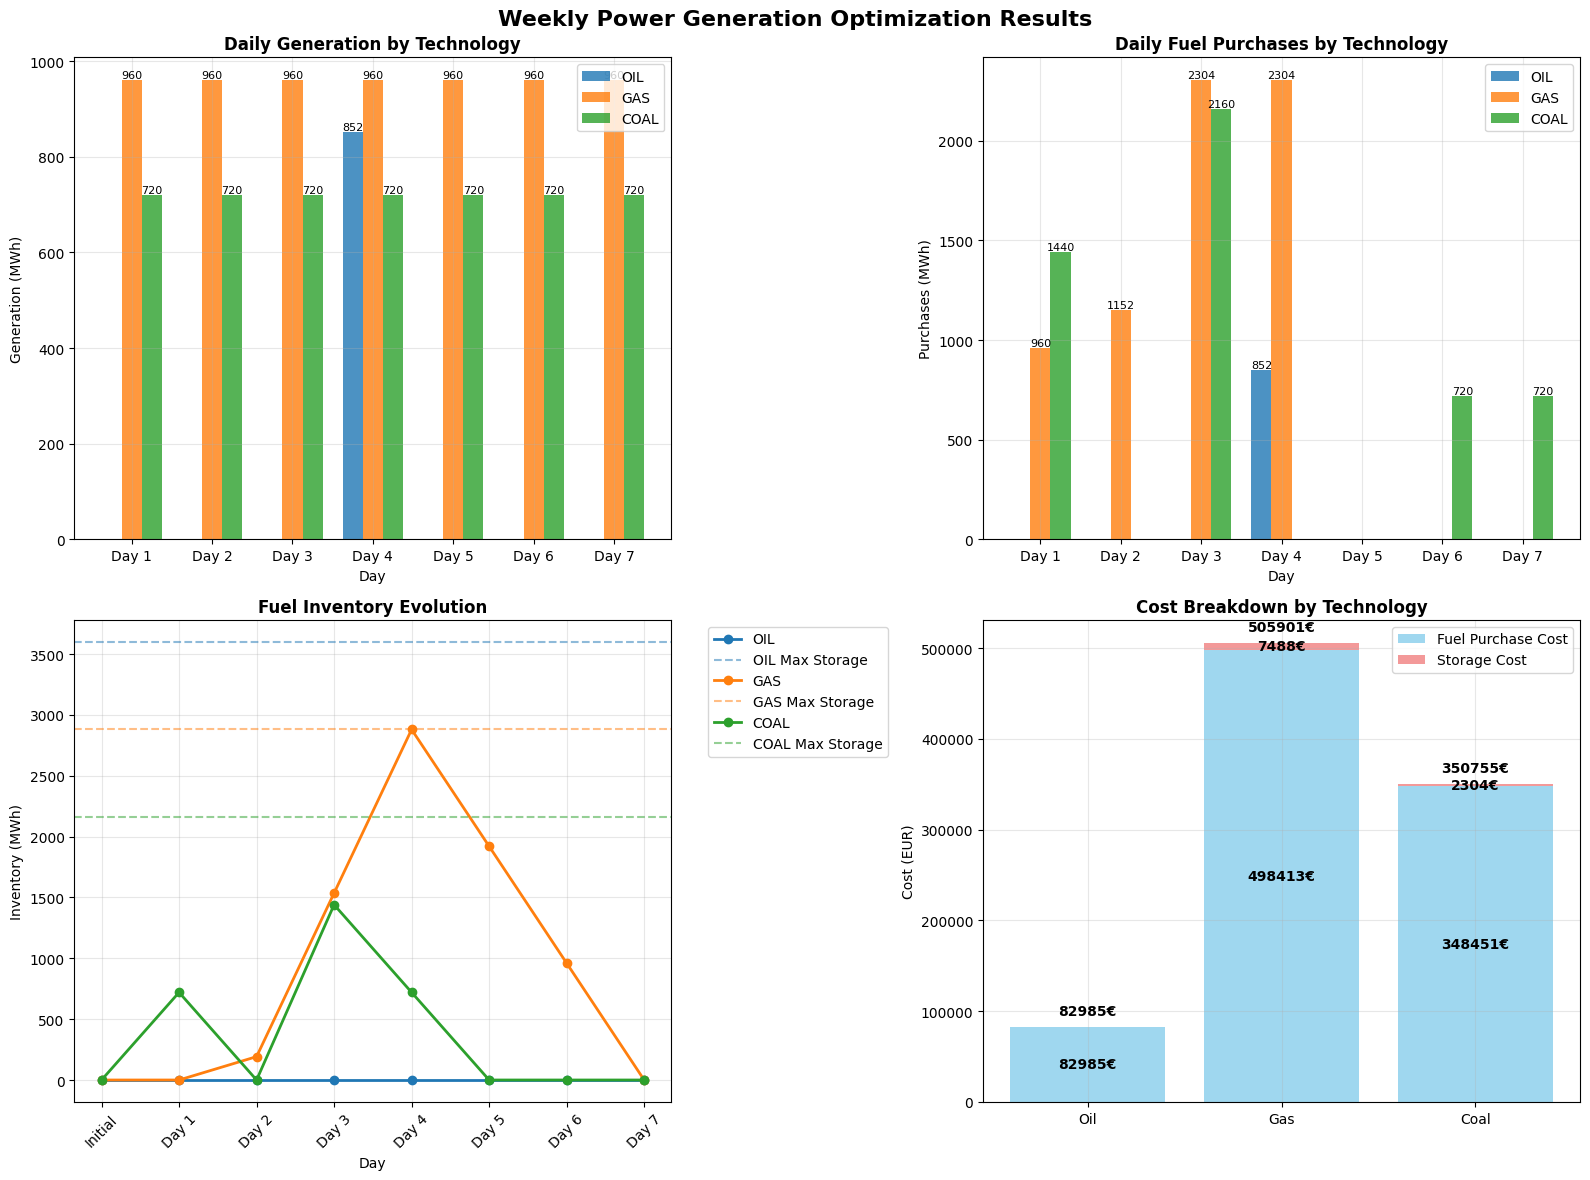


OPTIMIZATION RESULTS SUMMARY

Total Weekly Generation: 12612.00 MWh
Total Weekly Demand: 12612.00 MWh
Total Weekly Purchases: 12612.00 MWh
Total Cost: 939640.80 EUR

Cost Breakdown:
  Fuel Purchase Cost: 929848.80 EUR (99.0%)
  Storage Cost: 9792.00 EUR (1.0%)

Generation by Technology:
  OIL: 852.00 MWh (6.8% of total, 10.1% capacity utilization)
  GAS: 6720.00 MWh (53.3% of total, 100.0% capacity utilization)
  COAL: 5040.00 MWh (40.0% of total, 100.0% capacity utilization)

Storage Utilization:
  OIL: Max 0.00 MWh (0.0% of capacity), Avg 0.00 MWh
  GAS: Max 2880.00 MWh (100.0% of capacity), Avg 1069.71 MWh
  COAL: Max 1440.00 MWh (66.7% of capacity), Avg 411.43 MWh


In [55]:
# -------------------------------------------------------
# Visualization of optimization results
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    # Extract solution data
    purchase_data = {}
    generate_data = {}
    inventory_data = {}
    
    for t in TECHS:
        purchase_data[t] = []
        generate_data[t] = []
        inventory_data[t] = []
        
        for d in DAYS:
            # Sum purchases across all suppliers for each tech/day
            total_purchase = sum(purchase[t, s, d].X for s in SUPPLIERS[t])
            purchase_data[t].append(total_purchase)
            generate_data[t].append(generate[t, d].X)
            inventory_data[t].append(inventory[t, d].X)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Weekly Power Generation Optimization Results', fontsize=16, fontweight='bold')
    
    days_labels = [f'Day {d+1}' for d in DAYS]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # 1. Daily Generation by Technology
    ax1 = axes[0, 0]
    width = 0.25
    x = np.arange(len(DAYS))
    
    for i, tech in enumerate(TECHS):
        bars = ax1.bar(x + i*width, generate_data[tech], width, 
                      label=tech.upper(), color=colors[i], alpha=0.8)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.1:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    ax1.set_title('Daily Generation by Technology', fontweight='bold')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Generation (MWh)')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(days_labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Daily Fuel Purchases by Technology
    ax2 = axes[0, 1]
    for i, tech in enumerate(TECHS):
        bars = ax2.bar(x + i*width, purchase_data[tech], width,
                      label=tech.upper(), color=colors[i], alpha=0.8)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.1:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    ax2.set_title('Daily Fuel Purchases by Technology', fontweight='bold')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Purchases (MWh)')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(days_labels)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Inventory Evolution
    ax3 = axes[1, 0]
    for i, tech in enumerate(TECHS):
        # Add initial inventory as day 0
        inv_with_initial = [init_inventory[tech]] + inventory_data[tech]
        days_with_initial = ['Initial'] + days_labels
        
        ax3.plot(days_with_initial, inv_with_initial, 
                marker='o', linewidth=2, markersize=6,
                label=tech.upper(), color=colors[i])
        
        # Add storage capacity limit
        ax3.axhline(y=storage_cap[tech], color=colors[i], 
                   linestyle='--', alpha=0.5, 
                   label=f'{tech.upper()} Max Storage')
    
    ax3.set_title('Fuel Inventory Evolution', fontweight='bold')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Inventory (MWh)')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Cost Breakdown
    ax4 = axes[1, 1]
    
    # Calculate costs by technology and component
    tech_purchase_costs = {}
    tech_storage_costs = {}
    
    for t in TECHS:
        # Purchase costs
        purchase_cost_tech = sum(
            fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
            for s in SUPPLIERS[t]
            for d in DAYS
        )
        tech_purchase_costs[t] = purchase_cost_tech
        
        # Storage costs
        storage_cost_tech = sum(
            storage_rent[t] * inventory[t, d].X
            for d in DAYS
        )
        tech_storage_costs[t] = storage_cost_tech
    
    # Create stacked bar chart
    purchase_costs = [tech_purchase_costs[t] for t in TECHS]
    storage_costs = [tech_storage_costs[t] for t in TECHS]
    
    bars1 = ax4.bar(TECHS, purchase_costs, label='Fuel Purchase Cost', 
                    color='skyblue', alpha=0.8)
    bars2 = ax4.bar(TECHS, storage_costs, bottom=purchase_costs, 
                    label='Storage Cost', color='lightcoral', alpha=0.8)
    
    # Add value labels
    for i, (tech, purchase, storage) in enumerate(zip(TECHS, purchase_costs, storage_costs)):
        total = purchase + storage
        if purchase > 0:
            ax4.text(i, purchase/2, f'{purchase:.0f}€', 
                    ha='center', va='center', fontweight='bold')
        if storage > 0:
            ax4.text(i, purchase + storage/2, f'{storage:.0f}€', 
                    ha='center', va='center', fontweight='bold')
        ax4.text(i, total + max(purchase_costs + storage_costs)*0.02, 
                f'{total:.0f}€', ha='center', va='bottom', fontweight='bold')
    
    ax4.set_title('Cost Breakdown by Technology', fontweight='bold')
    ax4.set_ylabel('Cost (EUR)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("OPTIMIZATION RESULTS SUMMARY")
    print("="*80)
    
    total_generation = sum(sum(generate_data[t]) for t in TECHS)
    total_purchase = sum(sum(purchase_data[t]) for t in TECHS)
    
    print(f"\nTotal Weekly Generation: {total_generation:.2f} MWh")
    print(f"Total Weekly Demand: {demand_total:.2f} MWh")
    print(f"Total Weekly Purchases: {total_purchase:.2f} MWh")
    print(f"Total Cost: {m.objVal:.2f} EUR")
    
    print(f"\nCost Breakdown:")
    total_fuel_cost = sum(tech_purchase_costs.values())
    total_storage_cost = sum(tech_storage_costs.values())
    print(f"  Fuel Purchase Cost: {total_fuel_cost:.2f} EUR ({100*total_fuel_cost/m.objVal:.1f}%)")
    print(f"  Storage Cost: {total_storage_cost:.2f} EUR ({100*total_storage_cost/m.objVal:.1f}%)")
    
    print(f"\nGeneration by Technology:")
    for t in TECHS:
        tech_total = sum(generate_data[t])
        utilization = tech_total / (max_gen[t] * len(DAYS)) * 100
        print(f"  {t.upper()}: {tech_total:.2f} MWh ({100*tech_total/total_generation:.1f}% of total, {utilization:.1f}% capacity utilization)")
    
    print(f"\nStorage Utilization:")
    for t in TECHS:
        max_inventory = max(inventory_data[t])
        avg_inventory = np.mean(inventory_data[t])
        print(f"  {t.upper()}: Max {max_inventory:.2f} MWh ({100*max_inventory/storage_cap[t]:.1f}% of capacity), Avg {avg_inventory:.2f} MWh")

else:
    print("No optimal solution found - cannot create plots")

# Second draft

## Data loading

In [56]:
import json
import random

random.seed(42)  # reproducible

# ---------------------------
# Basic structure
# ---------------------------
num_days = 7
num_hours = 24

TECHS = ["Oil", "Gas", "Coal"]
SUPPLIERS = {
    "Oil": ["Oil_Supplier_1", "Oil_Supplier_2", "Oil_Supplier_3"],
    "Gas": ["Gas_Supplier_1", "Gas_Supplier_2", "Gas_Supplier_3"],
    "Coal": ["Coal_Supplier_1", "Coal_Supplier_2", "Coal_Supplier_3"],
}

# Hourly factors shape; peak around midday / evening.
hourly_factors = [
    0.55, 0.50, 0.48, 0.47, 0.48, 0.55,  # 0-5: low night
    0.65, 0.75, 0.80, 0.85, 0.90, 0.95,  # 6-11: ramp up
    1.00, 0.95, 0.90, 0.92, 1.00, 0.98,  # 12-17: high / evening peak
    0.90, 0.85, 0.80, 0.75, 0.70, 0.60   # 18-23: decline
]
assert len(hourly_factors) == num_hours
avg_hour_factors = sum(hourly_factors) / num_hours

# Max generation & storage (interpret as *hourly* max power)
max_gen = {"Oil": 50.0, "Gas": 40.0, "Coal": 30.0}

# Weekly demand target (approx)
weekly_demand_target = sum(max_gen[i] for i in max_gen) * avg_hour_factors * num_hours * num_days # MWh

storage_cap = {"Oil": max_gen["Oil"]*24*3, "Gas": max_gen["Gas"]*24*3, "Coal": max_gen["Coal"]*24*3}
storage_rent = {"Oil": 1.5, "Gas": 1.0, "Coal": 0.8}
init_inventory = {"Oil": 0.0, "Gas": 0.0, "Coal": 0.0}

# =====================================================
# Helper: volatile path generator (for prices)
# =====================================================
def generate_price_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Generate a volatile path with Gaussian noise and occasional *upward* spikes.
    Used for fuel and electricity prices.
    """
    prices = []
    level = base
    for d in range(days):
        # normal daily noise
        shock = random.gauss(0, daily_vol)
        level += shock

        # occasional upward spike
        if random.random() < spike_prob:
            spike = random.uniform(spike_low, spike_high)
            level += spike

        # avoid negative or too low prices
        level = max(5.0, level)
        prices.append(round(level, 1))
    return prices


# =====================================================
# 1) Fuel bids with volatility & spikes (daily auctions)
# =====================================================
fuel_bids = {}

tech_config = {
    "Coal": {
        "base_price": 65.0,  # €/MWh, cheapest
        "daily_vol": 3.0,
        "spike_prob": 0.15,
        "spike_low": 5.0,
        "spike_high": 20.0,
    },
    "Gas": {
        "base_price": 80.0,  # €/MWh, mid
        "daily_vol": 5.0,
        "spike_prob": 0.25,
        "spike_low": 10.0,
        "spike_high": 40.0,
    },
    "Oil": {
        "base_price": 100.0,  # €/MWh, most expensive
        "daily_vol": 4.0,
        "spike_prob": 0.20,
        "spike_low": 8.0,
        "spike_high": 30.0,
    },
}

for tech in TECHS:
    fuel_bids[tech] = {}
    cfg = tech_config[tech]
    for idx, supplier in enumerate(SUPPLIERS[tech], start=1):
        premium = (idx - 1) * 3.0  # each supplier slightly more expensive
        base = cfg["base_price"] + premium

        prices = generate_price_path(
            base=base,
            daily_vol=cfg["daily_vol"],
            spike_prob=cfg["spike_prob"],
            spike_low=cfg["spike_low"],
            spike_high=cfg["spike_high"],
            days=num_days
        )

        # cheap supplier has less volume, expensive has more
        base_qty = (10.0 * idx/60)*0.8*sum(max_gen[i] for i in max_gen)*num_hours*3
        max_qty = [base_qty for _ in range(num_days)]

        fuel_bids[tech][supplier] = {
            "price_EUR_per_MWh": prices,
            "max_MWh_per_day": max_qty
        }


# =====================================================
# 2) Daily electricity price path (Danish-like level)
# =====================================================
elec_base_price = 85.0  # €/MWh reference level
daily_elec_price = generate_price_path(
    base=elec_base_price,
    daily_vol=6.0,
    spike_prob=0.20,
    spike_low=10.0,
    spike_high=40.0,
    days=num_days
)


# =====================================================
# 3) Daily demand path with *downward* volatility
# =====================================================
def generate_downward_demand_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Volatile daily demand path mainly moving downward (e.g. due to RES, efficiency).
    - Negative bias in daily shocks
    - Occasional downward spikes
    - Then scaled so that weekly sum matches weekly_demand_target
    """
    demands = []
    level = base
    for d in range(days):
        # negative-biased shock
        shock = -abs(random.gauss(0, daily_vol))
        level += shock

        # occasional downward spike
        if random.random() < spike_prob:
            spike = -random.uniform(spike_low, spike_high)
            level += spike

        # avoid zero or negative demand
        level = max(0.1 * base, level)
        demands.append(level)

    # scale to match weekly target
    current_sum = sum(demands)
    scale = weekly_demand_target / current_sum
    demands = [round(d * scale, 3) for d in demands]
    return demands


base_daily = weekly_demand_target / num_days
daily_demand = generate_downward_demand_path(
    base=base_daily,
    daily_vol=1.0,
    spike_prob=0.20,
    spike_low=1.0,
    spike_high=3.0,
    days=num_days
)


# =====================================================
# Hourly demand factors and hourly demand (MWh)
# =====================================================


# Normalize so max factor = 1.0 (as per your “factor = 1” definition)
max_factor = max(hourly_factors)
hourly_factors = [round(x / max_factor, 3) for x in hourly_factors]
factor_sum = sum(hourly_factors)

# Compute hourly demand so that sum_h demand[d,h] = daily_demand[d]
hourly_demand = []
for d in range(num_days):
    day_row = []
    for h in range(num_hours):
        val = daily_demand[d] * (hourly_factors[h] / factor_sum)
        day_row.append(round(val, 4))
    hourly_demand.append(day_row)


# =====================================================
# 5) Hourly electricity prices (from daily path + shape)
# =====================================================
# Use the *same* shape as demand to create intraday price pattern,
# but normalize to keep average = 1 so daily average price ≈ daily_elec_price[d].

mean_factor = factor_sum / num_hours
hourly_price_factor = [f / mean_factor for f in hourly_factors]

hourly_elec_price = []
for d in range(num_days):
    row = []
    for h in range(num_hours):
        price = daily_elec_price[d] * hourly_price_factor[h]
        row.append(round(price, 2))
    hourly_elec_price.append(row)


# =====================================================
# 6) Revenue factors per technology (emission penalty)
# =====================================================
# Coal most penalized, gas least.
revenue_factor = {
    "Coal": 0.80,
    "Oil": 0.90,
    "Gas": 0.95
}


# =====================================================
# 7) Demand bid meta-info
# =====================================================
demand_bid = {
    "type": "inelastic_hourly_based_on_daily",
    "weekly_target_MWh": weekly_demand_target,
    "daily_MWh": daily_demand
}

load_deviation_penalty = {
    "under_generation": 250.0,  # EUR/MWh shortage penalty
    "over_generation": 150.0,   # EUR/MWh excess penalty  
    "description": "Grid balancing and stability penalties",
    "basis": "European TSO imbalance settlement mechanisms"
}

# =====================================================
# Build and save the full data structure
# =====================================================
data = {
    "time": {
        "num_days": num_days,
        "num_hours": num_hours
    },
    "demand": {
        "daily_MWh": daily_demand,
        "hourly_factor": hourly_factors,
        "hourly_MWh": hourly_demand  # shape [day][hour]
    },
    "technologies": TECHS,
    "max_gen_MWh_per_hour": max_gen,
    "storage_capacity_MWh": storage_cap,
    "storage_rent_EUR_per_MWh_per_day": storage_rent,
    "initial_inventory_MWh": init_inventory,
    "suppliers": SUPPLIERS,
    "fuel_bids": fuel_bids,
    "electricity_price_EUR_per_MWh_daily": daily_elec_price,
    "electricity_price_EUR_per_MWh_hourly": hourly_elec_price,  # shape [day][hour]
    "revenue_factor": revenue_factor,
    "demand_bid": demand_bid,
    "load_deviation_penalty": load_deviation_penalty
}

# Create data directory if it doesn't exist
data_folder = Path("data")
data_folder.mkdir(exist_ok=True)

# Write to data folder
with open(data_folder / "data_draft_2.json", "w") as f:
    json.dump(data, f, indent=2)

print("New data/data_draft_2.json with HOURLY demand and HOURLY electricity prices generated.")


New data/data_draft_2.json with HOURLY demand and HOURLY electricity prices generated.


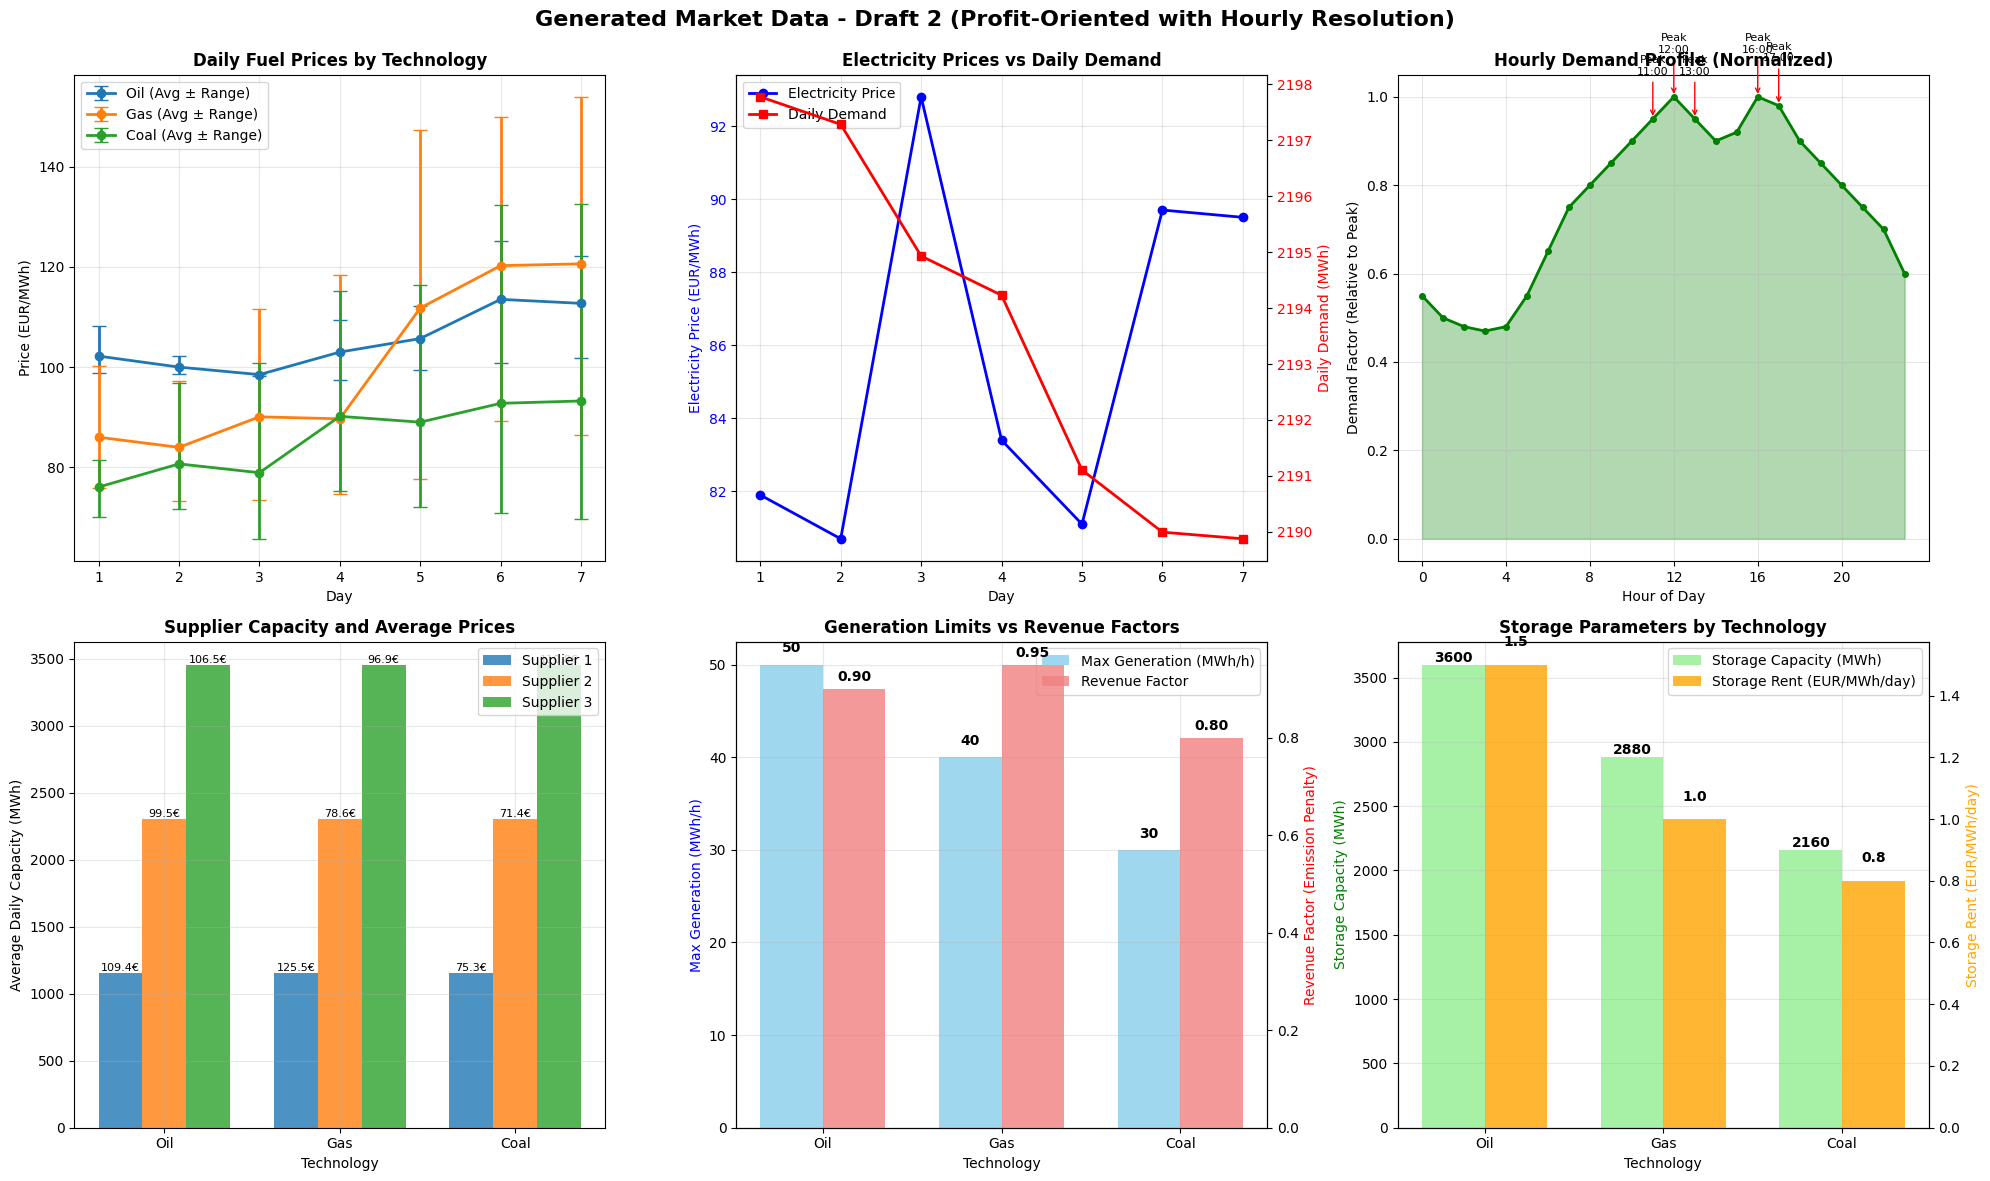

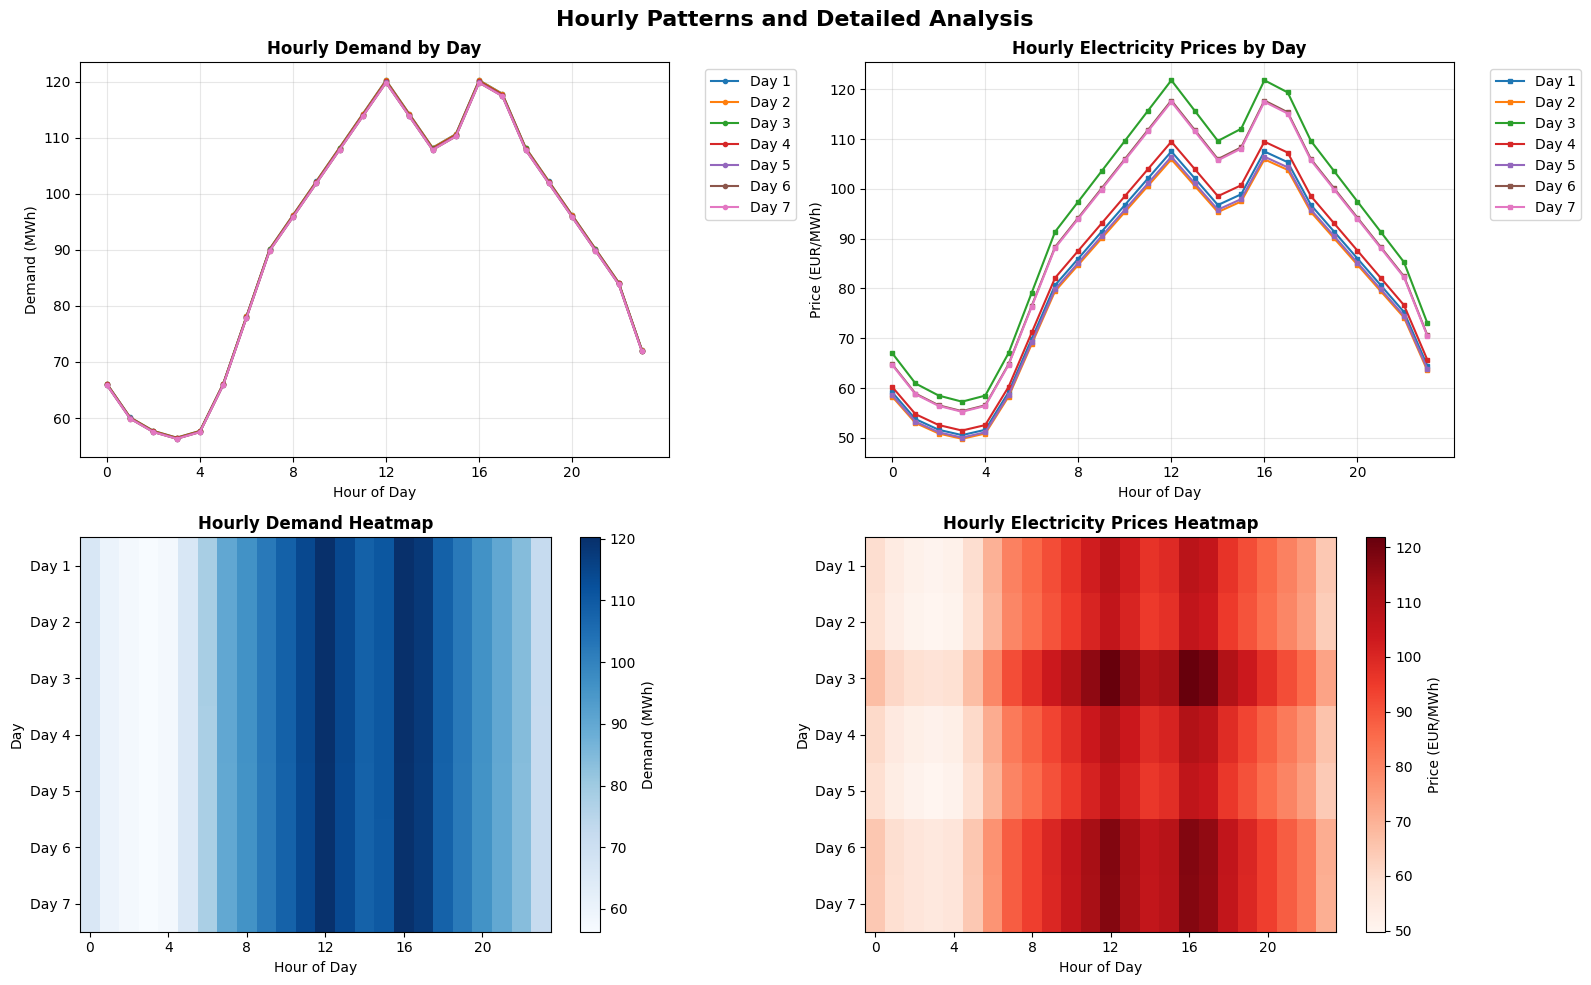


GENERATED DATA SUMMARY - DRAFT 2

Time Structure:
  Days: 7
  Hours per day: 24
  Total time periods: 168

Demand Structure:
  Weekly target: 15355.2 MWh
  Daily demand range: 2189.9 - 2197.8 MWh
  Total weekly demand: 15355.2 MWh
  Hourly factor range: 0.470 - 1.000

Electricity Prices:
  Base price: 85.0 EUR/MWh
  Daily price range: 80.7 - 92.8 EUR/MWh
  Daily average price: 85.6 EUR/MWh
  Hourly price range: 49.8 - 121.8 EUR/MWh

Technology Overview:
  OIL:
    Max generation: 50 MWh/h
    Storage capacity: 3600 MWh
    Storage rent: 1.5 EUR/MWh/day
    Revenue factor: 0.90
    Average fuel price: 105.1 EUR/MWh
    Average daily supplier capacity: 6912.0 MWh
  GAS:
    Max generation: 40 MWh/h
    Storage capacity: 2880 MWh
    Storage rent: 1.0 EUR/MWh/day
    Revenue factor: 0.95
    Average fuel price: 100.3 EUR/MWh
    Average daily supplier capacity: 6912.0 MWh
  COAL:
    Max generation: 30 MWh/h
    Storage capacity: 2160 MWh
    Storage rent: 0.8 EUR/MWh/day
    Revenue fac

In [57]:
# -------------------------------------------------------
# Visualization of Generated Data (Draft 2)
# -------------------------------------------------------

# Create comprehensive data visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Generated Market Data - Draft 2 (Profit-Oriented with Hourly Resolution)', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
days_range = range(1, num_days + 1)

# 1. Fuel Prices by Technology over Time
ax1 = axes[0, 0]
for tech_idx, tech in enumerate(TECHS):
    # Plot average price across all suppliers for each day
    daily_avg_prices = []
    daily_min_prices = []
    daily_max_prices = []
    
    for day in range(num_days):
        day_prices = [fuel_bids[tech][supplier]["price_EUR_per_MWh"][day] 
                     for supplier in SUPPLIERS[tech]]
        daily_avg_prices.append(np.mean(day_prices))
        daily_min_prices.append(min(day_prices))
        daily_max_prices.append(max(day_prices))
    
    # Plot average with error bars showing min/max range
    ax1.errorbar(days_range, daily_avg_prices, 
                yerr=[np.array(daily_avg_prices) - np.array(daily_min_prices),
                      np.array(daily_max_prices) - np.array(daily_avg_prices)],
                label=f'{tech} (Avg ± Range)', color=colors[tech_idx], 
                marker='o', linewidth=2, capsize=5)

ax1.set_title('Daily Fuel Prices by Technology', fontweight='bold')
ax1.set_xlabel('Day')
ax1.set_ylabel('Price (EUR/MWh)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Electricity Prices vs Daily Demand
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()

# Plot electricity prices
line1 = ax2.plot(days_range, daily_elec_price, 'b-o', linewidth=2, markersize=6, 
                label='Electricity Price')
ax2.set_ylabel('Electricity Price (EUR/MWh)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Plot daily demand on secondary axis
line2 = ax2_twin.plot(days_range, daily_demand, 'r-s', linewidth=2, markersize=6,
                     label='Daily Demand')
ax2_twin.set_ylabel('Daily Demand (MWh)', color='r')
ax2_twin.tick_params(axis='y', labelcolor='r')

ax2.set_title('Electricity Prices vs Daily Demand', fontweight='bold')
ax2.set_xlabel('Day')
ax2.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left')

# 3. Hourly Demand Profile (24h shape)
ax3 = axes[0, 2]
hours_range = range(24)
ax3.plot(hours_range, hourly_factors, 'g-o', linewidth=2, markersize=4)
ax3.fill_between(hours_range, hourly_factors, alpha=0.3, color='green')

ax3.set_title('Hourly Demand Profile (Normalized)', fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Demand Factor (Relative to Peak)')
ax3.set_xticks(range(0, 24, 4))
ax3.grid(True, alpha=0.3)

# Add peak hour annotations
peak_hours = [i for i, f in enumerate(hourly_factors) if f >= 0.95]
for peak_hour in peak_hours:
    ax3.annotate(f'Peak\n{peak_hour}:00', 
                xy=(peak_hour, hourly_factors[peak_hour]), 
                xytext=(peak_hour, hourly_factors[peak_hour] + 0.1),
                ha='center', fontsize=8,
                arrowprops=dict(arrowstyle='->', color='red', lw=1))

# 4. Supplier Capacity and Price Structure
ax4 = axes[1, 0]
width = 0.25
x_pos = np.arange(len(TECHS))

for supplier_idx in range(3):  # 3 suppliers per technology
    capacities = []
    avg_prices = []
    
    for tech in TECHS:
        supplier_name = SUPPLIERS[tech][supplier_idx]
        # Average capacity across all days
        avg_capacity = np.mean(fuel_bids[tech][supplier_name]["max_MWh_per_day"])
        # Average price across all days
        avg_price = np.mean(fuel_bids[tech][supplier_name]["price_EUR_per_MWh"])
        
        capacities.append(avg_capacity)
        avg_prices.append(avg_price)
    
    bars = ax4.bar(x_pos + supplier_idx * width, capacities, width,
                  label=f'Supplier {supplier_idx + 1}', alpha=0.8)
    
    # Add price labels on bars
    for i, (bar, price) in enumerate(zip(bars, avg_prices)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{price:.1f}€', ha='center', va='bottom', fontsize=8)

ax4.set_title('Supplier Capacity and Average Prices', fontweight='bold')
ax4.set_xlabel('Technology')
ax4.set_ylabel('Average Daily Capacity (MWh)')
ax4.set_xticks(x_pos + width)
ax4.set_xticklabels(TECHS)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Revenue Factors and Generation Limits
ax5 = axes[1, 1]
x_tech = np.arange(len(TECHS))
width = 0.35

# Plot max generation capacity
bars1 = ax5.bar(x_tech - width/2, [max_gen[tech] for tech in TECHS], 
               width, label='Max Generation (MWh/h)', alpha=0.8, color='skyblue')

# Plot revenue factors on secondary axis
ax5_twin = ax5.twinx()
bars2 = ax5_twin.bar(x_tech + width/2, [revenue_factor[tech] for tech in TECHS], 
                    width, label='Revenue Factor', alpha=0.8, color='lightcoral')

ax5.set_xlabel('Technology')
ax5.set_ylabel('Max Generation (MWh/h)', color='blue')
ax5_twin.set_ylabel('Revenue Factor (Emission Penalty)', color='red')
ax5.set_title('Generation Limits vs Revenue Factors', fontweight='bold')
ax5.set_xticks(x_tech)
ax5.set_xticklabels(TECHS)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Max generation labels
    height1 = bar1.get_height()
    ax5.text(bar1.get_x() + bar1.get_width()/2., height1 + 1,
            f'{height1:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # Revenue factor labels
    height2 = bar2.get_height()
    ax5_twin.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                 f'{height2:.2f}', ha='center', va='bottom', fontweight='bold')

ax5.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 6. Storage and Cost Parameters
ax6 = axes[1, 2]
x_tech = np.arange(len(TECHS))
width = 0.35

# Plot storage capacity
bars1 = ax6.bar(x_tech - width/2, [storage_cap[tech] for tech in TECHS], 
               width, label='Storage Capacity (MWh)', alpha=0.8, color='lightgreen')

# Plot storage rent on secondary axis
ax6_twin = ax6.twinx()
bars2 = ax6_twin.bar(x_tech + width/2, [storage_rent[tech] for tech in TECHS], 
                    width, label='Storage Rent (EUR/MWh/day)', alpha=0.8, color='orange')

ax6.set_xlabel('Technology')
ax6.set_ylabel('Storage Capacity (MWh)', color='green')
ax6_twin.set_ylabel('Storage Rent (EUR/MWh/day)', color='orange')
ax6.set_title('Storage Parameters by Technology', fontweight='bold')
ax6.set_xticks(x_tech)
ax6.set_xticklabels(TECHS)

# Add value labels
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Storage capacity labels
    height1 = bar1.get_height()
    ax6.text(bar1.get_x() + bar1.get_width()/2., height1 + 1,
            f'{height1:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # Storage rent labels
    height2 = bar2.get_height()
    ax6_twin.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.05,
                 f'{height2:.1f}', ha='center', va='bottom', fontweight='bold')

ax6.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Additional Hourly Patterns Visualization
# -------------------------------------------------------

# Create separate figure for hourly patterns
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))
fig2.suptitle('Hourly Patterns and Detailed Analysis', fontsize=16, fontweight='bold')

# 1. Hourly Demand for Each Day
ax2_1 = axes2[0, 0]
for d in range(num_days):
    ax2_1.plot(range(24), hourly_demand[d], label=f'Day {d+1}', 
              marker='o', linewidth=1.5, markersize=3)

ax2_1.set_title('Hourly Demand by Day', fontweight='bold')
ax2_1.set_xlabel('Hour of Day')
ax2_1.set_ylabel('Demand (MWh)')
ax2_1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2_1.grid(True, alpha=0.3)
ax2_1.set_xticks(range(0, 24, 4))

# 2. Hourly Electricity Prices for Each Day
ax2_2 = axes2[0, 1]
for d in range(num_days):
    ax2_2.plot(range(24), hourly_elec_price[d], label=f'Day {d+1}', 
              marker='s', linewidth=1.5, markersize=3)

ax2_2.set_title('Hourly Electricity Prices by Day', fontweight='bold')
ax2_2.set_xlabel('Hour of Day')
ax2_2.set_ylabel('Price (EUR/MWh)')
ax2_2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2_2.grid(True, alpha=0.3)
ax2_2.set_xticks(range(0, 24, 4))

# 3. Heatmap of Hourly Demand
ax2_3 = axes2[1, 0]
demand_matrix = np.array(hourly_demand)
im1 = ax2_3.imshow(demand_matrix, cmap='Blues', aspect='auto')
ax2_3.set_title('Hourly Demand Heatmap', fontweight='bold')
ax2_3.set_xlabel('Hour of Day')
ax2_3.set_ylabel('Day')
ax2_3.set_xticks(range(0, 24, 4))
ax2_3.set_yticks(range(num_days))
ax2_3.set_yticklabels([f'Day {d+1}' for d in range(num_days)])
plt.colorbar(im1, ax=ax2_3, label='Demand (MWh)')

# 4. Heatmap of Hourly Electricity Prices
ax2_4 = axes2[1, 1]
price_matrix = np.array(hourly_elec_price)
im2 = ax2_4.imshow(price_matrix, cmap='Reds', aspect='auto')
ax2_4.set_title('Hourly Electricity Prices Heatmap', fontweight='bold')
ax2_4.set_xlabel('Hour of Day')
ax2_4.set_ylabel('Day')
ax2_4.set_xticks(range(0, 24, 4))
ax2_4.set_yticks(range(num_days))
ax2_4.set_yticklabels([f'Day {d+1}' for d in range(num_days)])
plt.colorbar(im2, ax=ax2_4, label='Price (EUR/MWh)')

plt.tight_layout()
plt.show()

# Print data summary
print("\n" + "="*80)
print("GENERATED DATA SUMMARY - DRAFT 2")
print("="*80)

print(f"\nTime Structure:")
print(f"  Days: {num_days}")
print(f"  Hours per day: {num_hours}")
print(f"  Total time periods: {num_days * num_hours}")

print(f"\nDemand Structure:")
print(f"  Weekly target: {weekly_demand_target:.1f} MWh")
print(f"  Daily demand range: {min(daily_demand):.1f} - {max(daily_demand):.1f} MWh")
print(f"  Total weekly demand: {sum(daily_demand):.1f} MWh")
print(f"  Hourly factor range: {min(hourly_factors):.3f} - {max(hourly_factors):.3f}")

print(f"\nElectricity Prices:")
print(f"  Base price: {elec_base_price:.1f} EUR/MWh")
print(f"  Daily price range: {min(daily_elec_price):.1f} - {max(daily_elec_price):.1f} EUR/MWh")
print(f"  Daily average price: {np.mean(daily_elec_price):.1f} EUR/MWh")
print(f"  Hourly price range: {min(min(row) for row in hourly_elec_price):.1f} - {max(max(row) for row in hourly_elec_price):.1f} EUR/MWh")

print(f"\nTechnology Overview:")
for tech in TECHS:
    # Calculate average fuel price across all suppliers and days
    all_prices = []
    total_capacity = 0
    for supplier in SUPPLIERS[tech]:
        all_prices.extend(fuel_bids[tech][supplier]["price_EUR_per_MWh"])
        total_capacity += sum(fuel_bids[tech][supplier]["max_MWh_per_day"])
    
    avg_fuel_price = np.mean(all_prices)
    avg_capacity = total_capacity / num_days
    
    print(f"  {tech.upper()}:")
    print(f"    Max generation: {max_gen[tech]:.0f} MWh/h")
    print(f"    Storage capacity: {storage_cap[tech]:.0f} MWh")
    print(f"    Storage rent: {storage_rent[tech]:.1f} EUR/MWh/day")
    print(f"    Revenue factor: {revenue_factor[tech]:.2f}")
    print(f"    Average fuel price: {avg_fuel_price:.1f} EUR/MWh")
    print(f"    Average daily supplier capacity: {avg_capacity:.1f} MWh")

print(f"\nMarket Characteristics:")
print(f"  Number of suppliers per technology: {len(SUPPLIERS[TECHS[0]])}")
print(f"  Price volatility: Fuel prices include spikes and daily variations")
print(f"  Demand pattern: Daily variations with hourly load shape")
print(f"  Emission penalties: Reflected in revenue factors (Coal < Oil < Gas)")

## Optimization program

In [58]:

# -------------------------------------------------------
# Load data from JSON file
# -------------------------------------------------------
data_folder = Path("data")
data_file_path = data_folder / "data_draft_2.json"
data_file_path = data_file_path.resolve()
with open(data_file_path, "r") as f:
    data = json.load(f)

TECHS = data["technologies"]
num_days = data["time"]["num_days"]
num_hours = data["time"]["num_hours"]
DAYS = range(num_days)
HOURS = range(num_hours)

SUPPLIERS = {t: data["suppliers"][t] for t in TECHS}

# Demand
daily_demand = data["demand"]["daily_MWh"]            # [day]
hourly_demand = data["demand"]["hourly_MWh"]          # [day][hour]

# Tech parameters
max_gen = data["max_gen_MWh_per_hour"]                # tech -> hourly max
storage_cap = data["storage_capacity_MWh"]
storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
init_inventory = data["initial_inventory_MWh"]

# Market data
fuel_bids = data["fuel_bids"]                         # tech -> supplier -> {price[], max[]}
elec_price_hourly = data["electricity_price_EUR_per_MWh_hourly"]  # [day][hour]
revenue_factor = data["revenue_factor"]               # tech -> factor < 1

# Load deviation penalties
load_deviation_penalty = data["load_deviation_penalty"]
# Use default values if not present in data
severe_imbalance_threshold = data.get("severe_imbalance_threshold", 0.05)  # 5% threshold default
severe_penalty_multiplier = data.get("severe_penalty_multiplier", 2.0)    # 2x multiplier default

# Sanity checks
assert len(daily_demand) == num_days
assert len(elec_price_hourly) == num_days
for d in DAYS:
    assert len(hourly_demand[d]) == num_hours
    assert len(elec_price_hourly[d]) == num_hours

# -------------------------------------------------------
# Model
# -------------------------------------------------------
m = gp.Model("Weekly_Profit_Maximization_DailyFuel_HourlyPricesAndDemand")

# -------------------------------------------------------
# Decision variables
# -------------------------------------------------------

# Fuel purchases (MWh fuel) from supplier s for tech t on day d
purchase = m.addVars(
    ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
    name="purchase",
    lb=0.0
)

# Hourly generation (MWh) by tech t, day d, hour h
generate = m.addVars(
    ((t, d, h) for t in TECHS for d in DAYS for h in HOURS),
    name="generate",
    lb=0.0
)

# Inventory (MWh) at end of day d for tech t
inventory = m.addVars(
    ((t, d) for t in TECHS for d in DAYS),
    name="inventory",
    lb=0.0
)

# Load deviation variables (MWh) for each day d, hour h
under_generation = m.addVars(
    ((d, h) for d in DAYS for h in HOURS),
    name="under_generation",
    lb=0.0
)

over_generation = m.addVars(
    ((d, h) for d in DAYS for h in HOURS),
    name="over_generation", 
    lb=0.0
)

# -------------------------------------------------------
# Objective: Maximize profit = hourly revenue - costs
# -------------------------------------------------------

# Revenue: sum over tech, day, hour of (price_{d,h} * revenue_factor_t * generation_{t,d,h})
revenue = gp.quicksum(
    elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h]
    for t in TECHS for d in DAYS for h in HOURS
)

# Purchase cost: sum over tech, supplier, day of (price_{t,s,d} * purchase_{t,s,d})
purchase_cost = gp.quicksum(
    fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d]
    for t in TECHS for s in SUPPLIERS[t] for d in DAYS
)

# Storage cost: sum over tech, day of (storage_rent_{t} * inventory_{t,d})
storage_cost = gp.quicksum(
    storage_rent[t] * inventory[t, d]
    for t in TECHS for d in DAYS
)

# Load deviation penalty costs (simplified linear version)
under_gen_penalty_cost = gp.quicksum(
    load_deviation_penalty["under_generation"] * under_generation[d, h]
    for d in DAYS for h in HOURS
)

over_gen_penalty_cost = gp.quicksum(
    load_deviation_penalty["over_generation"] * over_generation[d, h]
    for d in DAYS for h in HOURS
)

m.setObjective(revenue - purchase_cost - storage_cost - under_gen_penalty_cost - over_gen_penalty_cost, GRB.MAXIMIZE)

# -------------------------------------------------------
# Constraints
# -------------------------------------------------------

# 1) Inventory balance per tech & day:
#    inventory[t,d] = inventory[t,d-1] + sum_s purchase[t,s,d] - sum_h generate[t,d,h]
for t in TECHS:
    for d in DAYS:
        if d == 0:
            prev_inv = init_inventory[t]
        else:
            prev_inv = inventory[t, d - 1]

        m.addConstr(
            inventory[t, d] ==
            prev_inv
            + gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t])
            - gp.quicksum(generate[t, d, h] for h in HOURS),
            name=f"inv_balance_{t}_day{d}"
        )

# 2) Hourly generation capacity:
#    generate[t,d,h] <= max_gen[t]
for t in TECHS:
    for d in DAYS:
        for h in HOURS:
            m.addConstr(
                generate[t, d, h] <= max_gen[t],
                name=f"gen_cap_{t}_day{d}_hour{h}"
            )

# 3) Storage capacity:
#    inventory[t,d] <= storage_cap[t]
for t in TECHS:
    for d in DAYS:
        m.addConstr(
            inventory[t, d] <= storage_cap[t],
            name=f"storage_cap_{t}_day{d}"
        )

# 4) Supplier daily offer limits:
#    purchase[t,s,d] <= max_offer[t,s,d]
for t in TECHS:
    for s in SUPPLIERS[t]:
        for d in DAYS:
            max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
            m.addConstr(
                purchase[t, s, d] <= max_offer,
                name=f"supplier_cap_{t}_{s}_day{d}"
            )

# 5) Load balance with deviation variables:
#    sum_t generate[t,d,h] + under_generation[d,h] - over_generation[d,h] = hourly_demand[d][h]
for d in DAYS:
    for h in HOURS:
        m.addConstr(
            gp.quicksum(generate[t, d, h] for t in TECHS) + under_generation[d, h] - over_generation[d, h] == hourly_demand[d][h],
            name=f"load_balance_day{d}_hour{h}"
        )

# 6) End-of-week inventory must be zero (no terminal value for remaining fuel)
last_day = num_days - 1
for t in TECHS:
    m.addConstr(
        inventory[t, last_day] == 0.0,
        name=f"end_inventory_zero_{t}"
    )

# -------------------------------------------------------
# Solve
# -------------------------------------------------------
m.optimize()

# -------------------------------------------------------
# Print solution
# -------------------------------------------------------
if m.status == GRB.OPTIMAL:
    print(f"Optimal profit: {m.objVal:.2f} EUR")
    
    print("\n=== Example: hourly prices & demand for day 0 ===")
    for h in HOURS:
        print(
            f"Hour {h:02d}: Price = {elec_price_hourly[0][h]:6.2f} €/MWh, "
            f"Demand = {hourly_demand[0][h]:6.3f} MWh"
        )
    
    print("\n=== Daily fuel purchases (MWh) by tech / supplier ===")
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                val = purchase[t, s, d].X
                if val > 1e-6:
                    print(f"Purchase[{t}, {s}, day {d}] = {val:.2f} MWh")

    print("\n=== Total generation (MWh) by tech and day ===")
    for t in TECHS:
        for d in DAYS:
            day_total = sum(generate[t, d, h].X for h in HOURS)
            if day_total > 1e-6:
                print(f"Generation[{t}, day {d}] = {day_total:.2f} MWh")
    
    print("\n=== End-of-day inventory (MWh) ===")
    for t in TECHS:
        for d in DAYS:
            val = inventory[t, d].X
            if val > 1e-6:
                print(f"Inventory[{t}, day {d}] = {val:.2f} MWh")
else:
    print(f"Model ended with status {m.status}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 780 rows, 924 columns and 2037 nonzeros
Model fingerprint: 0xa733ed48
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 4e+03]
Presolve removed 599 rows and 64 columns
Presolve time: 0.05s
Presolved: 181 rows, 860 columns, 1358 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5382179e+06   2.585235e+03   0.000000e+00      0s
     129    1.1754826e+04   0.000000e+00   0.000000e+00      0s

Use crossover to convert LP symmetric solution to basic solution...
Crossover log...

       1 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushes remaining with PIn

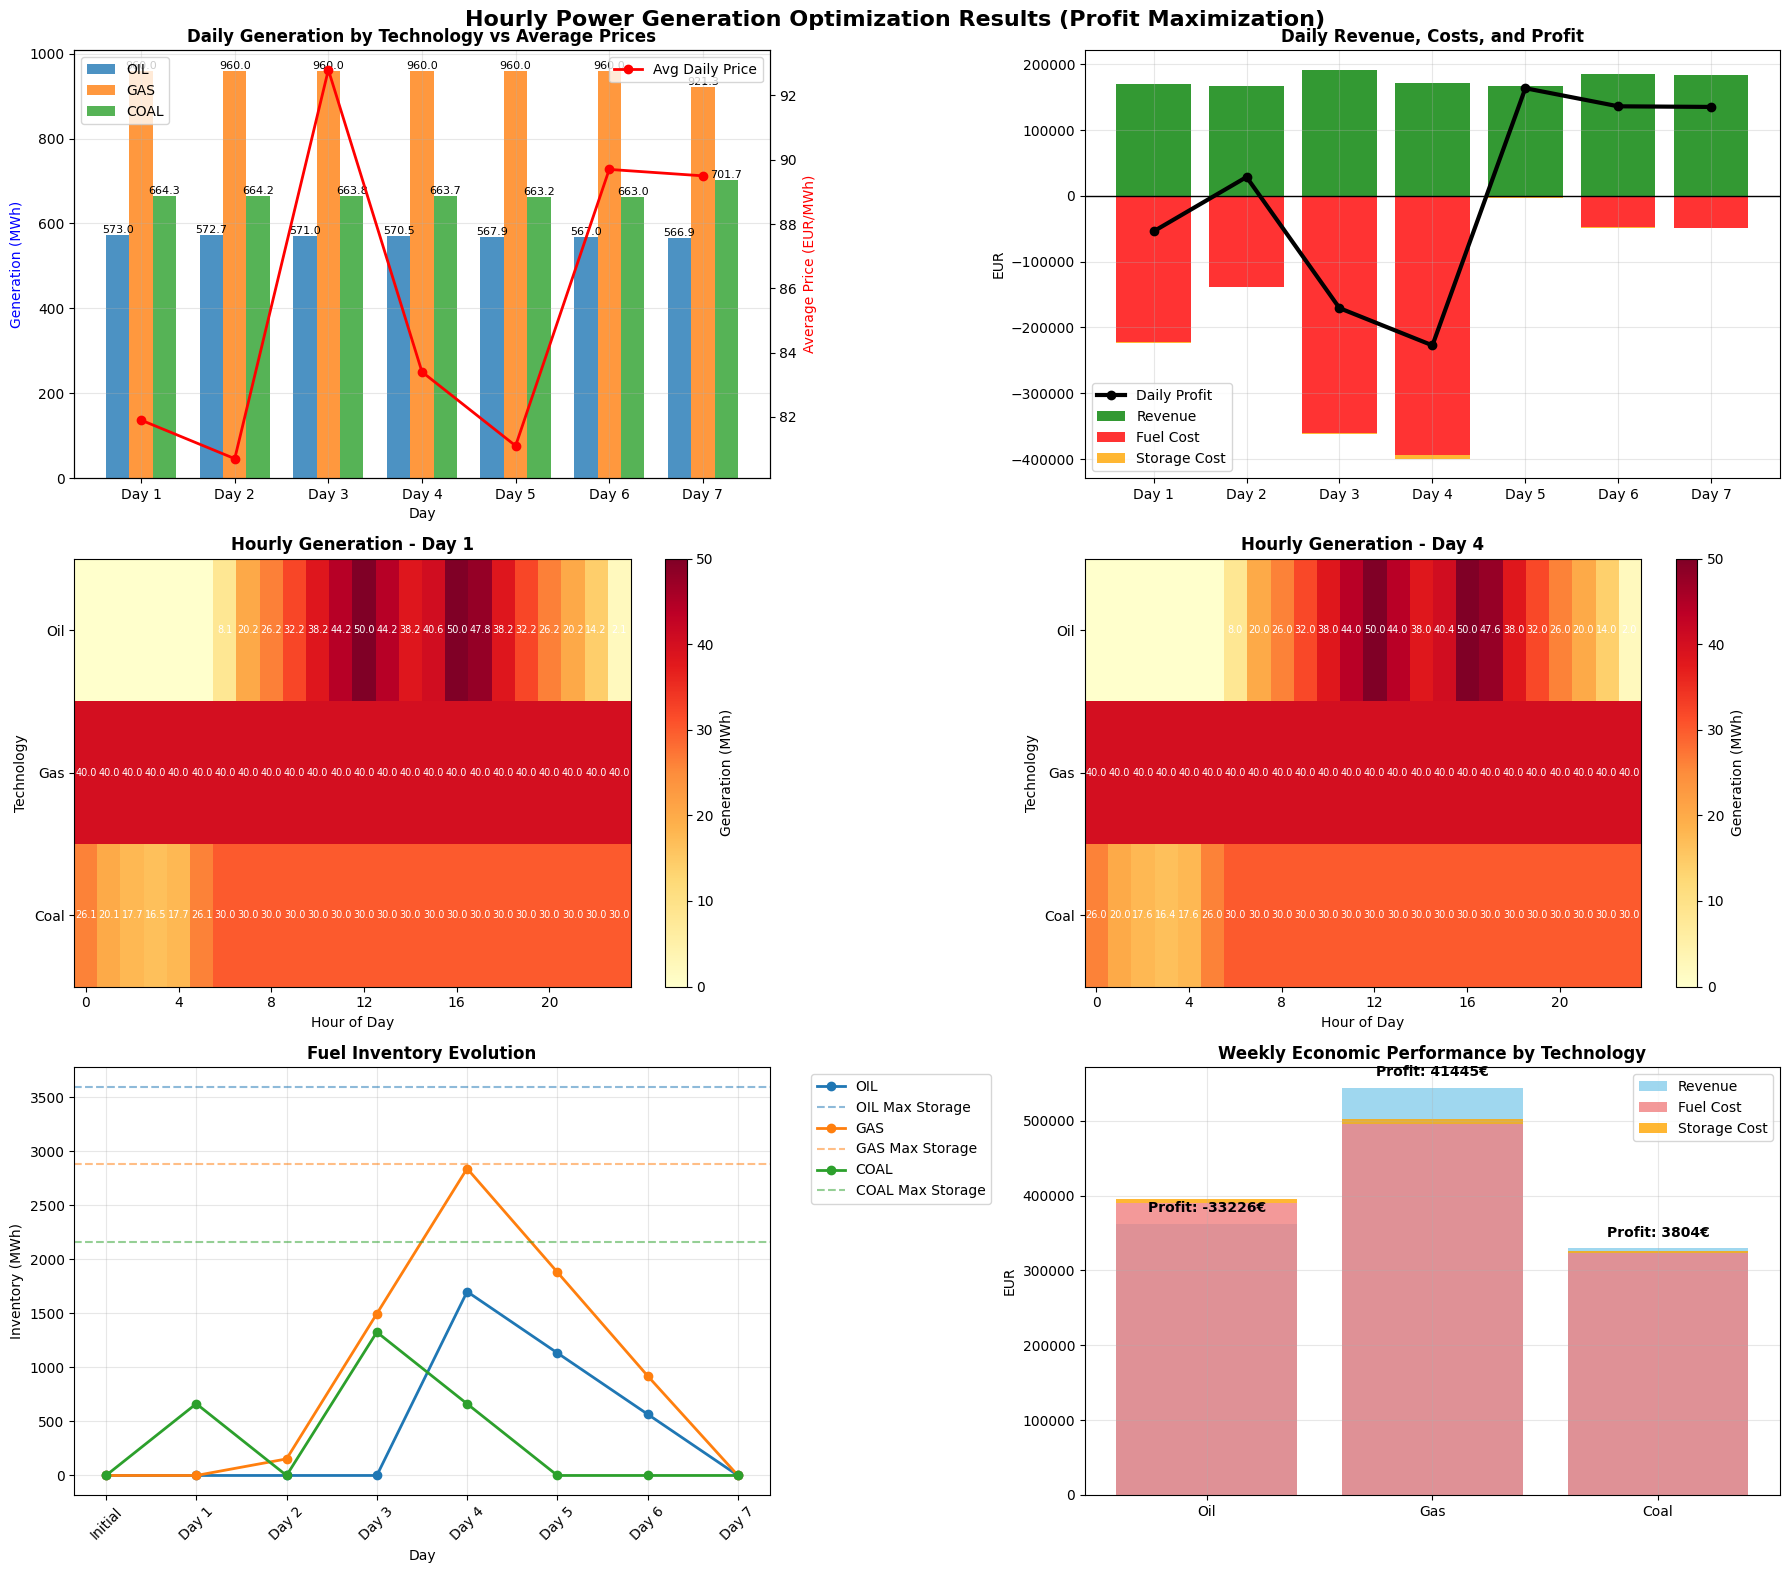

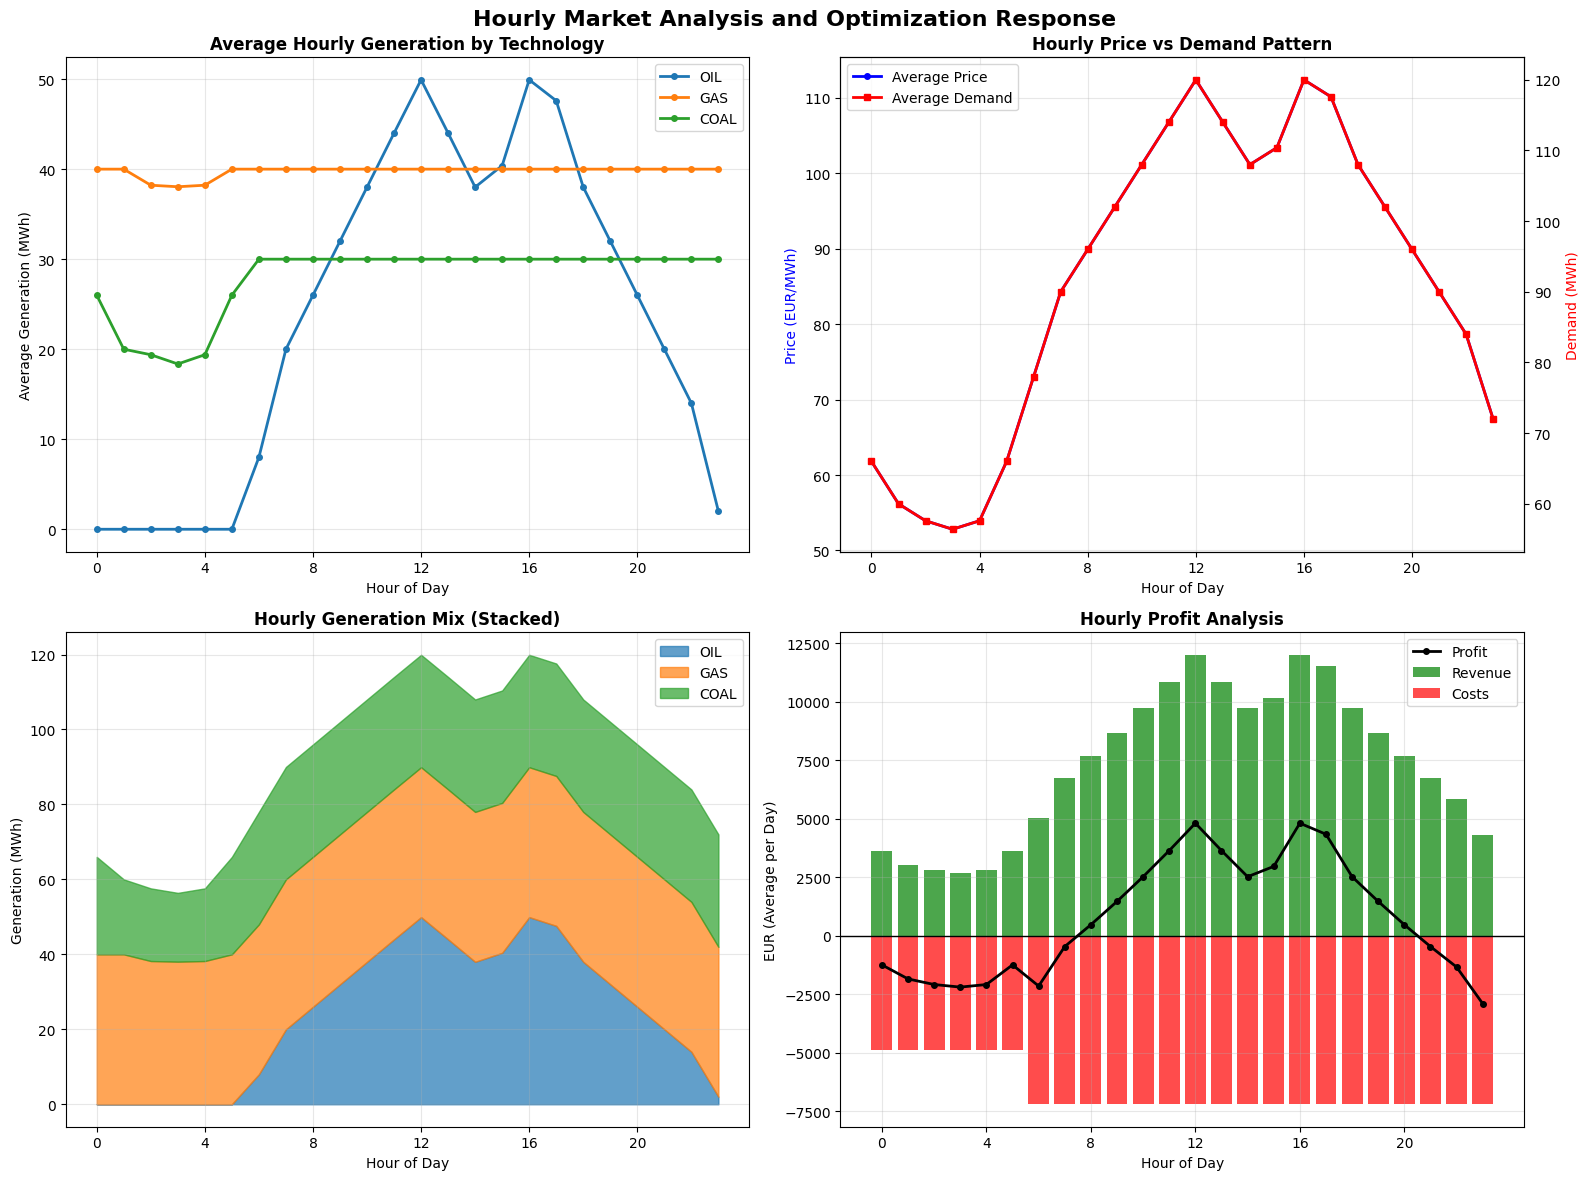


HOURLY OPTIMIZATION RESULTS SUMMARY

Weekly Performance:
  Total Revenue: 1236163.25 EUR
  Total Fuel Cost: 1209617.84 EUR
  Total Storage Cost: 14521.84 EUR
  Total Profit: 12023.58 EUR
  Profit Margin: 1.0%

Technology Performance:
  OIL:
    Total Generation: 3988.92 MWh
    Capacity Utilization: 47.5%
    Revenue: 362460.07 EUR
    Profit: -33225.66 EUR
    Profit Margin: -9.2%
  GAS:
    Total Generation: 6681.31 MWh
    Capacity Utilization: 99.4%
    Revenue: 544320.58 EUR
    Profit: 41445.45 EUR
    Profit Margin: 7.6%
  COAL:
    Total Generation: 4683.89 MWh
    Capacity Utilization: 92.9%
    Revenue: 329382.61 EUR
    Profit: 3803.79 EUR
    Profit Margin: 1.2%

Hourly Insights:
  Peak price hour: 12:00 (112.37 EUR/MWh)
  Off-peak price hour: 3:00 (52.81 EUR/MWh)
  Maximum generation hour: 12:00 (119.92 MWh)
  Price volatility: 20.23 EUR/MWh (std dev)


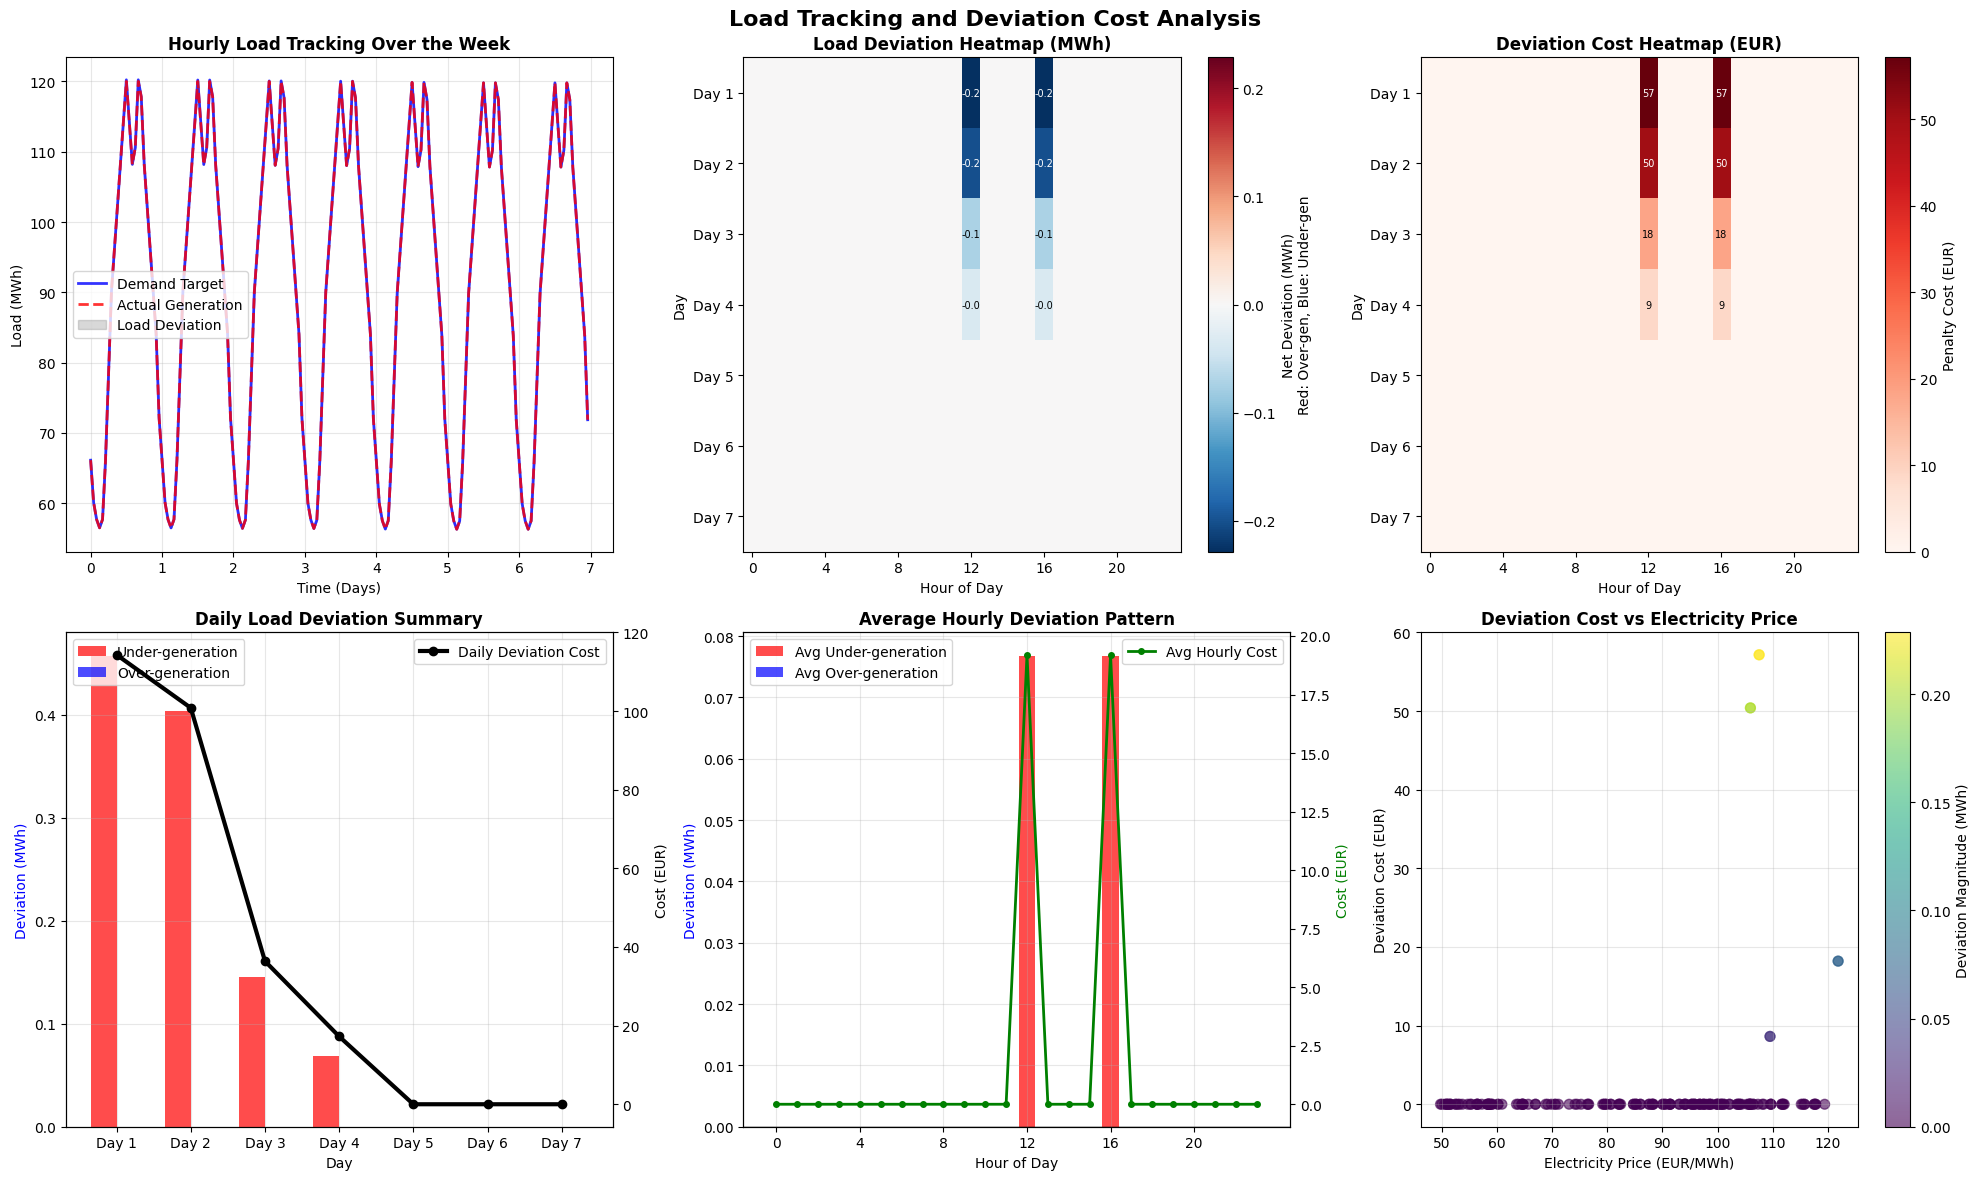


Load Deviation Analysis:
  Total Under-generation: 1.07 MWh
  Total Over-generation: 0.00 MWh
  Total Deviation Cost: 268.75 EUR
  Average Deviation Cost per Hour: 1.60 EUR
  Worst deviation: Day 1, Hour 12:00
    Under-generation: 0.23 MWh
    Over-generation: 0.00 MWh
    Penalty cost: 57.15 EUR
  Total Load Deviation: 0.01% of total demand
  Deviation Cost Impact: 2.24% of total profit


In [59]:
# -------------------------------------------------------
# Visualization of Hourly Optimization Results
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    # Extract solution data
    purchase_data = {}
    generate_data = {}
    inventory_data = {}
    hourly_generate_data = {}
    
    for t in TECHS:
        purchase_data[t] = []
        generate_data[t] = []
        inventory_data[t] = []
        hourly_generate_data[t] = []
        
        for d in DAYS:
            # Daily totals
            total_purchase = sum(purchase[t, s, d].X for s in SUPPLIERS[t])
            daily_generation = sum(generate[t, d, h].X for h in HOURS)
            
            purchase_data[t].append(total_purchase)
            generate_data[t].append(daily_generation)
            inventory_data[t].append(inventory[t, d].X)
            
            # Hourly generation data
            hourly_gen = [generate[t, d, h].X for h in HOURS]
            hourly_generate_data[t].append(hourly_gen)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Hourly Power Generation Optimization Results (Profit Maximization)', fontsize=16, fontweight='bold')
    
    days_labels = [f'Day {d+1}' for d in DAYS]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # 1. Daily Generation vs Prices
    ax1 = axes[0, 0]
    width = 0.25
    x = np.arange(len(DAYS))
    
    for i, tech in enumerate(TECHS):
        bars = ax1.bar(x + i*width, generate_data[tech], width, 
                      label=tech.upper(), color=colors[i], alpha=0.8)
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.1:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Add daily electricity prices on secondary axis
    ax1_twin = ax1.twinx()
    daily_avg_prices = [np.mean(elec_price_hourly[d]) for d in DAYS]
    ax1_twin.plot(x + width, daily_avg_prices, 'ro-', linewidth=2, markersize=6,
                 label='Avg Daily Price')
    
    ax1.set_title('Daily Generation by Technology vs Average Prices', fontweight='bold')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Generation (MWh)', color='blue')
    ax1_twin.set_ylabel('Average Price (EUR/MWh)', color='red')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(days_labels)
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Revenue and Cost Breakdown
    ax2 = axes[0, 1]
    
    # Calculate daily components
    daily_revenue = []
    daily_fuel_cost = []
    daily_storage_cost = []
    
    for d in DAYS:
        # Daily revenue
        day_revenue = sum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h].X
            for t in TECHS for h in HOURS
        )
        daily_revenue.append(day_revenue)
        
        # Daily fuel cost
        day_fuel_cost = sum(
            fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
            for t in TECHS for s in SUPPLIERS[t]
        )
        daily_fuel_cost.append(day_fuel_cost)
        
        # Daily storage cost
        day_storage_cost = sum(
            storage_rent[t] * inventory[t, d].X
            for t in TECHS
        )
        daily_storage_cost.append(day_storage_cost)
    
    # Plot stacked costs vs revenue
    ax2.bar(days_labels, daily_revenue, label='Revenue', color='green', alpha=0.8)
    ax2.bar(days_labels, [-cost for cost in daily_fuel_cost], label='Fuel Cost', 
           color='red', alpha=0.8)
    ax2.bar(days_labels, [-cost for cost in daily_storage_cost], 
           bottom=[-cost for cost in daily_fuel_cost],
           label='Storage Cost', color='orange', alpha=0.8)
    
    # Add daily profit line
    daily_profit = [rev - fuel - storage for rev, fuel, storage in 
                   zip(daily_revenue, daily_fuel_cost, daily_storage_cost)]
    ax2.plot(days_labels, daily_profit, 'ko-', linewidth=3, markersize=6,
            label='Daily Profit')
    
    ax2.set_title('Daily Revenue, Costs, and Profit', fontweight='bold')
    ax2.set_ylabel('EUR')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # 3. Hourly Generation Heatmap for Day 0 and Day 3 (sample days)
    for day_idx, sample_day in enumerate([0, 3]):
        if sample_day < num_days:
            ax3 = axes[1, day_idx]
            
            # Create generation matrix for heatmap
            gen_matrix = []
            for t in TECHS:
                hourly_gen = [generate[t, sample_day, h].X for h in HOURS]
                gen_matrix.append(hourly_gen)
            
            gen_matrix = np.array(gen_matrix)
            
            im = ax3.imshow(gen_matrix, cmap='YlOrRd', aspect='auto')
            ax3.set_title(f'Hourly Generation - Day {sample_day + 1}', fontweight='bold')
            ax3.set_xlabel('Hour of Day')
            ax3.set_ylabel('Technology')
            ax3.set_xticks(range(0, 24, 4))
            ax3.set_yticks(range(len(TECHS)))
            ax3.set_yticklabels(TECHS)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax3)
            cbar.set_label('Generation (MWh)')
            
            # Add text annotations for non-zero values
            for i in range(len(TECHS)):
                for j in range(num_hours):
                    if gen_matrix[i, j] > 0.01:
                        ax3.text(j, i, f'{gen_matrix[i, j]:.1f}', 
                               ha='center', va='center', fontsize=7, color='white')
    
    # 4. Inventory Evolution
    ax4 = axes[2, 0]
    for i, tech in enumerate(TECHS):
        # Add initial inventory as day 0
        inv_with_initial = [init_inventory[tech]] + inventory_data[tech]
        days_with_initial = ['Initial'] + days_labels
        
        ax4.plot(days_with_initial, inv_with_initial, 
                marker='o', linewidth=2, markersize=6,
                label=tech.upper(), color=colors[i])
        
        # Add storage capacity limit
        ax4.axhline(y=storage_cap[tech], color=colors[i], 
                   linestyle='--', alpha=0.5, 
                   label=f'{tech.upper()} Max Storage')
    
    ax4.set_title('Fuel Inventory Evolution', fontweight='bold')
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Inventory (MWh)')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Merit Order Analysis
    ax5 = axes[2, 1]
    
    # Calculate technology-level economics
    tech_revenues = {}
    tech_fuel_costs = {}
    tech_storage_costs = {}
    tech_profits = {}
    
    for t in TECHS:
        # Total revenue by technology
        tech_revenue = sum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h].X
            for d in DAYS for h in HOURS
        )
        tech_revenues[t] = tech_revenue
        
        # Total fuel costs by technology
        tech_fuel_cost = sum(
            fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
            for s in SUPPLIERS[t] for d in DAYS
        )
        tech_fuel_costs[t] = tech_fuel_cost
        
        # Total storage costs by technology
        tech_storage_cost = sum(
            storage_rent[t] * inventory[t, d].X
            for d in DAYS
        )
        tech_storage_costs[t] = tech_storage_cost
        
        # Technology profit
        tech_profits[t] = tech_revenue - tech_fuel_cost - tech_storage_cost
    
    # Create stacked bar chart
    revenues = [tech_revenues[t] for t in TECHS]
    fuel_costs = [tech_fuel_costs[t] for t in TECHS]
    storage_costs = [tech_storage_costs[t] for t in TECHS]
    profits = [tech_profits[t] for t in TECHS]
    
    bars1 = ax5.bar(TECHS, revenues, label='Revenue', color='skyblue', alpha=0.8)
    bars2 = ax5.bar(TECHS, fuel_costs, bottom=[0]*len(TECHS), 
                   label='Fuel Cost', color='lightcoral', alpha=0.8)
    bars3 = ax5.bar(TECHS, storage_costs, bottom=fuel_costs, 
                   label='Storage Cost', color='orange', alpha=0.8)
    
    # Add profit values as text
    for i, (tech, profit) in enumerate(zip(TECHS, profits)):
        ax5.text(i, revenues[i] + max(revenues)*0.02, f'Profit: {profit:.0f}€', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax5.set_title('Weekly Economic Performance by Technology', fontweight='bold')
    ax5.set_ylabel('EUR')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Hourly Analysis for Peak and Off-Peak Hours
    # -------------------------------------------------------
    
    # Create additional figure for hourly analysis
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle('Hourly Market Analysis and Optimization Response', fontsize=16, fontweight='bold')
    
    # 1. Average Hourly Generation by Technology
    ax2_1 = axes2[0, 0]
    
    # Calculate average hourly generation across all days
    avg_hourly_gen = {}
    for t in TECHS:
        avg_hourly_gen[t] = []
        for h in HOURS:
            avg_gen = np.mean([generate[t, d, h].X for d in DAYS])
            avg_hourly_gen[t].append(avg_gen)
    
    for i, tech in enumerate(TECHS):
        ax2_1.plot(HOURS, avg_hourly_gen[tech], label=tech.upper(), 
                  color=colors[i], linewidth=2, marker='o', markersize=4)
    
    ax2_1.set_title('Average Hourly Generation by Technology', fontweight='bold')
    ax2_1.set_xlabel('Hour of Day')
    ax2_1.set_ylabel('Average Generation (MWh)')
    ax2_1.legend()
    ax2_1.grid(True, alpha=0.3)
    ax2_1.set_xticks(range(0, 24, 4))
    
    # 2. Price-Generation Correlation
    ax2_2 = axes2[0, 1]
    
    # Average hourly prices and total generation
    avg_hourly_price = [np.mean([elec_price_hourly[d][h] for d in DAYS]) for h in HOURS]
    avg_hourly_total_gen = [sum(avg_hourly_gen[t][h] for t in TECHS) for h in HOURS]
    avg_hourly_demand = [np.mean([hourly_demand[d][h] for d in DAYS]) for h in HOURS]
    
    ax2_2_twin = ax2_2.twinx()
    
    line1 = ax2_2.plot(HOURS, avg_hourly_price, 'b-o', linewidth=2, markersize=4,
                      label='Average Price')
    line2 = ax2_2_twin.plot(HOURS, avg_hourly_demand, 'r-s', linewidth=2, markersize=4,
                           label='Average Demand')
    
    ax2_2.set_title('Hourly Price vs Demand Pattern', fontweight='bold')
    ax2_2.set_xlabel('Hour of Day')
    ax2_2.set_ylabel('Price (EUR/MWh)', color='blue')
    ax2_2_twin.set_ylabel('Demand (MWh)', color='red')
    ax2_2.set_xticks(range(0, 24, 4))
    ax2_2.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2_2.legend(lines, labels, loc='upper left')
    
    # 3. Technology Merit Order Response
    ax2_3 = axes2[1, 0]
    
    # Show which technology is most active at different hours
    tech_dominance = []
    for h in HOURS:
        hour_gen = {t: avg_hourly_gen[t][h] for t in TECHS}
        dominant_tech = max(hour_gen, key=hour_gen.get) if max(hour_gen.values()) > 0.01 else None
        tech_dominance.append(dominant_tech)
    
    # Create stacked area chart
    bottom = np.zeros(num_hours)
    for i, tech in enumerate(TECHS):
        values = avg_hourly_gen[tech]
        ax2_3.fill_between(HOURS, bottom, bottom + values, 
                          label=tech.upper(), color=colors[i], alpha=0.7)
        bottom += values
    
    ax2_3.set_title('Hourly Generation Mix (Stacked)', fontweight='bold')
    ax2_3.set_xlabel('Hour of Day')
    ax2_3.set_ylabel('Generation (MWh)')
    ax2_3.legend()
    ax2_3.grid(True, alpha=0.3)
    ax2_3.set_xticks(range(0, 24, 4))
    
    # 4. Profit Margins by Hour
    ax2_4 = axes2[1, 1]
    
    # Calculate hourly profit margins
    hourly_revenue = []
    hourly_costs = []
    
    for h in HOURS:
        # Average hourly revenue across all days
        hour_rev = np.mean([
            sum(elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h].X 
                for t in TECHS) for d in DAYS
        ])
        hourly_revenue.append(hour_rev)
        
        # Estimate hourly fuel costs (proportional to generation)
        total_daily_gen = {t: sum(generate[t, d, h].X for d in DAYS for h_all in HOURS) for t in TECHS}
        hour_gen = {t: sum(generate[t, d, h].X for d in DAYS) for t in TECHS}
        
        hour_cost = 0
        for t in TECHS:
            if total_daily_gen[t] > 0:
                # Proportional fuel cost allocation
                fuel_cost_share = hour_gen[t] / total_daily_gen[t] if total_daily_gen[t] > 0 else 0
                total_tech_fuel_cost = sum(
                    fuel_bids[t][s]["price_EUR_per_MWh"][d] * purchase[t, s, d].X
                    for s in SUPPLIERS[t] for d in DAYS
                )
                hour_cost += fuel_cost_share * total_tech_fuel_cost
        
        hourly_costs.append(hour_cost / num_days)  # Average per day
    
    hourly_profit = [rev - cost for rev, cost in zip(hourly_revenue, hourly_costs)]
    
    ax2_4.bar(HOURS, hourly_revenue, alpha=0.7, label='Revenue', color='green')
    ax2_4.bar(HOURS, [-cost for cost in hourly_costs], alpha=0.7, label='Costs', color='red')
    ax2_4.plot(HOURS, hourly_profit, 'ko-', linewidth=2, markersize=4, label='Profit')
    
    ax2_4.set_title('Hourly Profit Analysis', fontweight='bold')
    ax2_4.set_xlabel('Hour of Day')
    ax2_4.set_ylabel('EUR (Average per Day)')
    ax2_4.legend()
    ax2_4.grid(True, alpha=0.3)
    ax2_4.set_xticks(range(0, 24, 4))
    ax2_4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*80)
    print("HOURLY OPTIMIZATION RESULTS SUMMARY")
    print("="*80)
    
    total_revenue = sum(tech_revenues.values())
    total_fuel_cost = sum(tech_fuel_costs.values())
    total_storage_cost = sum(tech_storage_costs.values())
    total_profit = total_revenue - total_fuel_cost - total_storage_cost
    
    print(f"\nWeekly Performance:")
    print(f"  Total Revenue: {total_revenue:.2f} EUR")
    print(f"  Total Fuel Cost: {total_fuel_cost:.2f} EUR")
    print(f"  Total Storage Cost: {total_storage_cost:.2f} EUR")
    print(f"  Total Profit: {total_profit:.2f} EUR")
    print(f"  Profit Margin: {100*total_profit/total_revenue:.1f}%")
    
    print(f"\nTechnology Performance:")
    for t in TECHS:
        tech_generation = sum(sum(generate[t, d, h].X for h in HOURS) for d in DAYS)
        tech_capacity_utilization = tech_generation / (max_gen[t] * num_days * num_hours) * 100
        tech_profit_margin = tech_profits[t] / tech_revenues[t] * 100 if tech_revenues[t] > 0 else 0
        
        print(f"  {t.upper()}:")
        print(f"    Total Generation: {tech_generation:.2f} MWh")
        print(f"    Capacity Utilization: {tech_capacity_utilization:.1f}%")
        print(f"    Revenue: {tech_revenues[t]:.2f} EUR")
        print(f"    Profit: {tech_profits[t]:.2f} EUR")
        print(f"    Profit Margin: {tech_profit_margin:.1f}%")
    
    print(f"\nHourly Insights:")
    peak_hour = np.argmax(avg_hourly_price)
    off_peak_hour = np.argmin(avg_hourly_price)
    max_gen_hour = np.argmax(avg_hourly_total_gen)
    
    print(f"  Peak price hour: {peak_hour}:00 ({avg_hourly_price[peak_hour]:.2f} EUR/MWh)")
    print(f"  Off-peak price hour: {off_peak_hour}:00 ({avg_hourly_price[off_peak_hour]:.2f} EUR/MWh)")
    print(f"  Maximum generation hour: {max_gen_hour}:00 ({avg_hourly_total_gen[max_gen_hour]:.2f} MWh)")
    print(f"  Price volatility: {np.std(avg_hourly_price):.2f} EUR/MWh (std dev)")

    # -------------------------------------------------------
    # Load Tracking and Deviation Analysis
    # -------------------------------------------------------
    
    # Create dedicated figure for load deviation analysis
    fig3, axes3 = plt.subplots(2, 3, figsize=(20, 12))
    fig3.suptitle('Load Tracking and Deviation Cost Analysis', fontsize=16, fontweight='bold')
    
    # Extract deviation data from optimization results
    under_gen_data = []
    over_gen_data = []
    deviation_costs = []
    actual_generation = []
    
    for d in DAYS:
        under_gen_day = []
        over_gen_day = []
        cost_day = []
        actual_gen_day = []
        
        for h in HOURS:
            under_dev = under_generation[d, h].X
            over_dev = over_generation[d, h].X
            actual_gen = sum(generate[t, d, h].X for t in TECHS)
            
            # Calculate hourly deviation cost
            under_cost = load_deviation_penalty["under_generation"] * under_dev
            over_cost = load_deviation_penalty["over_generation"] * over_dev
            
            # Apply severe imbalance penalty if deviation > 5% of demand
            if under_dev >= severe_imbalance_threshold * hourly_demand[d][h]:
                under_cost *= severe_penalty_multiplier
            if over_dev >= severe_imbalance_threshold * hourly_demand[d][h]:
                over_cost *= severe_penalty_multiplier
                
            total_cost = under_cost + over_cost
            
            under_gen_day.append(under_dev)
            over_gen_day.append(over_dev)
            cost_day.append(total_cost)
            actual_gen_day.append(actual_gen)
        
        under_gen_data.append(under_gen_day)
        over_gen_data.append(over_gen_day)
        deviation_costs.append(cost_day)
        actual_generation.append(actual_gen_day)
    
    # Convert to numpy arrays for easier manipulation
    under_gen_matrix = np.array(under_gen_data)
    over_gen_matrix = np.array(over_gen_data)
    cost_matrix = np.array(deviation_costs)
    
    # 1. Hourly Load Tracking Over the Week
    ax3_1 = axes3[0, 0]
    
    # Create time series for x-axis (day.hour format)
    time_points = []
    demand_series = []
    generation_series = []
    
    for d in DAYS:
        for h in HOURS:
            time_points.append(d + h/24)  # Day.fractional_hour
            demand_series.append(hourly_demand[d][h])
            generation_series.append(sum(generate[t, d, h].X for t in TECHS))
    
    ax3_1.plot(time_points, demand_series, 'b-', linewidth=2, label='Demand Target', alpha=0.8)
    ax3_1.plot(time_points, generation_series, 'r--', linewidth=2, label='Actual Generation', alpha=0.8)
    ax3_1.fill_between(time_points, demand_series, generation_series, 
                      alpha=0.3, color='gray', label='Load Deviation')
    
    ax3_1.set_title('Hourly Load Tracking Over the Week', fontweight='bold')
    ax3_1.set_xlabel('Time (Days)')
    ax3_1.set_ylabel('Load (MWh)')
    ax3_1.legend()
    ax3_1.grid(True, alpha=0.3)
    ax3_1.set_xticks(range(num_days + 1))
    
    # 2. Load Deviation Heatmap
    ax3_2 = axes3[0, 1]
    
    # Calculate net deviation (positive = over-generation, negative = under-generation)
    net_deviation_matrix = over_gen_matrix - under_gen_matrix
    
    im1 = ax3_2.imshow(net_deviation_matrix, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(net_deviation_matrix)), vmax=np.max(np.abs(net_deviation_matrix)))
    ax3_2.set_title('Load Deviation Heatmap (MWh)', fontweight='bold')
    ax3_2.set_xlabel('Hour of Day')
    ax3_2.set_ylabel('Day')
    ax3_2.set_xticks(range(0, 24, 4))
    ax3_2.set_yticks(range(num_days))
    ax3_2.set_yticklabels([f'Day {d+1}' for d in DAYS])
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax3_2)
    cbar1.set_label('Net Deviation (MWh)\nRed: Over-gen, Blue: Under-gen')
    
    # Add text annotations for significant deviations
    for d in range(num_days):
        for h in range(num_hours):
            if abs(net_deviation_matrix[d, h]) > 0.01:
                ax3_2.text(h, d, f'{net_deviation_matrix[d, h]:.1f}', 
                          ha='center', va='center', fontsize=7, 
                          color='white' if abs(net_deviation_matrix[d, h]) > np.max(np.abs(net_deviation_matrix))*0.5 else 'black')
    
    # 3. Deviation Cost Heatmap
    ax3_3 = axes3[0, 2]
    
    im2 = ax3_3.imshow(cost_matrix, cmap='Reds', aspect='auto')
    ax3_3.set_title('Deviation Cost Heatmap (EUR)', fontweight='bold')
    ax3_3.set_xlabel('Hour of Day')
    ax3_3.set_ylabel('Day')
    ax3_3.set_xticks(range(0, 24, 4))
    ax3_3.set_yticks(range(num_days))
    ax3_3.set_yticklabels([f'Day {d+1}' for d in DAYS])
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax3_3)
    cbar2.set_label('Penalty Cost (EUR)')
    
    # Add cost annotations for significant costs
    for d in range(num_days):
        for h in range(num_hours):
            if cost_matrix[d, h] > 0.1:
                ax3_3.text(h, d, f'{cost_matrix[d, h]:.0f}', 
                          ha='center', va='center', fontsize=7, 
                          color='white' if cost_matrix[d, h] > np.max(cost_matrix)*0.5 else 'black')
    
    # 4. Daily Deviation Summary
    ax3_4 = axes3[1, 0]
    
    daily_under_gen = [sum(under_gen_data[d]) for d in range(num_days)]
    daily_over_gen = [sum(over_gen_data[d]) for d in range(num_days)]
    daily_dev_costs = [sum(deviation_costs[d]) for d in range(num_days)]
    
    x_days = range(num_days)
    width = 0.35
    
    bars1 = ax3_4.bar([x - width/2 for x in x_days], daily_under_gen, width, 
                     label='Under-generation', color='red', alpha=0.7)
    bars2 = ax3_4.bar([x + width/2 for x in x_days], daily_over_gen, width, 
                     label='Over-generation', color='blue', alpha=0.7)
    
    # Add cost line on secondary axis
    ax3_4_twin = ax3_4.twinx()
    ax3_4_twin.plot(x_days, daily_dev_costs, 'ko-', linewidth=3, markersize=6,
                   label='Daily Deviation Cost')
    
    ax3_4.set_title('Daily Load Deviation Summary', fontweight='bold')
    ax3_4.set_xlabel('Day')
    ax3_4.set_ylabel('Deviation (MWh)', color='blue')
    ax3_4_twin.set_ylabel('Cost (EUR)', color='black')
    ax3_4.set_xticks(x_days)
    ax3_4.set_xticklabels([f'Day {d+1}' for d in DAYS])
    ax3_4.legend(loc='upper left')
    ax3_4_twin.legend(loc='upper right')
    ax3_4.grid(True, alpha=0.3)
    
    # 5. Hourly Deviation Pattern Analysis
    ax3_5 = axes3[1, 1]
    
    # Average hourly deviations across all days
    avg_hourly_under = [np.mean([under_gen_data[d][h] for d in range(num_days)]) for h in range(num_hours)]
    avg_hourly_over = [np.mean([over_gen_data[d][h] for d in range(num_days)]) for h in range(num_hours)]
    avg_hourly_dev_cost = [np.mean([deviation_costs[d][h] for d in range(num_days)]) for h in range(num_hours)]
    
    ax3_5.bar(HOURS, avg_hourly_under, alpha=0.7, label='Avg Under-generation', color='red')
    ax3_5.bar(HOURS, [-x for x in avg_hourly_over], alpha=0.7, label='Avg Over-generation', color='blue')
    
    # Add cost line
    ax3_5_twin = ax3_5.twinx()
    ax3_5_twin.plot(HOURS, avg_hourly_dev_cost, 'go-', linewidth=2, markersize=4,
                   label='Avg Hourly Cost')
    
    ax3_5.set_title('Average Hourly Deviation Pattern', fontweight='bold')
    ax3_5.set_xlabel('Hour of Day')
    ax3_5.set_ylabel('Deviation (MWh)', color='blue')
    ax3_5_twin.set_ylabel('Cost (EUR)', color='green')
    ax3_5.set_xticks(range(0, 24, 4))
    ax3_5.legend(loc='upper left')
    ax3_5_twin.legend(loc='upper right')
    ax3_5.grid(True, alpha=0.3)
    ax3_5.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # 6. Deviation Cost vs Price Correlation
    ax3_6 = axes3[1, 2]
    
    # Flatten arrays for correlation analysis
    flat_prices = [elec_price_hourly[d][h] for d in DAYS for h in HOURS]
    flat_costs = [deviation_costs[d][h] for d in DAYS for h in HOURS]
    flat_deviations = [abs(over_gen_data[d][h] - under_gen_data[d][h]) for d in DAYS for h in HOURS]
    
    # Create scatter plot
    scatter = ax3_6.scatter(flat_prices, flat_costs, c=flat_deviations, 
                           cmap='viridis', alpha=0.6, s=50)
    
    ax3_6.set_title('Deviation Cost vs Electricity Price', fontweight='bold')
    ax3_6.set_xlabel('Electricity Price (EUR/MWh)')
    ax3_6.set_ylabel('Deviation Cost (EUR)')
    ax3_6.grid(True, alpha=0.3)
    
    # Add colorbar for deviation magnitude
    cbar3 = plt.colorbar(scatter, ax=ax3_6)
    cbar3.set_label('Deviation Magnitude (MWh)')
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Load Deviation Summary Statistics
    # -------------------------------------------------------
    
    print(f"\nLoad Deviation Analysis:")
    
    total_under_gen = sum(sum(under_gen_data[d]) for d in range(num_days))
    total_over_gen = sum(sum(over_gen_data[d]) for d in range(num_days))
    total_deviation_cost = sum(sum(deviation_costs[d]) for d in range(num_days))
    
    print(f"  Total Under-generation: {total_under_gen:.2f} MWh")
    print(f"  Total Over-generation: {total_over_gen:.2f} MWh")
    print(f"  Total Deviation Cost: {total_deviation_cost:.2f} EUR")
    print(f"  Average Deviation Cost per Hour: {total_deviation_cost/(num_days*num_hours):.2f} EUR")
    
    # Find worst deviation hours
    max_deviation_cost = 0
    worst_hour_info = None
    
    for d in DAYS:
        for h in HOURS:
            if deviation_costs[d][h] > max_deviation_cost:
                max_deviation_cost = deviation_costs[d][h]
                worst_hour_info = (d, h, under_gen_data[d][h], over_gen_data[d][h])
    
    if worst_hour_info:
        d, h, under, over = worst_hour_info
        print(f"  Worst deviation: Day {d+1}, Hour {h}:00")
        print(f"    Under-generation: {under:.2f} MWh")
        print(f"    Over-generation: {over:.2f} MWh") 
        print(f"    Penalty cost: {max_deviation_cost:.2f} EUR")
    
    # Deviation as percentage of total demand
    total_demand = sum(sum(hourly_demand[d]) for d in range(num_days))
    deviation_percentage = ((total_under_gen + total_over_gen) / total_demand) * 100
    
    print(f"  Total Load Deviation: {deviation_percentage:.2f}% of total demand")
    print(f"  Deviation Cost Impact: {(total_deviation_cost/total_profit)*100:.2f}% of total profit")

else:
    print("No optimal solution found - cannot create plots")

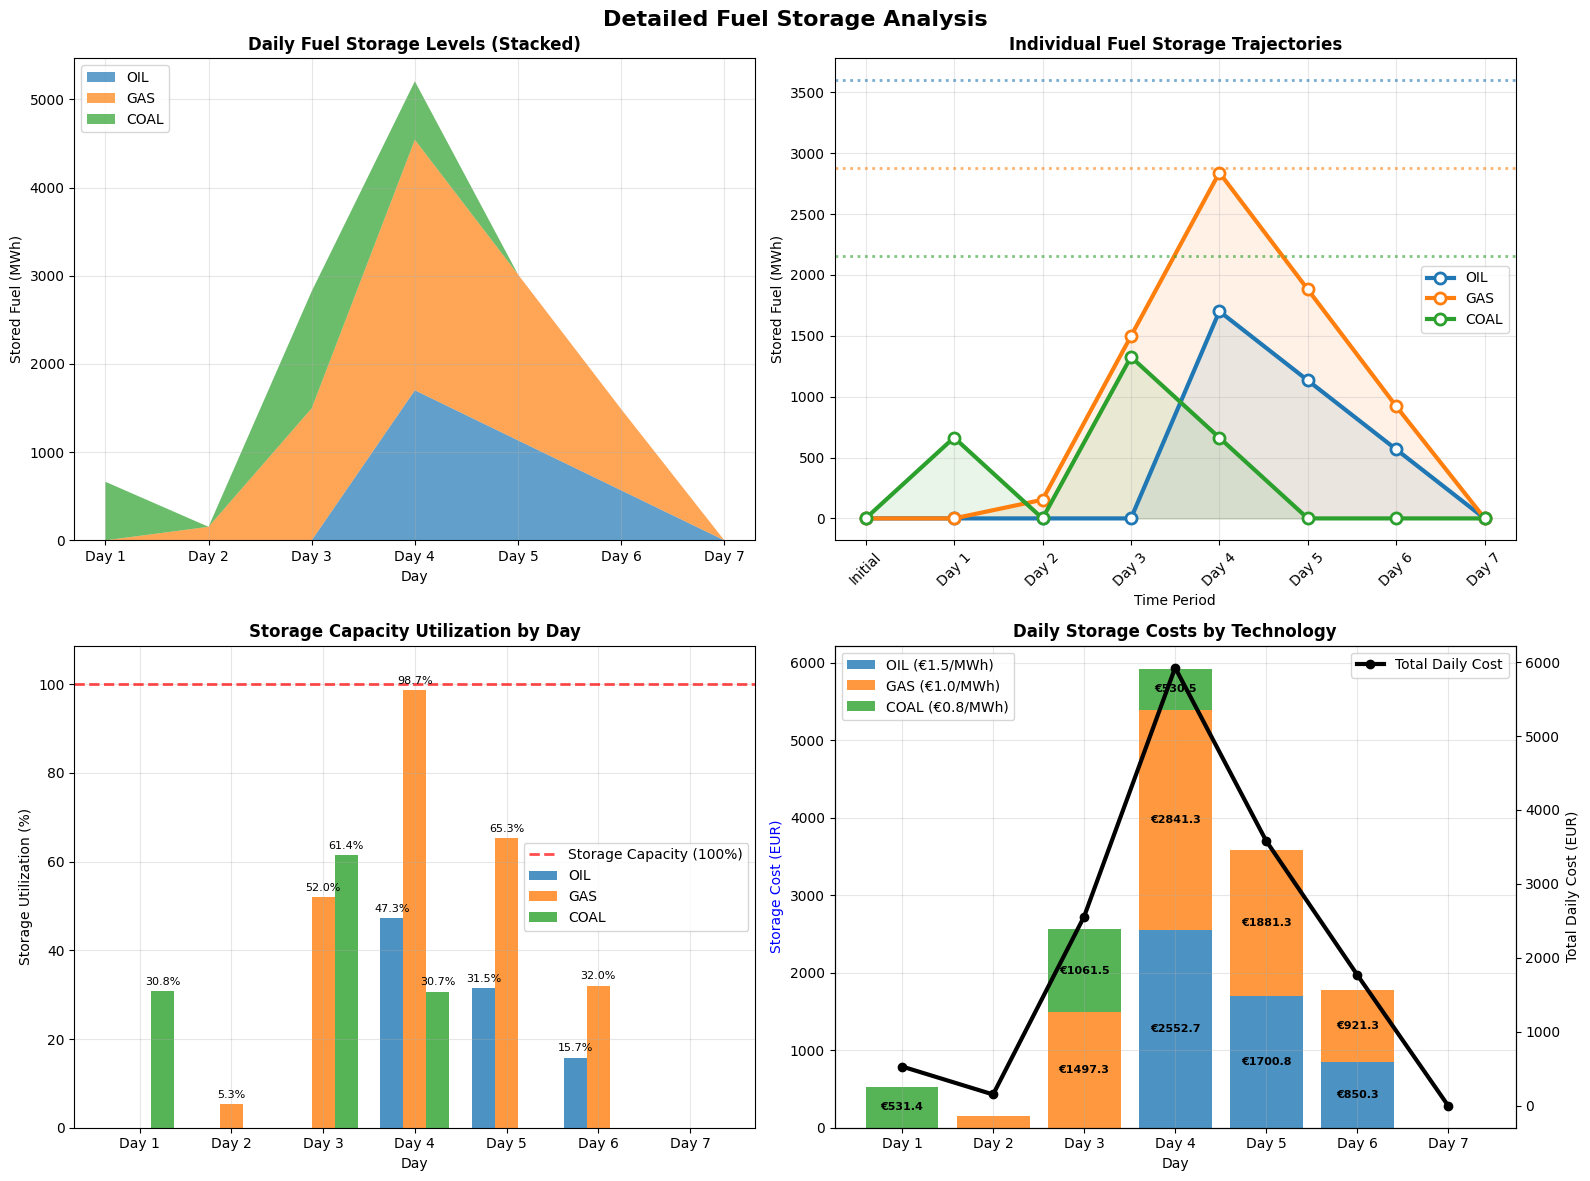


FUEL STORAGE ANALYSIS SUMMARY

Storage Capacity and Utilization:
  OIL:
    Storage Capacity: 3600.0 MWh
    Storage Rent: €1.5/MWh/day
    Average Storage Used: 486.1 MWh (13.5%)
    Maximum Storage Used: 1701.8 MWh (47.3%)
    Minimum Storage Used: 0.0 MWh
    Total Storage Cost: €5103.86
  GAS:
    Storage Capacity: 2880.0 MWh
    Storage Rent: €1.0/MWh/day
    Average Storage Used: 1042.1 MWh (36.2%)
    Maximum Storage Used: 2841.3 MWh (98.7%)
    Minimum Storage Used: 0.0 MWh
    Total Storage Cost: €7294.54
  COAL:
    Storage Capacity: 2160.0 MWh
    Storage Rent: €0.8/MWh/day
    Average Storage Used: 379.2 MWh (17.6%)
    Maximum Storage Used: 1326.9 MWh (61.4%)
    Minimum Storage Used: 0.0 MWh
    Total Storage Cost: €2123.43

Overall Storage Economics:
  Total Storage Investment (if fully utilized): €70056.00
  Actual Storage Costs: €14521.84
  Storage Cost Efficiency: 20.7%

Storage Strategy Insights:
  Most stable storage: COAL (std dev: 483.3 MWh)
  Most volatile stora

In [60]:
# -------------------------------------------------------
# Detailed Fuel Storage Analysis
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    # Create dedicated figure for fuel storage analysis
    fig_storage, axes_storage = plt.subplots(2, 2, figsize=(16, 12))
    fig_storage.suptitle('Detailed Fuel Storage Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    days_labels = [f'Day {d+1}' for d in DAYS]
    
    # 1. Daily Fuel Storage Levels (Stacked Area Chart)
    ax_s1 = axes_storage[0, 0]
    
    # Prepare data for stacked area chart
    storage_matrix = []
    for t in TECHS:
        storage_matrix.append(inventory_data[t])
    storage_matrix = np.array(storage_matrix)
    
    # Create stacked area chart
    ax_s1.stackplot(range(len(DAYS)), *storage_matrix, 
                   labels=[t.upper() for t in TECHS], 
                   colors=colors, alpha=0.7)
    

    
    ax_s1.set_title('Daily Fuel Storage Levels (Stacked)', fontweight='bold')
    ax_s1.set_xlabel('Day')
    ax_s1.set_ylabel('Stored Fuel (MWh)')
    ax_s1.set_xticks(range(len(DAYS)))
    ax_s1.set_xticklabels(days_labels)
    ax_s1.legend(loc='upper left')
    ax_s1.grid(True, alpha=0.3)
    
    # 2. Individual Storage Trajectories
    ax_s2 = axes_storage[0, 1]
    
    for i, tech in enumerate(TECHS):
        # Include initial inventory
        storage_trajectory = [init_inventory[tech]] + inventory_data[tech]
        days_with_init = ['Initial'] + days_labels
        
        # Plot storage trajectory
        line = ax_s2.plot(range(len(storage_trajectory)), storage_trajectory, 
                         'o-', linewidth=3, markersize=8, label=tech.upper(), 
                         color=colors[i], markerfacecolor='white', 
                         markeredgecolor=colors[i], markeredgewidth=2)
        
        # Add storage capacity as horizontal line
        ax_s2.axhline(y=storage_cap[tech], color=colors[i], 
                     linestyle=':', alpha=0.6, linewidth=2)
        
        # Fill area under curve
        ax_s2.fill_between(range(len(storage_trajectory)), 0, storage_trajectory, 
                          alpha=0.1, color=colors[i])
    
    ax_s2.set_title('Individual Fuel Storage Trajectories', fontweight='bold')
    ax_s2.set_xlabel('Time Period')
    ax_s2.set_ylabel('Stored Fuel (MWh)')
    ax_s2.set_xticks(range(len(days_with_init)))
    ax_s2.set_xticklabels(days_with_init, rotation=45)
    ax_s2.legend()
    ax_s2.grid(True, alpha=0.3)
    
    # 3. Storage Utilization Rate
    ax_s3 = axes_storage[1, 0]
    
    # Calculate storage utilization for each technology and day
    utilization_data = {}
    for t in TECHS:
        utilization_data[t] = [(inv / storage_cap[t]) * 100 for inv in inventory_data[t]]
    
    # Create grouped bar chart
    x = np.arange(len(DAYS))
    width = 0.25
    
    for i, tech in enumerate(TECHS):
        bars = ax_s3.bar(x + i*width, utilization_data[tech], width, 
                        label=tech.upper(), color=colors[i], alpha=0.8)
        
        # Add percentage labels on bars
        for bar, util in zip(bars, utilization_data[tech]):
            if util > 1:  # Only show labels for visible bars
                ax_s3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                          f'{util:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax_s3.axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.7, 
                 label='Storage Capacity (100%)')
    ax_s3.set_title('Storage Capacity Utilization by Day', fontweight='bold')
    ax_s3.set_xlabel('Day')
    ax_s3.set_ylabel('Storage Utilization (%)')
    ax_s3.set_xticks(x + width)
    ax_s3.set_xticklabels(days_labels)
    ax_s3.legend()
    ax_s3.grid(True, alpha=0.3)
    ax_s3.set_ylim(0, max(max(utilization_data[t]) for t in TECHS) + 10)
    
    # 4. Storage Cost Analysis
    ax_s4 = axes_storage[1, 1]
    
    # Calculate daily storage costs for each technology
    daily_storage_costs_by_tech = {}
    total_daily_storage_costs = []
    
    for t in TECHS:
        daily_storage_costs_by_tech[t] = []
        
    for d in DAYS:
        day_total_cost = 0
        for t in TECHS:
            daily_cost = storage_rent[t] * inventory_data[t][d]
            daily_storage_costs_by_tech[t].append(daily_cost)
            day_total_cost += daily_cost
        total_daily_storage_costs.append(day_total_cost)
    
    # Create stacked bar chart for storage costs
    bottom_costs = np.zeros(len(DAYS))
    
    for i, tech in enumerate(TECHS):
        costs = daily_storage_costs_by_tech[tech]
        bars = ax_s4.bar(days_labels, costs, bottom=bottom_costs,
                        label=f'{tech.upper()} (€{storage_rent[tech]}/MWh)', 
                        color=colors[i], alpha=0.8)
        
        # Add cost labels for significant values
        for j, (bar, cost) in enumerate(zip(bars, costs)):
            if cost > max(total_daily_storage_costs) * 0.05:  # Show labels > 5% of max
                ax_s4.text(bar.get_x() + bar.get_width()/2., 
                          bottom_costs[j] + cost/2,
                          f'€{cost:.1f}', ha='center', va='center', 
                          fontsize=8, fontweight='bold')
        
        bottom_costs += costs
    
    # Add total cost line
    ax_s4_twin = ax_s4.twinx()
    ax_s4_twin.plot(days_labels, total_daily_storage_costs, 'ko-', 
                   linewidth=3, markersize=6, label='Total Daily Cost')
    
    ax_s4.set_title('Daily Storage Costs by Technology', fontweight='bold')
    ax_s4.set_xlabel('Day')
    ax_s4.set_ylabel('Storage Cost (EUR)', color='blue')
    ax_s4_twin.set_ylabel('Total Daily Cost (EUR)', color='black')
    ax_s4.legend(loc='upper left')
    ax_s4_twin.legend(loc='upper right')
    ax_s4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Storage Summary Statistics
    # -------------------------------------------------------
    
    print("\n" + "="*80)
    print("FUEL STORAGE ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nStorage Capacity and Utilization:")
    for t in TECHS:
        max_storage_used = max(inventory_data[t])
        min_storage_used = min(inventory_data[t])
        avg_storage_used = np.mean(inventory_data[t])
        avg_utilization = (avg_storage_used / storage_cap[t]) * 100
        max_utilization = (max_storage_used / storage_cap[t]) * 100
        
        total_storage_cost = sum(storage_rent[t] * inv for inv in inventory_data[t])
        
        print(f"  {t.upper()}:")
        print(f"    Storage Capacity: {storage_cap[t]:.1f} MWh")
        print(f"    Storage Rent: €{storage_rent[t]:.1f}/MWh/day")
        print(f"    Average Storage Used: {avg_storage_used:.1f} MWh ({avg_utilization:.1f}%)")
        print(f"    Maximum Storage Used: {max_storage_used:.1f} MWh ({max_utilization:.1f}%)")
        print(f"    Minimum Storage Used: {min_storage_used:.1f} MWh")
        print(f"    Total Storage Cost: €{total_storage_cost:.2f}")
    
    print(f"\nOverall Storage Economics:")
    total_storage_investment = sum(storage_cap[t] * storage_rent[t] for t in TECHS) * num_days
    total_storage_cost_actual = sum(sum(daily_storage_costs_by_tech[t]) for t in TECHS)
    storage_cost_efficiency = (total_storage_cost_actual / total_storage_investment) * 100
    
    print(f"  Total Storage Investment (if fully utilized): €{total_storage_investment:.2f}")
    print(f"  Actual Storage Costs: €{total_storage_cost_actual:.2f}")
    print(f"  Storage Cost Efficiency: {storage_cost_efficiency:.1f}%")
    
    # Storage strategy insights
    print(f"\nStorage Strategy Insights:")
    
    # Find which technology has most consistent storage
    storage_volatility = {}
    for t in TECHS:
        storage_volatility[t] = np.std(inventory_data[t])
    
    most_stable = min(storage_volatility, key=storage_volatility.get)
    most_volatile = max(storage_volatility, key=storage_volatility.get)
    
    print(f"  Most stable storage: {most_stable.upper()} (std dev: {storage_volatility[most_stable]:.1f} MWh)")
    print(f"  Most volatile storage: {most_volatile.upper()} (std dev: {storage_volatility[most_volatile]:.1f} MWh)")
    
    # Storage trend analysis
    for t in TECHS:
        if len(inventory_data[t]) > 1:
            trend_slope = np.polyfit(range(len(inventory_data[t])), inventory_data[t], 1)[0]
            if trend_slope > 0.1:
                trend = "increasing"
            elif trend_slope < -0.1:
                trend = "decreasing"
            else:
                trend = "stable"
            print(f"  {t.upper()} storage trend: {trend} ({trend_slope:+.2f} MWh/day)")

else:
    print("No optimal solution found - cannot create storage analysis plots")

# Draft 3

## Data loading

In [61]:
import json
import random
import itertools
import random

random.seed(42)  # reproducible

# ---------------------------
# Basic structure
# ---------------------------
num_days = 7
num_hours = 24

TECHS = ["Oil", "Gas", "Coal"]
SUPPLIERS = {
    "Oil": ["Oil_Supplier_1", "Oil_Supplier_2", "Oil_Supplier_3"],
    "Gas": ["Gas_Supplier_1", "Gas_Supplier_2", "Gas_Supplier_3"],
    "Coal": ["Coal_Supplier_1", "Coal_Supplier_2", "Coal_Supplier_3"],
}

DAY_TYPES = ["Base", "Spike", "Severe"]
day_type_prob = {
    "Base": 0.5,    # Base day is most likely
    "Spike": 0.3,
    "Severe": 0.2   # Severe day is rare
}


num_scenarios = 30   # how many weekly scenarios you want

# We will generate random weekly patterns (7-day sequences of day types)
weekly_patterns = []
weekly_probs_raw = []

for scen_idx in range(num_scenarios):
    # Random pattern according to day_type_prob
    pattern = []
    for d in range(num_days):
        r = random.random()
        if r < day_type_prob["Base"]:
            pattern.append("Base")
        elif r < day_type_prob["Base"] + day_type_prob["Spike"]:
            pattern.append("Spike")
        else:
            pattern.append("Severe")
    
    weekly_patterns.append(pattern)

    # Raw probability = product of per-day probabilities
    prob = 1.0
    for dt in pattern:
        prob *= day_type_prob[dt]
    weekly_probs_raw.append(prob)

# Normalize probabilities
total_prob = sum(weekly_probs_raw)
weekly_probs = [p / total_prob for p in weekly_probs_raw]

# Build scenario names and dictionaries
SCENARIOS = [f"Week_{i}" for i in range(num_scenarios)]
scenario_prob = {SCENARIOS[i]: weekly_probs[i] for i in range(num_scenarios)}
scenario_day_types = {SCENARIOS[i]: weekly_patterns[i] for i in range(num_scenarios)}
# ---------------------------

# Hourly factors shape; peak around midday / evening.
hourly_factors = [
    0.55, 0.50, 0.48, 0.47, 0.48, 0.55,  # 0-5: low night
    0.65, 0.75, 0.80, 0.85, 0.90, 0.95,  # 6-11: ramp up
    1.00, 0.95, 0.90, 0.92, 1.00, 0.98,  # 12-17: high / evening peak
    0.90, 0.85, 0.80, 0.75, 0.70, 0.60   # 18-23: decline
]
assert len(hourly_factors) == num_hours
avg_hour_factors = sum(hourly_factors) / num_hours

# Max generation & storage (interpret as *hourly* max power)
max_gen = {"Oil": 50.0, "Gas": 40.0, "Coal": 30.0}

# Weekly demand target (approx)
weekly_demand_target = sum(max_gen[i] for i in max_gen) * avg_hour_factors * num_hours * num_days # MWh

storage_cap = {"Oil": max_gen["Oil"]*24*3, "Gas": max_gen["Gas"]*24*3, "Coal": max_gen["Coal"]*24*3}
storage_rent = {"Oil": 1.5, "Gas": 1.0, "Coal": 0.8}
init_inventory = {"Oil": 0.0, "Gas": 0.0, "Coal": 0.0}

# =====================================================
# Helper: volatile path generator (for prices)
# =====================================================
def generate_price_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Generate a volatile path with Gaussian noise and occasional *upward* spikes.
    Used for fuel and electricity prices.
    """
    prices = []
    level = base
    for d in range(days):
        # normal daily noise
        shock = random.gauss(0, daily_vol)
        level += shock

        # occasional upward spike
        if random.random() < spike_prob:
            spike = random.uniform(spike_low, spike_high)
            level += spike

        # avoid negative or too low prices
        level = max(5.0, level)
        prices.append(round(level, 1))
    return prices


# =====================================================
# 1) Fuel bids with volatility & spikes (daily auctions)
# =====================================================
fuel_bids = {}

tech_config = {
    "Coal": {
        "base_price": 65.0,  # €/MWh, cheapest
        "daily_vol": 3.0,
        "spike_prob": 0.05,
        "spike_low": 5.0,
        "spike_high": 5.0,
    },
    "Gas": {
        "base_price": 80.0,  # €/MWh, mid
        "daily_vol": 5.0,
        "spike_prob": 0.05,
        "spike_low": 10.0,
        "spike_high": 10.0,
    },
    "Oil": {
        "base_price": 100.0,  # €/MWh, most expensive
        "daily_vol": 4.0,
        "spike_prob": 0.05,
        "spike_low": 10.0,
        "spike_high": 10.0,
    },
}

for tech in TECHS:
    fuel_bids[tech] = {}
    cfg = tech_config[tech]
    for idx, supplier in enumerate(SUPPLIERS[tech], start=1):
        premium = (idx - 1) * 3.0
        base = cfg["base_price"] + premium

        prices_by_scen = {}

        # Base scenario: as before
        base_prices = generate_price_path(
            base=base,
            daily_vol=cfg["daily_vol"],
            spike_prob=cfg["spike_prob"],
            spike_low=cfg["spike_low"],
            spike_high=cfg["spike_high"],
            days=num_days
        )
        prices_by_scen["Base"] = base_prices

        # Spike scenario: base + moderate uplift on some days
        spike_prices = [
            p + 15.0 if d in [2, 3, 4] else p + 5.0
            for d, p in enumerate(base_prices)
        ]
        prices_by_scen["Spike"] = spike_prices

        # Severe scenario: strong uplift
        severe_prices = [
            p + 40.0 if d in [2, 3, 4] else p + 20.0
            for d, p in enumerate(base_prices)
        ]
        prices_by_scen["Severe"] = severe_prices

        # Same max quantity for all scenarios (simplification)
        base_qty = (10.0 * idx/60)*0.8*sum(max_gen[i] for i in max_gen)*num_hours*3
        max_qty = [base_qty for _ in range(num_days)]

        fuel_bids[tech][supplier] = {
            # IMPORTANT: now a dict: scen -> [prices per day]
            "price_EUR_per_MWh": prices_by_scen,
            "max_MWh_per_day": max_qty
        }



# =====================================================
# 3) Daily demand path with *downward* volatility
# =====================================================
def generate_downward_demand_path(base, daily_vol, spike_prob, spike_low, spike_high, days):
    """
    Volatile daily demand path mainly moving downward (e.g. due to RES, efficiency).
    - Negative bias in daily shocks
    - Occasional downward spikes
    - Then scaled so that weekly sum matches weekly_demand_target
    """
    demands = []
    level = base
    for d in range(days):
        # negative-biased shock
        shock = -abs(random.gauss(0, daily_vol))
        level += shock

        # occasional downward spike
        if random.random() < spike_prob:
            spike = -random.uniform(spike_low, spike_high)
            level += spike

        # avoid zero or negative demand
        level = max(0.1 * base, level)
        demands.append(level)

    # scale to match weekly target
    current_sum = sum(demands)
    scale = weekly_demand_target / current_sum
    demands = [round(d * scale, 3) for d in demands]
    return demands


base_daily = weekly_demand_target / num_days
daily_demand = generate_downward_demand_path(
    base=base_daily,
    daily_vol=1.0,
    spike_prob=0.20,
    spike_low=1.0,
    spike_high=3.0,
    days=num_days
)


# =====================================================
# Hourly demand factors and hourly demand (MWh)
# =====================================================


# Normalize so max factor = 1.0 (as per your “factor = 1” definition)
max_factor = max(hourly_factors)
hourly_factors = [round(x / max_factor, 3) for x in hourly_factors]
factor_sum = sum(hourly_factors)

# Compute hourly demand so that sum_h demand[d,h] = daily_demand[d]
hourly_demand = []
for d in range(num_days):
    day_row = []
    for h in range(num_hours):
        val = daily_demand[d] * (hourly_factors[h] / factor_sum)
        day_row.append(round(val, 4))
    hourly_demand.append(day_row)



# =====================================================
# 6) Revenue factors per technology (emission penalty)
# =====================================================
# Coal most penalized, gas least.
revenue_factor = {
    "Coal": 0.80,
    "Oil": 0.90,
    "Gas": 0.95
}


# =====================================================
# 7) Demand bid meta-info
# =====================================================
demand_bid = {
    "type": "inelastic_hourly_based_on_daily",
    "weekly_target_MWh": weekly_demand_target,
    "daily_MWh": daily_demand
}

load_deviation_penalty = {
    "under_generation": 250.0,  # EUR/MWh shortage penalty
    "over_generation": 150.0,   # EUR/MWh excess penalty  
    "description": "Grid balancing and stability penalties",
    "basis": "European TSO imbalance settlement mechanisms"
}

# =====================================================
# Build and save the full data structure
# =====================================================
data = {
    "time": {
        "num_days": num_days,
        "num_hours": num_hours
    },
    "demand": {
        "daily_MWh": daily_demand,
        "hourly_factor": hourly_factors,
        "hourly_MWh": hourly_demand  # shape [day][hour]
    },
    "technologies": TECHS,
    "max_gen_MWh_per_hour": max_gen,
    "storage_capacity_MWh": storage_cap,
    "storage_rent_EUR_per_MWh_per_day": storage_rent,
    "initial_inventory_MWh": init_inventory,
    "suppliers": SUPPLIERS,
    "fuel_bids": fuel_bids,
    "scenario_day_types": scenario_day_types,
    "scenarios": SCENARIOS,
    "scenario_prob": scenario_prob,
    "electricity_price_EUR_per_MWh_daily": daily_elec_price,
    "electricity_price_EUR_per_MWh_hourly": hourly_elec_price,  # shape [day][hour]
    "revenue_factor": revenue_factor,
    "demand_bid": demand_bid,
    "load_deviation_penalty": load_deviation_penalty
}

# Create data directory if it doesn't exist
data_folder = Path("data")
data_folder.mkdir(exist_ok=True)

# Write to data folder
with open(data_folder / "data_draft_3.json", "w") as f:
    json.dump(data, f, indent=2)

print("New data/data_draft_3.json with HOURLY demand and HOURLY electricity prices generated.")

New data/data_draft_3.json with HOURLY demand and HOURLY electricity prices generated.


## Optimization model

In [77]:
# -------------------------------------------------------
# Load data from JSON file
# -------------------------------------------------------
data_folder = Path("data")
data_file_path = data_folder / "data_draft_3.json"
data_file_path = data_file_path.resolve()
with open(data_file_path, "r") as f:
    data = json.load(f)

TECHS = data["technologies"]
num_days = data["time"]["num_days"]
num_hours = data["time"]["num_hours"]
DAYS = range(num_days)
HOURS = range(num_hours)

SCENARIOS = data["scenarios"]                # list of scenario names
scenario_prob = data["scenario_prob"]        # dict: scen -> probability
W = SCENARIOS
P = scenario_prob
scenario_day_types = data["scenario_day_types"]  # scen -> [day_type for each day]


SUPPLIERS = {t: data["suppliers"][t] for t in TECHS}

# Demand
daily_demand = data["demand"]["daily_MWh"]            # [day]
hourly_demand = data["demand"]["hourly_MWh"]          # [day][hour]

# Tech parameters
max_gen = data["max_gen_MWh_per_hour"]                # tech -> hourly max
storage_cap = data["storage_capacity_MWh"]
storage_rent = data["storage_rent_EUR_per_MWh_per_day"]
init_inventory = data["initial_inventory_MWh"]

# Market data
fuel_bids = data["fuel_bids"]                         # tech -> supplier -> {price[], max[]}
elec_price_hourly = data["electricity_price_EUR_per_MWh_hourly"]  # [day][hour]
revenue_factor = data["revenue_factor"]               # tech -> factor < 1

# Load deviation penalties
load_deviation_penalty = data["load_deviation_penalty"]
# Use default values if not present in data
severe_imbalance_threshold = data.get("severe_imbalance_threshold", 0.05)  # 5% threshold default
severe_penalty_multiplier = data.get("severe_penalty_multiplier", 2.0)    # 2x multiplier default

# Sanity checks
assert len(daily_demand) == num_days
assert len(elec_price_hourly) == num_days
for d in DAYS:
    assert len(hourly_demand[d]) == num_hours
    assert len(elec_price_hourly[d]) == num_hours

# -------------------------------------------------------
# Model
# -------------------------------------------------------
m = gp.Model("Weekly_Profit_Maximization_DailyFuel_HourlyPricesAndDemand")

# -------------------------------------------------------
# Decision variables
# -------------------------------------------------------


# Fuel purchases (MWh fuel) from supplier s for tech t on day d
purchase = m.addVars(
    ((t, s, d) for t in TECHS for s in SUPPLIERS[t] for d in DAYS),
    name="purchase",
    lb=0.0
)

# Hourly generation (MWh) by tech t, day d, hour h
generate = m.addVars(
    ((t, d, h, w) for t in TECHS for d in DAYS for h in HOURS for w in W),
    name="generate",
    lb=0.0
)

# Inventory (MWh) at end of day d for tech t
inventory = m.addVars(
    ((t, d, w) for t in TECHS for d in DAYS for w in W),
    name="inventory",
    lb=0.0
)

# Load deviation variables (MWh) for each day d, hour h
under_generation_w = m.addVars(
    ((d, h, w) for d in DAYS for h in HOURS for w in W),
    name="under_generation",
    lb=0.0
)

over_generation_w = m.addVars(
    ((d, h, w) for d in DAYS for h in HOURS for w in W),
    name="over_generation", 
    lb=0.0
)

eta = m.addVar(name="eta", lb=-GRB.INFINITY)  # instead of no lb
u = m.addVars(W, name="u", lb=0.0)         # one u[w] per scenario

# -------------------------------------------------------
# Objective: Maximize profit = hourly revenue - costs
# -------------------------------------------------------

profit = {}
loss = {}

for w in W:
    # Revenue (unchanged)
    rev_w = gp.quicksum(
        elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w]
        for t in TECHS for d in DAYS for h in HOURS
    )

    # Fuel cost in scenario w: uses day-type sequence
    fuel_cost_w = gp.LinExpr()
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                day_type = scenario_day_types[w][d]  # "Base" / "Spike" / "Severe"
                price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                fuel_cost_w += price_td * purchase[t, s, d]

    # Storage cost (unchanged)
    storage_cost_w = gp.quicksum(
        storage_rent[t] * inventory[t, d, w]
        for t in TECHS for d in DAYS
    )

    # Deviation penalties (unchanged)
    under_gen_penalty_cost_w = gp.quicksum(
        load_deviation_penalty["under_generation"] * under_generation_w[d, h, w]
        for d in DAYS for h in HOURS
    )
    over_gen_penalty_cost_w = gp.quicksum(
        load_deviation_penalty["over_generation"] * over_generation_w[d, h, w]
        for d in DAYS for h in HOURS
    )

    profit[w] = rev_w - fuel_cost_w - storage_cost_w - under_gen_penalty_cost_w - over_gen_penalty_cost_w
    loss[w] = -profit[w]

# CVaR parameters

alpha = 0.95          # confidence level
lambda_risk = 1 # you control how conservative the plan is

expected_profit = gp.quicksum(P[w] * profit[w] for w in W)

# CVaR linearization constraints: u[w] >= loss[w] - eta
for w in W:
    m.addConstr(u[w] >= loss[w] - eta, name=f"cvar_def_{w}")

cvar = eta + (1.0 / (1.0 - alpha)) * gp.quicksum(P[w] * u[w] for w in W)


m.setObjective(
    expected_profit - lambda_risk * cvar,
    GRB.MAXIMIZE
)

# -------------------------------------------------------
# Constraints
# -------------------------------------------------------

# 1) Inventory balance per tech & day:
#    inventory[t,d] = inventory[t,d-1] + sum_s purchase[t,s,d] - sum_h generate[t,d,h]
for t in TECHS:
    for w in W:
        for d in DAYS:
            if d == 0:
                prev_inv = init_inventory[t]
            else:
                prev_inv = inventory[t, d - 1, w]

            m.addConstr(
                inventory[t, d, w] ==
                prev_inv
                + gp.quicksum(purchase[t, s, d] for s in SUPPLIERS[t])
                - gp.quicksum(generate[t, d, h, w] for h in HOURS),
                name=f"inv_balance_{t}_day{d}_{w}"
            )


# 2) Hourly generation capacity:
#    generate[t,d,h] <= max_gen[t]
for t in TECHS:
    for w in W:
        for d in DAYS:
            for h in HOURS:
                m.addConstr(
                    generate[t, d, h, w] <= max_gen[t],
                    name=f"gen_cap_{t}_day{d}_hour{h}_{w}"
                )


# 3) Storage capacity:
#    inventory[t,d] <= storage_cap[t]
for t in TECHS:
    for w in W:
        for d in DAYS:
            m.addConstr(
                inventory[t, d, w] <= storage_cap[t],
                name=f"storage_cap_{t}_day{d}_{w}"
            )


# 4) Supplier daily offer limits:
#    purchase[t,s,d] <= max_offer[t,s,d]
for t in TECHS:
    for s in SUPPLIERS[t]:
        for d in DAYS:
            max_offer = fuel_bids[t][s]["max_MWh_per_day"][d]
            m.addConstr(
                purchase[t, s, d] <= max_offer,
                name=f"supplier_cap_{t}_{s}_day{d}"
            )


# 5) Load balance with deviation variables:
#    sum_t generate[t,d,h] + under_generation[d,h] - over_generation[d,h] = hourly_demand[d][h]
for w in W:
    for d in DAYS:
        for h in HOURS:
            m.addConstr(
                gp.quicksum(generate[t, d, h, w] for t in TECHS)
                + under_generation_w[d, h, w]
                - over_generation_w[d, h, w]
                == hourly_demand[d][h],
                name=f"demand_day{d}_hour{h}_{w}"
            )




     

# 6) End-of-week inventory must be zero (no terminal value for remaining fuel)
last_day = num_days - 1
for t in TECHS:
    for w in W:
        m.addConstr(
            inventory[t, last_day, w] == 0.0,
            name=f"end_inventory_zero_{t}_{w}"
        )


# -------------------------------------------------------
# Solve
# -------------------------------------------------------
m.optimize()

# -------------------------------------------------------
# Print solution
# -------------------------------------------------------
if m.status == GRB.OPTIMAL:
    print("=== Objective decomposition ===")
    print(f"Expected profit: {expected_profit.getValue():.2f} EUR")
    print(f"CVaR (alpha={alpha}): {cvar.getValue():.2f} EUR")

    print(f"\n=== Scenario Results ===")
    for w in W:
        profit_val = profit[w].getValue()
        probability_pct = P[w] * 100
        print(f"Scenario {w}: profit = {profit_val:.2f} EUR (probability = {probability_pct:.1f}%)")

    # Purchases are shared across scenarios:
    print("\n=== Purchases (same for all scenarios) ===")
    for t in TECHS:
        for s in SUPPLIERS[t]:
            for d in DAYS:
                val = purchase[t, s, d].X
                if val > 1e-6:
                    print(f"Q[{t},{s},day{d}] = {val:.2f} MWh")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21603 rows, 25924 columns and 87063 nonzeros
Model fingerprint: 0xc9abd159
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 4e+03]
Presolve removed 16143 rows and 935 columns
Presolve time: 0.17s
Presolved: 5460 rows, 24989 columns, 68575 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.113e+04
 Factor NZ  : 8.811e+04 (roughly 9 MB of memory)
 Factor Ops : 8.955e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    

=== Generating Comprehensive Stochastic Optimization Visualizations ===
Selected 5 most relevant scenarios for detailed plotting:
  Scenario Week_1: Best Case - Profit: 68678 EUR (p=12.1%)
  Scenario Week_14: Worst Case - Profit: -138052 EUR (p=0.7%)
  Scenario Week_4: 2nd Worst Case - Profit: -130423 EUR (p=0.3%)
  Scenario Week_6: High Prob (12.1%) - Profit: 64306 EUR (p=12.1%)
  Scenario Week_22: High Prob (12.1%) - Profit: 64613 EUR (p=12.1%)
Selection priority: Extreme cases (worst/best), high probability, operational risks


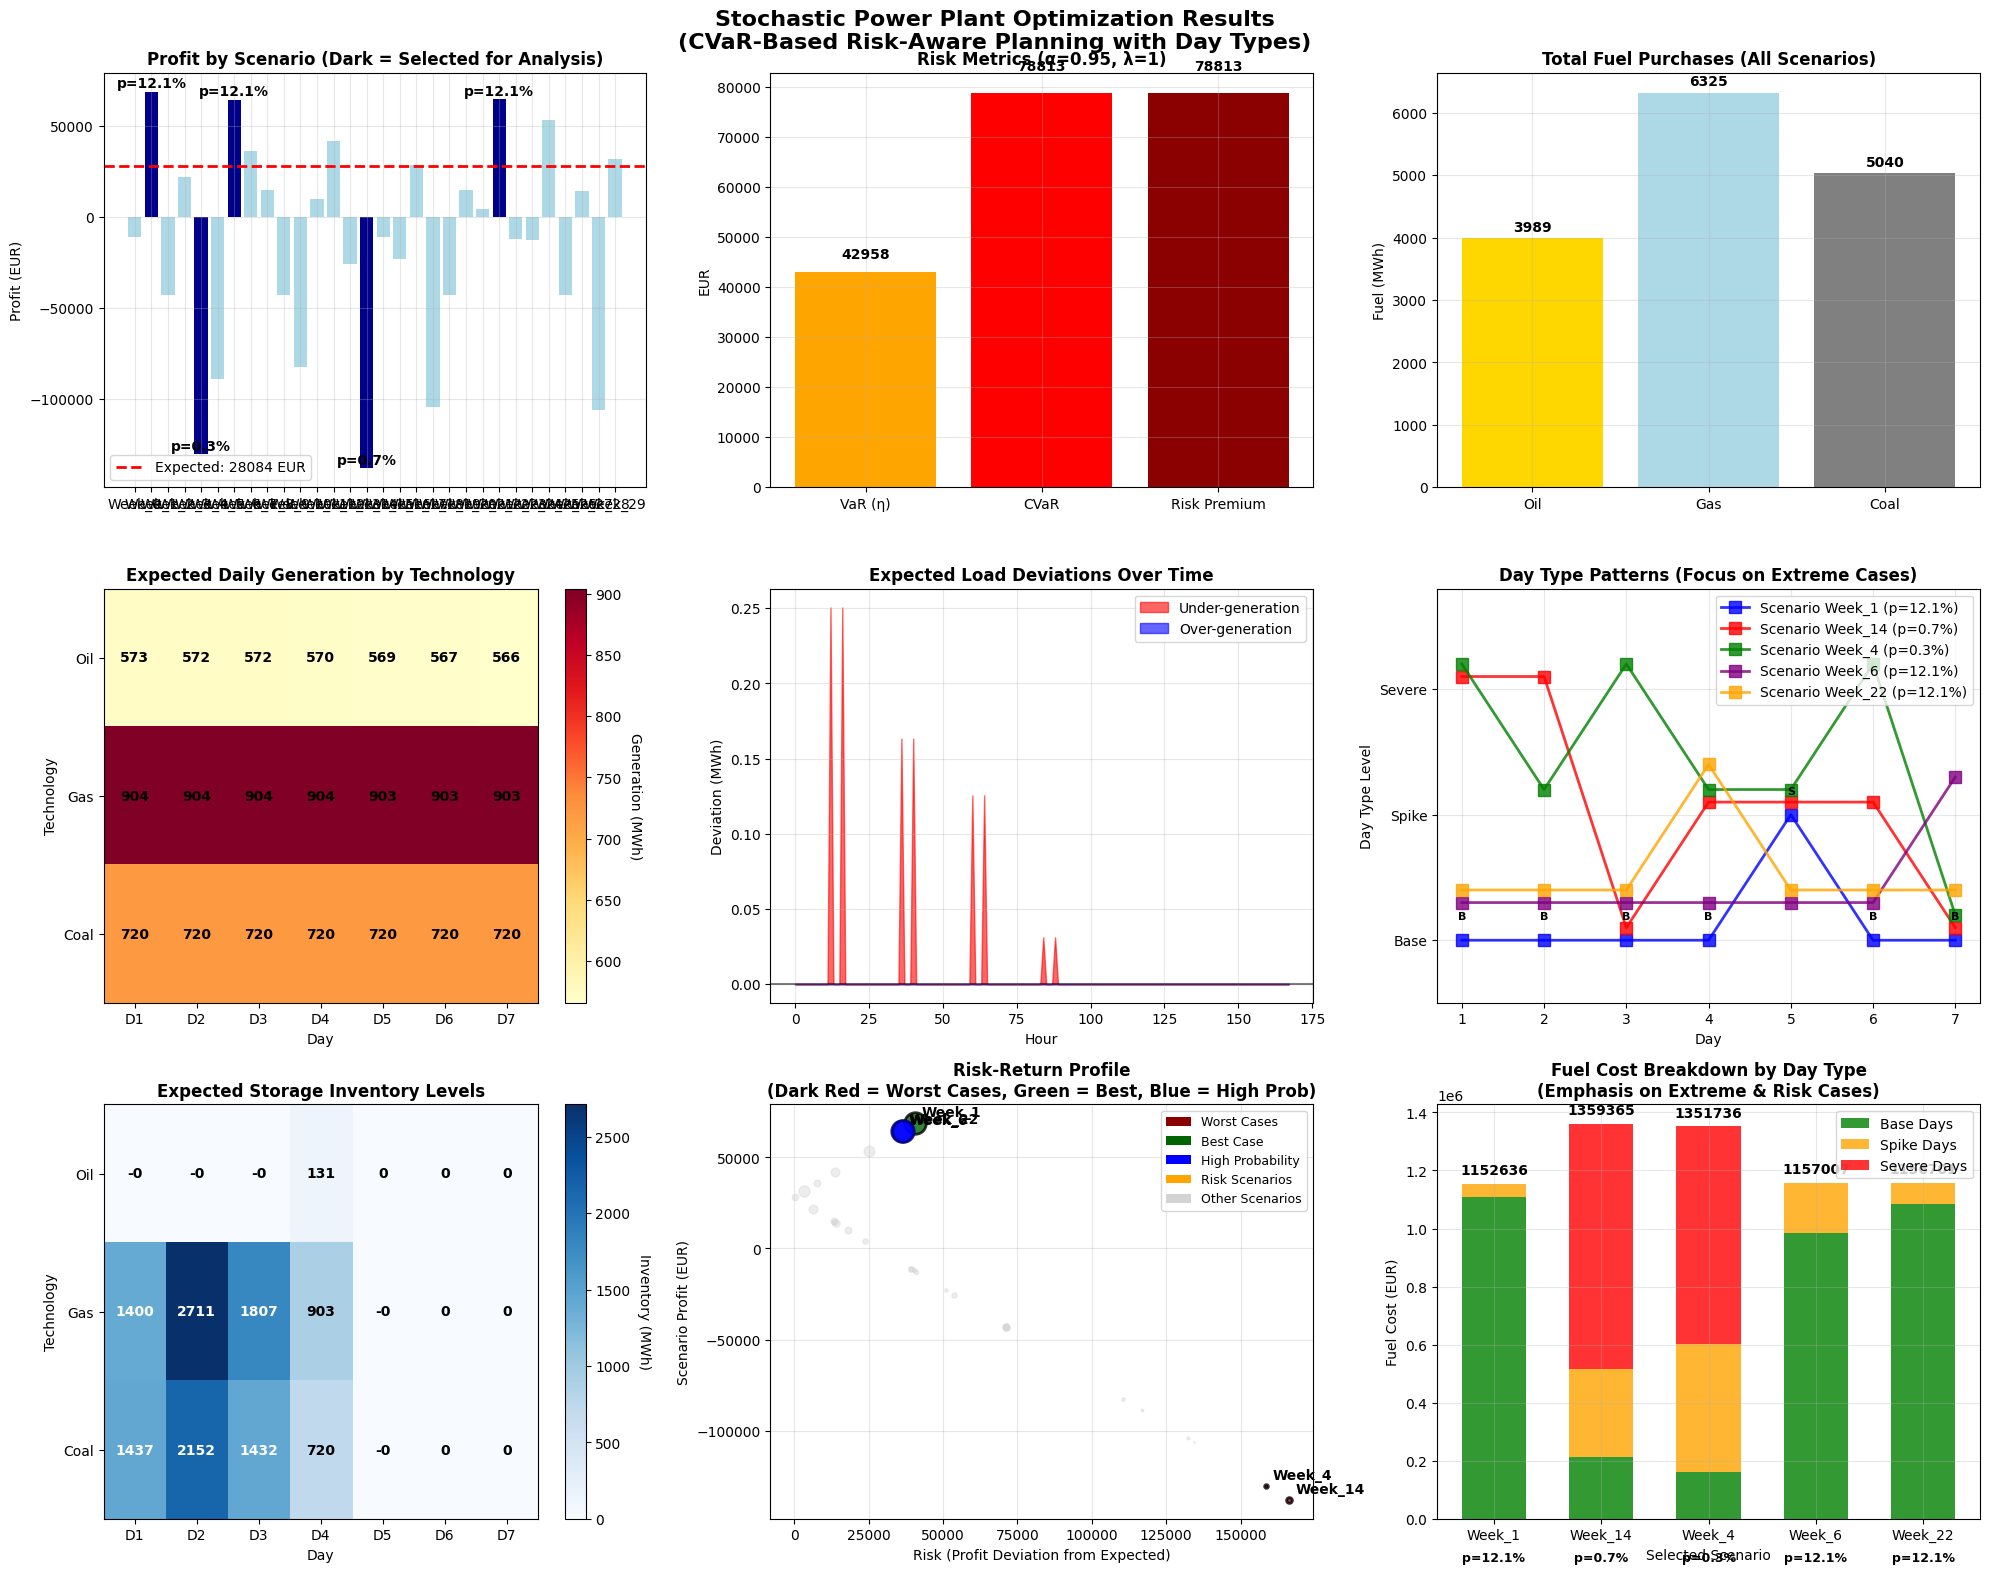


=== Stochastic Optimization Summary ===
Expected Profit: 28083.84 EUR
CVaR (α=0.95): 78813.06 EUR
Risk Premium (λ×CVaR): 78813.06 EUR
Risk-Adjusted Objective: -50729.22 EUR

=== Selected Scenario Analysis ===
Scenario Week_1: Profit = 68677.82 EUR (Δ = +40593.98 EUR, p = 12.1%) [B:6, S:1, Sv:0]
Scenario Week_14: Profit = -138051.68 EUR (Δ = -166135.52 EUR, p = 0.7%) [B:2, S:3, Sv:2]
Scenario Week_4: Profit = -130422.74 EUR (Δ = -158506.59 EUR, p = 0.3%) [B:1, S:3, Sv:3]
Scenario Week_6: Profit = 64306.32 EUR (Δ = +36222.47 EUR, p = 12.1%) [B:6, S:1, Sv:0]
Scenario Week_22: Profit = 64612.74 EUR (Δ = +36528.90 EUR, p = 12.1%) [B:6, S:1, Sv:0]

=== All Scenario Analysis ===
Scenario Week_0: Profit = -11208.31 EUR (Δ = -39292.15 EUR, p = 1.7%) [B:3, S:3, Sv:1]
Scenario Week_1: Profit = 68677.82 EUR (Δ = +40593.98 EUR, p = 12.1%) [B:6, S:1, Sv:0]
Scenario Week_2: Profit = -42957.88 EUR (Δ = -71041.72 EUR, p = 0.7%) [B:2, S:3, Sv:2]
Scenario Week_3: Profit = 21716.50 EUR (Δ = -6367.34 EUR,

In [78]:
# -------------------------------------------------------
# Comprehensive Visualization of Stochastic Optimization Results
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    print("=== Generating Comprehensive Stochastic Optimization Visualizations ===")
    
    # Extract results for each scenario
    scenario_results = {}
    
    # Get profit values from optimization variables (avoid name conflict with float variable)
    profit_values = {}
    for w in W:
        # Extract profit from optimization model variables
        rev_w = sum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w].X
            for t in TECHS for d in DAYS for h in HOURS
        )
        
        fuel_cost_w = 0
        for t in TECHS:
            for s in SUPPLIERS[t]:
                for d in DAYS:
                    day_type = scenario_day_types[w][d]
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    fuel_cost_w += price_td * purchase[t, s, d].X
        
        storage_cost_w = sum(
            storage_rent[t] * inventory[t, d, w].X
            for t in TECHS for d in DAYS
        )
        
        under_gen_penalty_cost_w = sum(
            load_deviation_penalty["under_generation"] * under_generation_w[d, h, w].X
            for d in DAYS for h in HOURS
        )
        over_gen_penalty_cost_w = sum(
            load_deviation_penalty["over_generation"] * over_generation_w[d, h, w].X
            for d in DAYS for h in HOURS
        )
        
        profit_values[w] = rev_w - fuel_cost_w - storage_cost_w - under_gen_penalty_cost_w - over_gen_penalty_cost_w
    
    for w in W:
        scenario_results[w] = {
            'generation': {},
            'inventory': {},
            'under_gen': [],
            'over_gen': [],
            'deviation_costs': [],
            'profit': profit_values[w]
        }
        
        # Extract generation data by tech and time
        for t in TECHS:
            scenario_results[w]['generation'][t] = []
            scenario_results[w]['inventory'][t] = []
            for d in DAYS:
                for h in HOURS:
                    scenario_results[w]['generation'][t].append(generate[t, d, h, w].X)
                scenario_results[w]['inventory'][t].append(inventory[t, d, w].X)
        
        # Extract deviation data
        for d in DAYS:
            for h in HOURS:
                under_val = under_generation_w[d, h, w].X
                over_val = over_generation_w[d, h, w].X
                scenario_results[w]['under_gen'].append(under_val)
                scenario_results[w]['over_gen'].append(over_val)
                
                # Calculate deviation costs
                under_cost = load_deviation_penalty["under_generation"] * under_val
                over_cost = load_deviation_penalty["over_generation"] * over_val
                scenario_results[w]['deviation_costs'].append(under_cost + over_cost)
    
    # Purchase data (shared across scenarios)
    purchase_results = {}
    for t in TECHS:
        purchase_results[t] = {}
        for s in SUPPLIERS[t]:
            purchase_results[t][s] = []
            for d in DAYS:
                purchase_results[t][s].append(purchase[t, s, d].X)
    
    # -------------------------------------------------------
    # INTELLIGENT SCENARIO SELECTION FOR PLOTTING
    # -------------------------------------------------------
    
    # Get all scenario profits and probabilities
    all_scenario_info = [(w, scenario_results[w]['profit'], P[w]) for w in W]
    
    # Select relevant scenarios for plotting with emphasis on extreme cases
    relevant_scenarios = []
    selection_reasons = {}
    
    # 1. Always include extreme profit cases first (most important for risk analysis)
    profits_list = [(w, scenario_results[w]['profit']) for w in W]
    profits_sorted = sorted(profits_list, key=lambda x: x[1])
    
    # Best case scenario
    best_profit_scenario = profits_sorted[-1][0]
    relevant_scenarios.append(best_profit_scenario)
    selection_reasons[best_profit_scenario] = "Best Case"
    
    # Worst case scenario
    worst_profit_scenario = profits_sorted[0][0]
    if worst_profit_scenario not in relevant_scenarios:
        relevant_scenarios.append(worst_profit_scenario)
        selection_reasons[worst_profit_scenario] = "Worst Case"
    
    # Second worst case if significantly different
    if len(profits_sorted) > 2:
        second_worst_scenario = profits_sorted[1][0]
        second_worst_profit = profits_sorted[1][1]
        worst_profit = profits_sorted[0][1]
        # Include if profit difference is significant (>5% of worst case loss)
        if (second_worst_profit - worst_profit) > abs(worst_profit * 0.05) and len(relevant_scenarios) < 4:
            if second_worst_scenario not in relevant_scenarios:
                relevant_scenarios.append(second_worst_scenario)
                selection_reasons[second_worst_scenario] = "2nd Worst Case"
    
    # 2. Add highest probability scenarios that aren't already included
    all_scenario_info.sort(key=lambda x: x[2], reverse=True)  # Sort by probability
    high_prob_added = 0
    for w, profit, prob in all_scenario_info:
        if w not in relevant_scenarios and high_prob_added < 2 and len(relevant_scenarios) < 5:
            relevant_scenarios.append(w)
            selection_reasons[w] = f"High Prob ({prob*100:.1f}%)"
            high_prob_added += 1
    
    # 3. Add scenarios with extreme day type patterns for risk diversity
    if len(relevant_scenarios) < 5:
        # Find scenario with most severe days (highest operational risk)
        most_severe_scenario = max(W, key=lambda w: scenario_day_types[w].count('Severe'))
        if most_severe_scenario not in relevant_scenarios:
            relevant_scenarios.append(most_severe_scenario)
            severe_count = scenario_day_types[most_severe_scenario].count('Severe')
            selection_reasons[most_severe_scenario] = f"Most Severe Days ({severe_count})"
    
    if len(relevant_scenarios) < 5:
        # Find scenario with most spike days (price volatility risk)
        most_spike_scenario = max(W, key=lambda w: scenario_day_types[w].count('Spike'))
        if most_spike_scenario not in relevant_scenarios:
            relevant_scenarios.append(most_spike_scenario)
            spike_count = scenario_day_types[most_spike_scenario].count('Spike')
            selection_reasons[most_spike_scenario] = f"Most Spike Days ({spike_count})"
    
    # 4. If still room, add median profit scenario for comparison
    if len(relevant_scenarios) < 5 and len(profits_sorted) > 2:
        median_idx = len(profits_sorted) // 2
        median_scenario = profits_sorted[median_idx][0]
        if median_scenario not in relevant_scenarios:
            relevant_scenarios.append(median_scenario)
            selection_reasons[median_scenario] = "Median Case"
    
    # Limit to maximum 6 scenarios for clarity (increased to show more extreme cases)
    relevant_scenarios = relevant_scenarios[:6]
    
    print(f"Selected {len(relevant_scenarios)} most relevant scenarios for detailed plotting:")
    for w in relevant_scenarios:
        profit_val = scenario_results[w]['profit']
        prob_pct = P[w] * 100
        print(f"  Scenario {w}: {selection_reasons[w]} - Profit: {profit_val:.0f} EUR (p={prob_pct:.1f}%)")
    print("Selection priority: Extreme cases (worst/best), high probability, operational risks")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    fig.suptitle('Stochastic Power Plant Optimization Results\n(CVaR-Based Risk-Aware Planning with Day Types)', fontsize=16, fontweight='bold')
    
    # 1. Scenario Profit Comparison (Top Left) - Show ALL scenarios but highlight relevant ones
    ax = axes[0, 0]
    scenarios = list(W)
    profits_by_scenario = [scenario_results[w]['profit'] for w in scenarios]
    probabilities = [P[w] for w in scenarios]
    
    # Color bars based on relevance
    colors = ['darkblue' if w in relevant_scenarios else 'lightblue' for w in scenarios]
    bars = ax.bar(scenarios, profits_by_scenario, color=colors)
    
    # Add probability labels on bars
    for i, (bar, prob, w) in enumerate(zip(bars, probabilities, scenarios)):
        height = bar.get_height()
        if w in relevant_scenarios:  # Only label relevant scenarios to avoid clutter
            ax.text(bar.get_x() + bar.get_width()/2., height + max(profits_by_scenario)*0.01,
                    f'p={prob*100:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title('Profit by Scenario (Dark = Selected for Analysis)', fontweight='bold')
    ax.set_ylabel('Profit (EUR)')
    ax.grid(True, alpha=0.3)
    
    # Expected profit line
    expected_profit_val = sum(P[w] * scenario_results[w]['profit'] for w in W)
    ax.axhline(y=expected_profit_val, color='red', linestyle='--', linewidth=2, 
               label=f'Expected: {expected_profit_val:.0f} EUR')
    ax.legend()
    
    # 2. CVaR Risk Metrics (Top Center)
    ax = axes[0, 1]
    eta_val = eta.X
    cvar_val = cvar.getValue()
    
    risk_metrics = ['VaR (η)', 'CVaR', 'Risk Premium']
    risk_values = [eta_val, cvar_val, lambda_risk * cvar_val]
    colors = ['orange', 'red', 'darkred']
    
    bars = ax.bar(risk_metrics, risk_values, color=colors)
    ax.set_title(f'Risk Metrics (α={alpha}, λ={lambda_risk})', fontweight='bold')
    ax.set_ylabel('EUR')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, risk_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + abs(height)*0.05,
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Shared Fuel Purchases (Top Right)
    ax = axes[0, 2]
    purchase_by_tech = {}
    for t in TECHS:
        total_purchase = 0
        for s in SUPPLIERS[t]:
            for d in DAYS:
                total_purchase += purchase[t, s, d].X
        purchase_by_tech[t] = total_purchase
    
    techs = list(purchase_by_tech.keys())
    purchases = list(purchase_by_tech.values())
    colors = ['gold', 'lightblue', 'gray'][:len(techs)]
    
    bars = ax.bar(techs, purchases, color=colors)
    ax.set_title('Total Fuel Purchases (All Scenarios)', fontweight='bold')
    ax.set_ylabel('Fuel (MWh)')
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, purchases):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(purchases)*0.01,
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Generation Heatmap by Scenario (Middle Left)
    ax = axes[1, 0]
    
    # Create average generation matrix across all scenarios
    avg_gen_matrix = np.zeros((len(TECHS), num_days))
    for i, t in enumerate(TECHS):
        for d in DAYS:
            daily_gen = 0
            for w in W:
                for h in HOURS:
                    daily_gen += generate[t, d, h, w].X * P[w]
            avg_gen_matrix[i, d] = daily_gen
    
    im = ax.imshow(avg_gen_matrix, cmap='YlOrRd', aspect='auto')
    ax.set_title('Expected Daily Generation by Technology', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Technology')
    ax.set_yticks(range(len(TECHS)))
    ax.set_yticklabels(TECHS)
    ax.set_xticks(range(num_days))
    ax.set_xticklabels([f'D{d+1}' for d in range(num_days)])
    
    # Add text annotations
    for i in range(len(TECHS)):
        for d in range(num_days):
            text = ax.text(d, i, f'{avg_gen_matrix[i, d]:.0f}',
                          ha="center", va="center", color="black", fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Generation (MWh)', rotation=270, labelpad=15)
    
    # 5. Load Deviation Analysis (Middle Center) - Focus on relevant scenarios
    ax = axes[1, 1]
    
    # Calculate expected deviations
    time_hours = list(range(num_days * num_hours))
    expected_under = []
    expected_over = []
    
    idx = 0
    for d in DAYS:
        for h in HOURS:
            exp_under = sum(P[w] * under_generation_w[d, h, w].X for w in W)
            exp_over = sum(P[w] * over_generation_w[d, h, w].X for w in W)
            expected_under.append(exp_under)
            expected_over.append(exp_over)
            idx += 1
    
    ax.fill_between(time_hours, expected_under, alpha=0.6, color='red', label='Under-generation')
    ax.fill_between(time_hours, [-x for x in expected_over], alpha=0.6, color='blue', label='Over-generation')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax.set_title('Expected Load Deviations Over Time', fontweight='bold')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Deviation (MWh)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Day Type Analysis by Scenario (Middle Right) - Only relevant scenarios
    ax = axes[1, 2]
    
    # Show day type patterns for relevant scenarios only
    day_type_colors = {'Base': 'green', 'Spike': 'orange', 'Severe': 'red'}
    day_type_values = {'Base': 1, 'Spike': 2, 'Severe': 3}
    plot_colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, w in enumerate(relevant_scenarios):
        day_types_sequence = scenario_day_types[w]
        day_values = [day_type_values[dt] for dt in day_types_sequence]
        
        ax.plot(range(1, num_days+1), [val + i*0.1 for val in day_values], 
               marker='s', markersize=8, linewidth=2, color=plot_colors[i % len(plot_colors)],
               label=f'Scenario {w} (p={P[w]*100:.1f}%)', alpha=0.8)
        
        # Add day type labels for first scenario only to avoid clutter
        if i == 0:
            for d, dt in enumerate(day_types_sequence):
                ax.text(d+1, day_values[d] + i*0.1 + 0.15, dt[:1], 
                       ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    ax.set_title(f'Day Type Patterns (Focus on Extreme Cases)', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Day Type Level')
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['Base', 'Spike', 'Severe'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 3.8)
    
    # 7. Storage Utilization Heatmap (Bottom Left)
    ax = axes[2, 0]
    
    # Expected inventory levels
    expected_inventory = np.zeros((len(TECHS), num_days))
    for i, t in enumerate(TECHS):
        for d in DAYS:
            expected_inventory[i, d] = sum(P[w] * inventory[t, d, w].X for w in W)
    
    im = ax.imshow(expected_inventory, cmap='Blues', aspect='auto')
    ax.set_title('Expected Storage Inventory Levels', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Technology')
    ax.set_yticks(range(len(TECHS)))
    ax.set_yticklabels(TECHS)
    ax.set_xticks(range(num_days))
    ax.set_xticklabels([f'D{d+1}' for d in range(num_days)])
    
    # Add text annotations
    for i in range(len(TECHS)):
        for d in range(num_days):
            text = ax.text(d, i, f'{expected_inventory[i, d]:.0f}',
                          ha="center", va="center", 
                          color="white" if expected_inventory[i, d] > np.max(expected_inventory)/2 else "black",
                          fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Inventory (MWh)', rotation=270, labelpad=15)
    
    # 8. Risk-Return Scatter (Bottom Center) - Highlight relevant scenarios
    ax = axes[2, 1]
    
    scenario_profits = [scenario_results[w]['profit'] for w in W]
    scenario_risks = []
    
    for w in W:
        # Calculate scenario-specific risk as deviation from expected profit
        risk = abs(scenario_results[w]['profit'] - expected_profit_val)
        scenario_risks.append(risk)
    
    # Plot all scenarios with different styles, emphasizing extreme cases
    for i, w in enumerate(W):
        if w in relevant_scenarios:
            # Color code based on selection reason
            if 'Worst' in selection_reasons[w] or 'worst' in selection_reasons[w].lower():
                color = 'darkred'  # Emphasize worst cases in dark red
                edge_color = 'black'
                marker_size = P[w]*2500  # Larger for visibility
            elif 'Best' in selection_reasons[w]:
                color = 'darkgreen'  # Best case in green
                edge_color = 'black'
                marker_size = P[w]*2000
            elif 'High Prob' in selection_reasons[w]:
                color = 'blue'  # High probability in blue
                edge_color = 'navy'
                marker_size = P[w]*2000
            else:
                color = 'orange'  # Other selected scenarios
                edge_color = 'darkorange'
                marker_size = P[w]*1800
            
            ax.scatter(scenario_risks[i], scenario_profits[i], 
                      s=marker_size, color=color, alpha=0.8, edgecolors=edge_color, linewidth=2)
            ax.annotate(f'{w}', (scenario_risks[i], scenario_profits[i]), 
                       xytext=(5, 5), textcoords='offset points', fontweight='bold', fontsize=10)
        else:
            # Show other scenarios as smaller points
            ax.scatter(scenario_risks[i], scenario_profits[i], 
                      s=P[w]*800, color='lightgray', alpha=0.4)
    
    ax.set_xlabel('Risk (Profit Deviation from Expected)')
    ax.set_ylabel('Scenario Profit (EUR)')
    ax.set_title('Risk-Return Profile\n(Dark Red = Worst Cases, Green = Best, Blue = High Prob)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add legend for color coding
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='darkred', label='Worst Cases'),
        Patch(facecolor='darkgreen', label='Best Case'),
        Patch(facecolor='blue', label='High Probability'),
        Patch(facecolor='orange', label='Risk Scenarios'),
        Patch(facecolor='lightgray', label='Other Scenarios')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # 9. Fuel Cost Analysis by Day Type (Bottom Right) - Only relevant scenarios
    ax = axes[2, 2]
    
    # Calculate fuel costs by day type for relevant scenarios only
    scenario_fuel_costs_by_type = {}
    day_types = ['Base', 'Spike', 'Severe']
    
    for w in relevant_scenarios:
        scenario_fuel_costs_by_type[w] = {'Base': 0, 'Spike': 0, 'Severe': 0}
        
        for d in DAYS:
            day_type = scenario_day_types[w][d]
            daily_fuel_cost = 0
            
            for t in TECHS:
                for s in SUPPLIERS[t]:
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    daily_fuel_cost += price_td * purchase[t, s, d].X
            
            scenario_fuel_costs_by_type[w][day_type] += daily_fuel_cost
    
    # Create stacked bar chart for relevant scenarios only
    x_pos = np.arange(len(relevant_scenarios))
    width = 0.6
    
    base_costs = [scenario_fuel_costs_by_type[w]['Base'] for w in relevant_scenarios]
    spike_costs = [scenario_fuel_costs_by_type[w]['Spike'] for w in relevant_scenarios]
    severe_costs = [scenario_fuel_costs_by_type[w]['Severe'] for w in relevant_scenarios]
    
    ax.bar(x_pos, base_costs, width, label='Base Days', color='green', alpha=0.8)
    ax.bar(x_pos, spike_costs, width, bottom=base_costs, label='Spike Days', color='orange', alpha=0.8)
    ax.bar(x_pos, severe_costs, width, 
           bottom=[base_costs[i] + spike_costs[i] for i in range(len(relevant_scenarios))], 
           label='Severe Days', color='red', alpha=0.8)
    
    # Add total cost labels and probabilities
    for i, w in enumerate(relevant_scenarios):
        total_cost = base_costs[i] + spike_costs[i] + severe_costs[i]
        ax.text(i, total_cost + max(base_costs)*0.02, f'{total_cost:.0f}', 
               ha='center', va='bottom', fontweight='bold')
        # Add probability below x-axis
        ax.text(i, -max(base_costs)*0.1, f'p={P[w]*100:.1f}%', 
               ha='center', va='top', fontweight='bold', fontsize=9)
    
    ax.set_xlabel('Selected Scenario')
    ax.set_ylabel('Fuel Cost (EUR)')
    ax.set_title(f'Fuel Cost Breakdown by Day Type\n(Emphasis on Extreme & Risk Cases)', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{w}' for w in relevant_scenarios])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary Statistics
    print(f"\n=== Stochastic Optimization Summary ===")
    print(f"Expected Profit: {expected_profit_val:.2f} EUR")
    print(f"CVaR (α={alpha}): {cvar_val:.2f} EUR")
    print(f"Risk Premium (λ×CVaR): {lambda_risk * cvar_val:.2f} EUR")
    print(f"Risk-Adjusted Objective: {expected_profit_val - lambda_risk * cvar_val:.2f} EUR")
    
    print(f"\n=== Selected Scenario Analysis ===")
    for w in relevant_scenarios:
        profit_val = scenario_results[w]['profit']
        deviation = profit_val - expected_profit_val
        day_types_w = scenario_day_types[w]
        day_type_counts = {dt: day_types_w.count(dt) for dt in ['Base', 'Spike', 'Severe']}
        day_type_summary = f"B:{day_type_counts['Base']}, S:{day_type_counts['Spike']}, Sv:{day_type_counts['Severe']}"
        print(f"Scenario {w}: Profit = {profit_val:.2f} EUR (Δ = {deviation:+.2f} EUR, p = {P[w]*100:.1f}%) [{day_type_summary}]")
    
    print(f"\n=== All Scenario Analysis ===")
    for w in W:
        profit_val = scenario_results[w]['profit']
        deviation = profit_val - expected_profit_val
        day_types_w = scenario_day_types[w]
        day_type_counts = {dt: day_types_w.count(dt) for dt in ['Base', 'Spike', 'Severe']}
        day_type_summary = f"B:{day_type_counts['Base']}, S:{day_type_counts['Spike']}, Sv:{day_type_counts['Severe']}"
        print(f"Scenario {w}: Profit = {profit_val:.2f} EUR (Δ = {deviation:+.2f} EUR, p = {P[w]*100:.1f}%) [{day_type_summary}]")
    
    # Risk metrics
    profit_std = np.sqrt(sum(P[w] * (scenario_results[w]['profit'] - expected_profit_val)**2 for w in W))
    print(f"\nProfit Standard Deviation: {profit_std:.2f} EUR")
    print(f"Coefficient of Variation: {profit_std/expected_profit_val:.3f}")
    
    worst_case = min(scenario_results[w]['profit'] for w in W)
    best_case = max(scenario_results[w]['profit'] for w in W)
    print(f"Profit Range: [{worst_case:.0f}, {best_case:.0f}] EUR")
    
    # Day type analysis
    print(f"\n=== Day Type Impact Analysis ===")
    overall_day_type_counts = {'Base': 0, 'Spike': 0, 'Severe': 0}
    for w in W:
        day_types_w = scenario_day_types[w]
        for dt in day_types_w:
            overall_day_type_counts[dt] += P[w]
    
    print(f"Expected Day Type Distribution:")
    for dt in ['Base', 'Spike', 'Severe']:
        print(f"  {dt}: {overall_day_type_counts[dt]:.1f} days expected")
    
else:
    print(f"Optimization failed with status: {m.status}")

=== Identifying 6 Key Scenario Types ===
Selected Scenarios for Analysis:
  Best Case   : Week_1 - Profit: 68678 EUR (p=12.1%) [B:6, S:1, Sv:0]
  Worst Case  : Week_14 - Profit: -138052 EUR (p=0.7%) [B:2, S:3, Sv:2]
  High Prob   : Week_1 - Profit: 68678 EUR (p=12.1%) [B:6, S:1, Sv:0]
  Median      : Week_0 - Profit: -11208 EUR (p=1.7%) [B:3, S:3, Sv:1]
  Most Severe : Week_28 - Profit: -106233 EUR (p=0.1%) [B:1, S:1, Sv:5]
  Most Spike  : Week_5 - Profit: -88837 EUR (p=0.4%) [B:1, S:4, Sv:2]


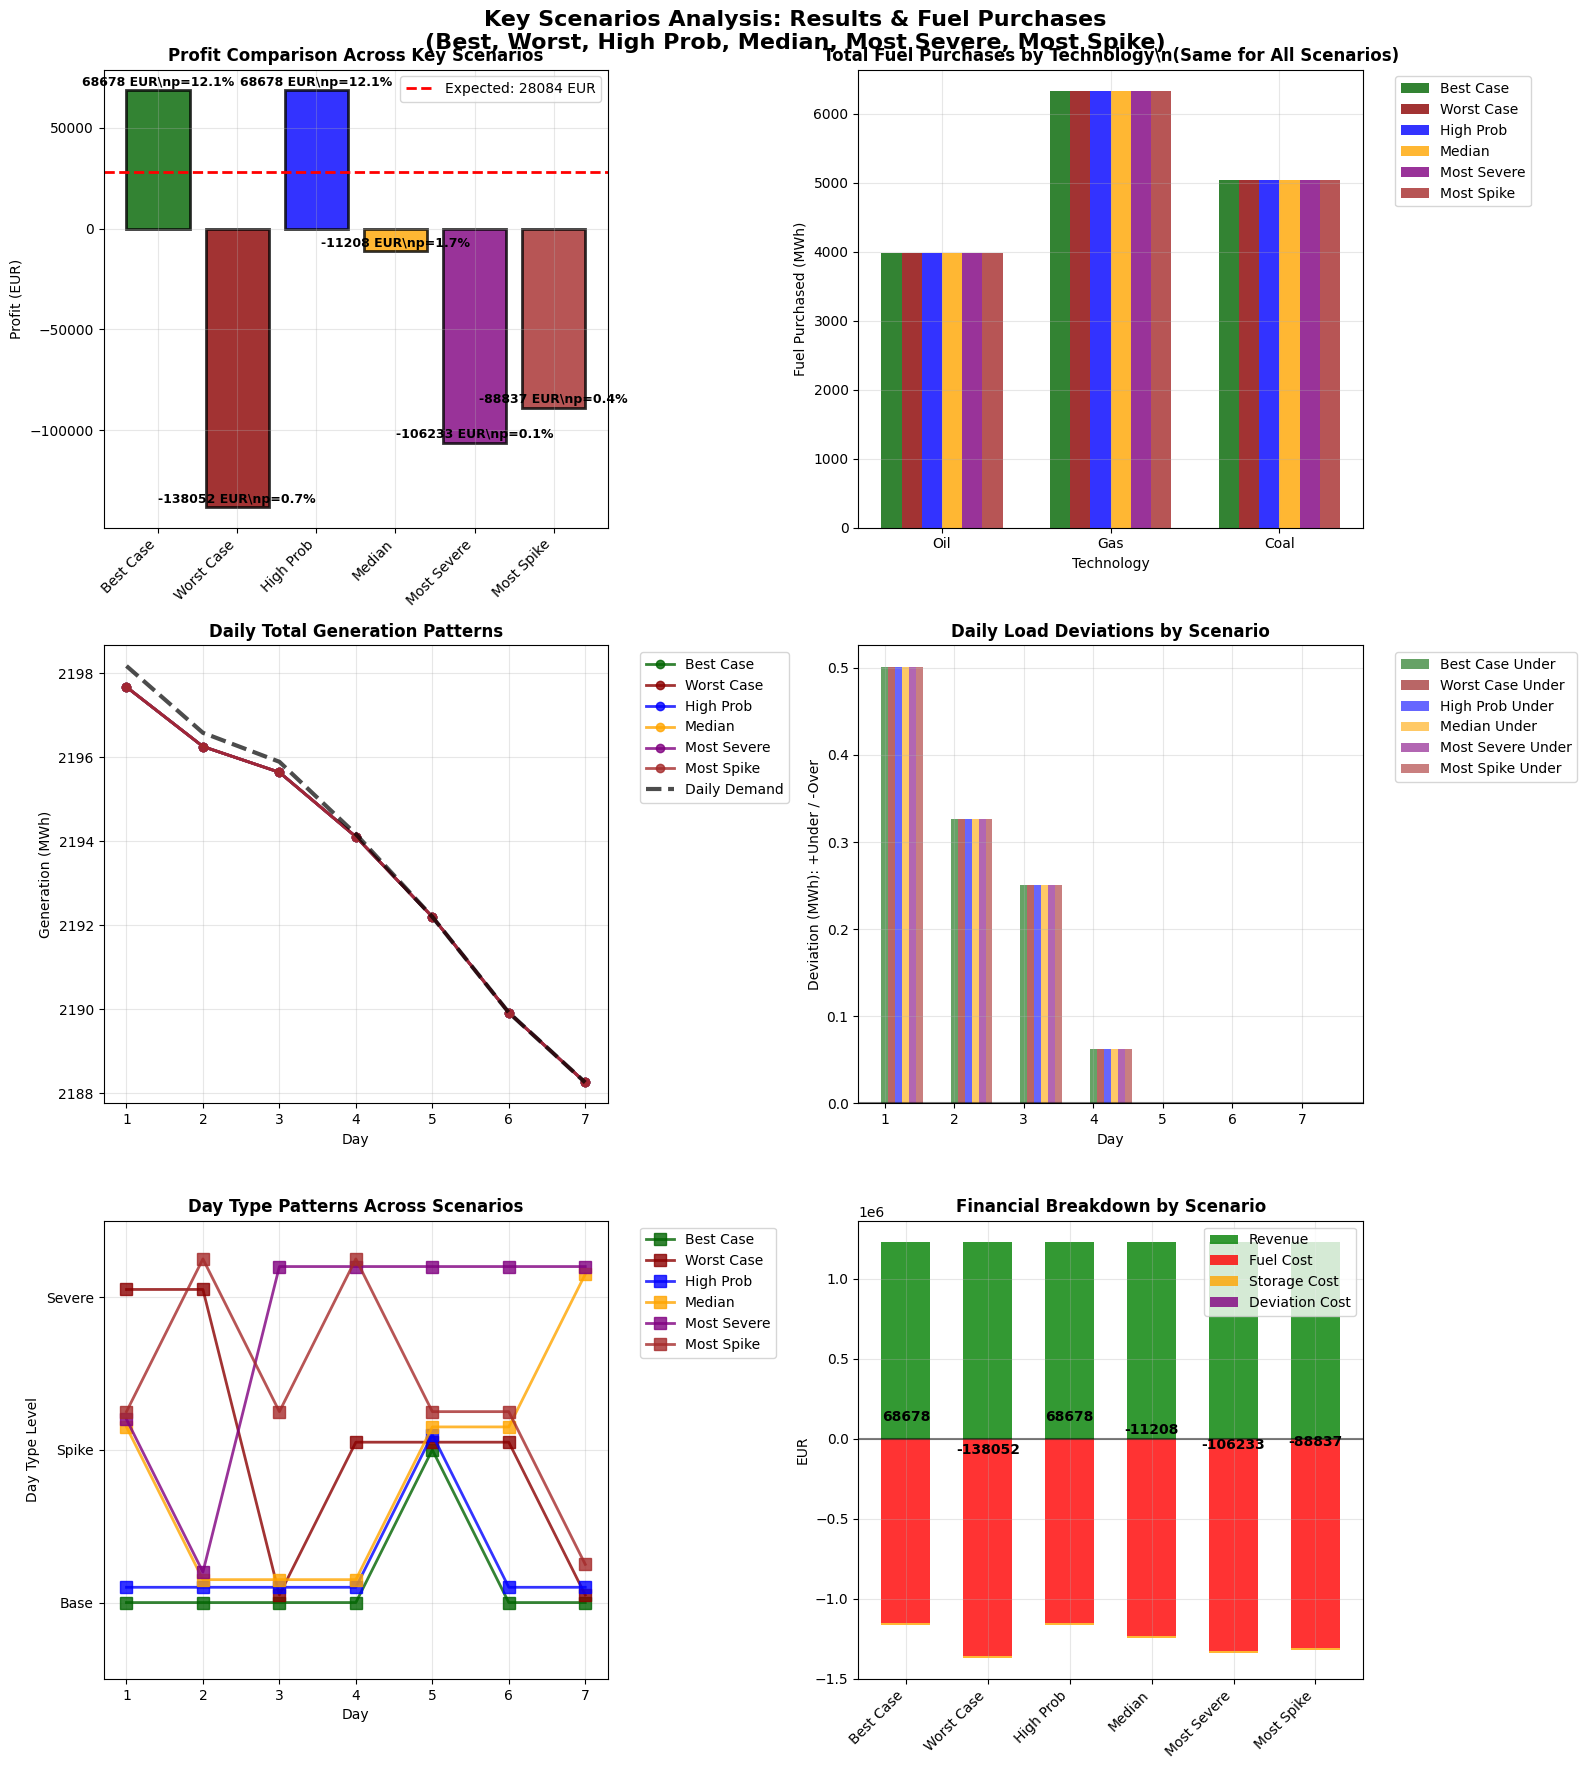

\n=== Detailed Analysis of 6 Key Scenarios ===
\nBest Case - Scenario Week_1:
  Profit: 68677.82 EUR
  Probability: 12.1%
  Day Types: Base=6, Spike=1, Severe=0
  Revenue: 1233210 EUR
  Fuel Cost: 1152636 EUR
  Storage Cost: 11611 EUR
  Deviation Cost: 285 EUR
  Total Under-generation: 1.1 MWh
  Total Over-generation: 0.0 MWh
\nWorst Case - Scenario Week_14:
  Profit: -138051.68 EUR
  Probability: 0.7%
  Day Types: Base=2, Spike=3, Severe=2
  Revenue: 1233210 EUR
  Fuel Cost: 1359365 EUR
  Storage Cost: 11611 EUR
  Deviation Cost: 285 EUR
  Total Under-generation: 1.1 MWh
  Total Over-generation: 0.0 MWh
\nHigh Prob - Scenario Week_1:
  Profit: 68677.82 EUR
  Probability: 12.1%
  Day Types: Base=6, Spike=1, Severe=0
  Revenue: 1233210 EUR
  Fuel Cost: 1152636 EUR
  Storage Cost: 11611 EUR
  Deviation Cost: 285 EUR
  Total Under-generation: 1.1 MWh
  Total Over-generation: 0.0 MWh
\nMedian - Scenario Week_0:
  Profit: -11208.31 EUR
  Probability: 1.7%
  Day Types: Base=3, Spike=3, Sever

In [79]:
# -------------------------------------------------------
# Focused Analysis: 6 Key Scenario Types
# Results and Fuel Purchases Visualization
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    print("=== Identifying 6 Key Scenario Types ===")
    
    # 1. Best Case (highest profit)
    profits_list = [(w, profit_values[w]) for w in W]
    best_scenario = max(profits_list, key=lambda x: x[1])[0]
    
    # 2. Worst Case (lowest profit)  
    worst_scenario = min(profits_list, key=lambda x: x[1])[0]
    
    # 3. High Probability (highest probability)
    high_prob_scenario = max(W, key=lambda w: P[w])
    
    # 4. Median Case (middle profit)
    profits_sorted = sorted(profits_list, key=lambda x: x[1])
    median_idx = len(profits_sorted) // 2
    median_scenario = profits_sorted[median_idx][0]
    
    # 5. Most Severe Days (scenario with most severe day types)
    most_severe_scenario = max(W, key=lambda w: scenario_day_types[w].count('Severe'))
    
    # 6. Most Spike Days (scenario with most spike day types)
    most_spike_scenario = max(W, key=lambda w: scenario_day_types[w].count('Spike'))
    
    # Selected scenarios for analysis
    focus_scenarios = {
        'Best Case': best_scenario,
        'Worst Case': worst_scenario, 
        'High Prob': high_prob_scenario,
        'Median': median_scenario,
        'Most Severe': most_severe_scenario,
        'Most Spike': most_spike_scenario
    }
    
    print("Selected Scenarios for Analysis:")
    for label, w in focus_scenarios.items():
        profit_val = profit_values[w]
        prob_pct = P[w] * 100
        day_types_w = scenario_day_types[w]
        severe_count = day_types_w.count('Severe')
        spike_count = day_types_w.count('Spike')
        base_count = day_types_w.count('Base')
        print(f"  {label:12}: {w} - Profit: {profit_val:.0f} EUR (p={prob_pct:.1f}%) [B:{base_count}, S:{spike_count}, Sv:{severe_count}]")
    
    # Create comprehensive visualization for these 6 scenarios
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Key Scenarios Analysis: Results & Fuel Purchases\n(Best, Worst, High Prob, Median, Most Severe, Most Spike)', 
                 fontsize=16, fontweight='bold')
    
    # Color scheme for scenarios
    scenario_colors = {
        'Best Case': 'darkgreen',
        'Worst Case': 'darkred',
        'High Prob': 'blue', 
        'Median': 'orange',
        'Most Severe': 'purple',
        'Most Spike': 'brown'
    }
    
    # -------------------------------------------------------
    # 1. Profit Comparison (Top Left)
    # -------------------------------------------------------
    ax = axes[0, 0]
    labels = list(focus_scenarios.keys())
    scenarios = list(focus_scenarios.values())
    profits = [profit_values[w] for w in scenarios]
    colors = [scenario_colors[label] for label in labels]
    
    bars = ax.bar(labels, profits, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add profit and probability labels on bars
    for i, (bar, w, label) in enumerate(zip(bars, scenarios, labels)):
        height = bar.get_height()
        prob_pct = P[w] * 100
        ax.text(bar.get_x() + bar.get_width()/2., height + max(profits)*0.01,
                f'{height:.0f} EUR\\np={prob_pct:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    ax.set_title('Profit Comparison Across Key Scenarios', fontweight='bold')
    ax.set_ylabel('Profit (EUR)')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Expected profit line
    ax.axhline(y=expected_profit_val, color='red', linestyle='--', linewidth=2, 
               label=f'Expected: {expected_profit_val:.0f} EUR')
    ax.legend()
    
    # -------------------------------------------------------
    # 2. Fuel Purchases by Technology (Top Right)
    # -------------------------------------------------------
    ax = axes[0, 1]
    
    # Calculate total fuel purchases by technology for each scenario
    fuel_purchases_by_scenario = {}
    for label, w in focus_scenarios.items():
        fuel_purchases_by_scenario[label] = {}
        for t in TECHS:
            total_purchase_t = 0
            for s in SUPPLIERS[t]:
                for d in DAYS:
                    total_purchase_t += purchase[t, s, d].X
            fuel_purchases_by_scenario[label][t] = total_purchase_t
    
    # Create grouped bar chart
    x_pos = np.arange(len(TECHS))
    width = 0.12  # Width of bars
    
    for i, (label, w) in enumerate(focus_scenarios.items()):
        purchases = [fuel_purchases_by_scenario[label][t] for t in TECHS]
        offset = (i - 2.5) * width  # Center the groups
        ax.bar(x_pos + offset, purchases, width, label=label, 
               color=scenario_colors[label], alpha=0.8)
    
    ax.set_title('Total Fuel Purchases by Technology\\n(Same for All Scenarios)', fontweight='bold')
    ax.set_xlabel('Technology')
    ax.set_ylabel('Fuel Purchased (MWh)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(TECHS)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 3. Daily Generation Patterns (Middle Left)
    # -------------------------------------------------------
    ax = axes[1, 0]
    
    # Calculate daily generation for each scenario
    for i, (label, w) in enumerate(focus_scenarios.items()):
        daily_gen_total = []
        for d in DAYS:
            daily_total = 0
            for t in TECHS:
                for h in HOURS:
                    daily_total += generate[t, d, h, w].X
            daily_gen_total.append(daily_total)
        
        ax.plot(range(1, num_days+1), daily_gen_total, 
               marker='o', linewidth=2, markersize=6, 
               label=label, color=scenario_colors[label], alpha=0.8)
    
    # Add demand line for reference
    daily_total_demand = [sum(hourly_demand[d]) for d in DAYS]
    ax.plot(range(1, num_days+1), daily_total_demand, 
           'k--', linewidth=3, label='Daily Demand', alpha=0.7)
    
    ax.set_title('Daily Total Generation Patterns', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Generation (MWh)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 4. Load Deviations by Scenario (Middle Right)
    # -------------------------------------------------------
    ax = axes[1, 1]
    
    # Calculate total daily deviations for each scenario
    for i, (label, w) in enumerate(focus_scenarios.items()):
        daily_under_dev = []
        daily_over_dev = []
        
        for d in DAYS:
            daily_under = sum(under_generation_w[d, h, w].X for h in HOURS)
            daily_over = sum(over_generation_w[d, h, w].X for h in HOURS) 
            daily_under_dev.append(daily_under)
            daily_over_dev.append(-daily_over)  # Negative for plotting
        
        # Plot under-generation as positive values
        if any(val > 0.01 for val in daily_under_dev):
            ax.bar(np.arange(1, num_days+1) + i*0.1, daily_under_dev, 
                  width=0.1, label=f'{label} Under', 
                  color=scenario_colors[label], alpha=0.6)
        
        # Plot over-generation as negative values  
        if any(val < -0.01 for val in daily_over_dev):
            ax.bar(np.arange(1, num_days+1) + i*0.1, daily_over_dev,
                  width=0.1, label=f'{label} Over',
                  color=scenario_colors[label], alpha=0.3)
    
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax.set_title('Daily Load Deviations by Scenario', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Deviation (MWh): +Under / -Over')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 5. Day Type Patterns (Bottom Left)
    # -------------------------------------------------------
    ax = axes[2, 0]
    
    # Show day type patterns for each scenario
    day_type_values = {'Base': 1, 'Spike': 2, 'Severe': 3}
    
    for i, (label, w) in enumerate(focus_scenarios.items()):
        day_types_sequence = scenario_day_types[w]
        day_values = [day_type_values[dt] for dt in day_types_sequence]
        
        ax.plot(range(1, num_days+1), [val + i*0.05 for val in day_values], 
               marker='s', markersize=8, linewidth=2, 
               label=label, color=scenario_colors[label], alpha=0.8)
    
    ax.set_title('Day Type Patterns Across Scenarios', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Day Type Level')
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['Base', 'Spike', 'Severe'])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 3.5)
    
    # -------------------------------------------------------
    # 6. Financial Breakdown by Scenario (Bottom Right)
    # -------------------------------------------------------
    ax = axes[2, 1]
    
    # Calculate cost components for each scenario
    financial_data = {}
    for label, w in focus_scenarios.items():
        # Revenue
        revenue = sum(
            elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w].X
            for t in TECHS for d in DAYS for h in HOURS
        )
        
        # Fuel cost 
        fuel_cost = 0
        for t in TECHS:
            for s in SUPPLIERS[t]:
                for d in DAYS:
                    day_type = scenario_day_types[w][d]
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    fuel_cost += price_td * purchase[t, s, d].X
        
        # Storage cost
        storage_cost = sum(
            storage_rent[t] * inventory[t, d, w].X
            for t in TECHS for d in DAYS
        )
        
        # Deviation penalties
        deviation_cost = (
            sum(load_deviation_penalty["under_generation"] * under_generation_w[d, h, w].X
                for d in DAYS for h in HOURS) +
            sum(load_deviation_penalty["over_generation"] * over_generation_w[d, h, w].X  
                for d in DAYS for h in HOURS)
        )
        
        financial_data[label] = {
            'Revenue': revenue,
            'Fuel Cost': -fuel_cost,
            'Storage Cost': -storage_cost, 
            'Deviation Cost': -deviation_cost,
            'Profit': profit_values[w]
        }
    
    # Create stacked bar chart
    x_pos = np.arange(len(focus_scenarios))
    width = 0.6
    
    revenues = [financial_data[label]['Revenue'] for label in labels]
    fuel_costs = [financial_data[label]['Fuel Cost'] for label in labels]
    storage_costs = [financial_data[label]['Storage Cost'] for label in labels]
    deviation_costs = [financial_data[label]['Deviation Cost'] for label in labels]
    
    # Plot components
    ax.bar(x_pos, revenues, width, label='Revenue', color='green', alpha=0.8)
    ax.bar(x_pos, fuel_costs, width, bottom=[0]*len(labels), 
           label='Fuel Cost', color='red', alpha=0.8)
    
    # Stack storage costs on fuel costs
    bottom_storage = fuel_costs
    ax.bar(x_pos, storage_costs, width, bottom=bottom_storage,
           label='Storage Cost', color='orange', alpha=0.8)
    
    # Stack deviation costs on previous costs
    bottom_deviation = [fuel_costs[i] + storage_costs[i] for i in range(len(labels))]
    ax.bar(x_pos, deviation_costs, width, bottom=bottom_deviation,
           label='Deviation Cost', color='purple', alpha=0.8)
    
    # Add profit labels
    for i, label in enumerate(labels):
        profit_val = financial_data[label]['Profit']
        ax.text(i, profit_val + max(revenues)*0.02, f'{profit_val:.0f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_title('Financial Breakdown by Scenario', fontweight='bold')
    ax.set_ylabel('EUR')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Summary Statistics for Key Scenarios
    # -------------------------------------------------------
    print(f"\\n=== Detailed Analysis of 6 Key Scenarios ===")
    
    for label, w in focus_scenarios.items():
        print(f"\\n{label} - Scenario {w}:")
        print(f"  Profit: {profit_values[w]:.2f} EUR")
        print(f"  Probability: {P[w]*100:.1f}%")
        
        # Day type breakdown
        day_types_w = scenario_day_types[w]
        day_counts = {dt: day_types_w.count(dt) for dt in ['Base', 'Spike', 'Severe']}
        print(f"  Day Types: Base={day_counts['Base']}, Spike={day_counts['Spike']}, Severe={day_counts['Severe']}")
        
        # Financial components
        fin_data = financial_data[label]
        print(f"  Revenue: {fin_data['Revenue']:.0f} EUR")
        print(f"  Fuel Cost: {-fin_data['Fuel Cost']:.0f} EUR") 
        print(f"  Storage Cost: {-fin_data['Storage Cost']:.0f} EUR")
        print(f"  Deviation Cost: {-fin_data['Deviation Cost']:.0f} EUR")
        
        # Total deviations
        total_under = sum(under_generation_w[d, h, w].X for d in DAYS for h in HOURS)
        total_over = sum(over_generation_w[d, h, w].X for d in DAYS for h in HOURS)
        print(f"  Total Under-generation: {total_under:.1f} MWh")
        print(f"  Total Over-generation: {total_over:.1f} MWh")
    
    print(f"\\n=== Fuel Purchase Summary (Same Across All Scenarios) ===")
    for t in TECHS:
        total_tech_purchase = 0
        for s in SUPPLIERS[t]:
            for d in DAYS:
                purchase_val = purchase[t, s, d].X
                if purchase_val > 0.01:
                    print(f"  {t}-{s}-Day{d+1}: {purchase_val:.1f} MWh")
                total_tech_purchase += purchase_val
        print(f"  Total {t}: {total_tech_purchase:.1f} MWh")
                
else:
    print(f"Optimization failed with status: {m.status}")

=== Weekly Economic Performance & Operational Analysis ===


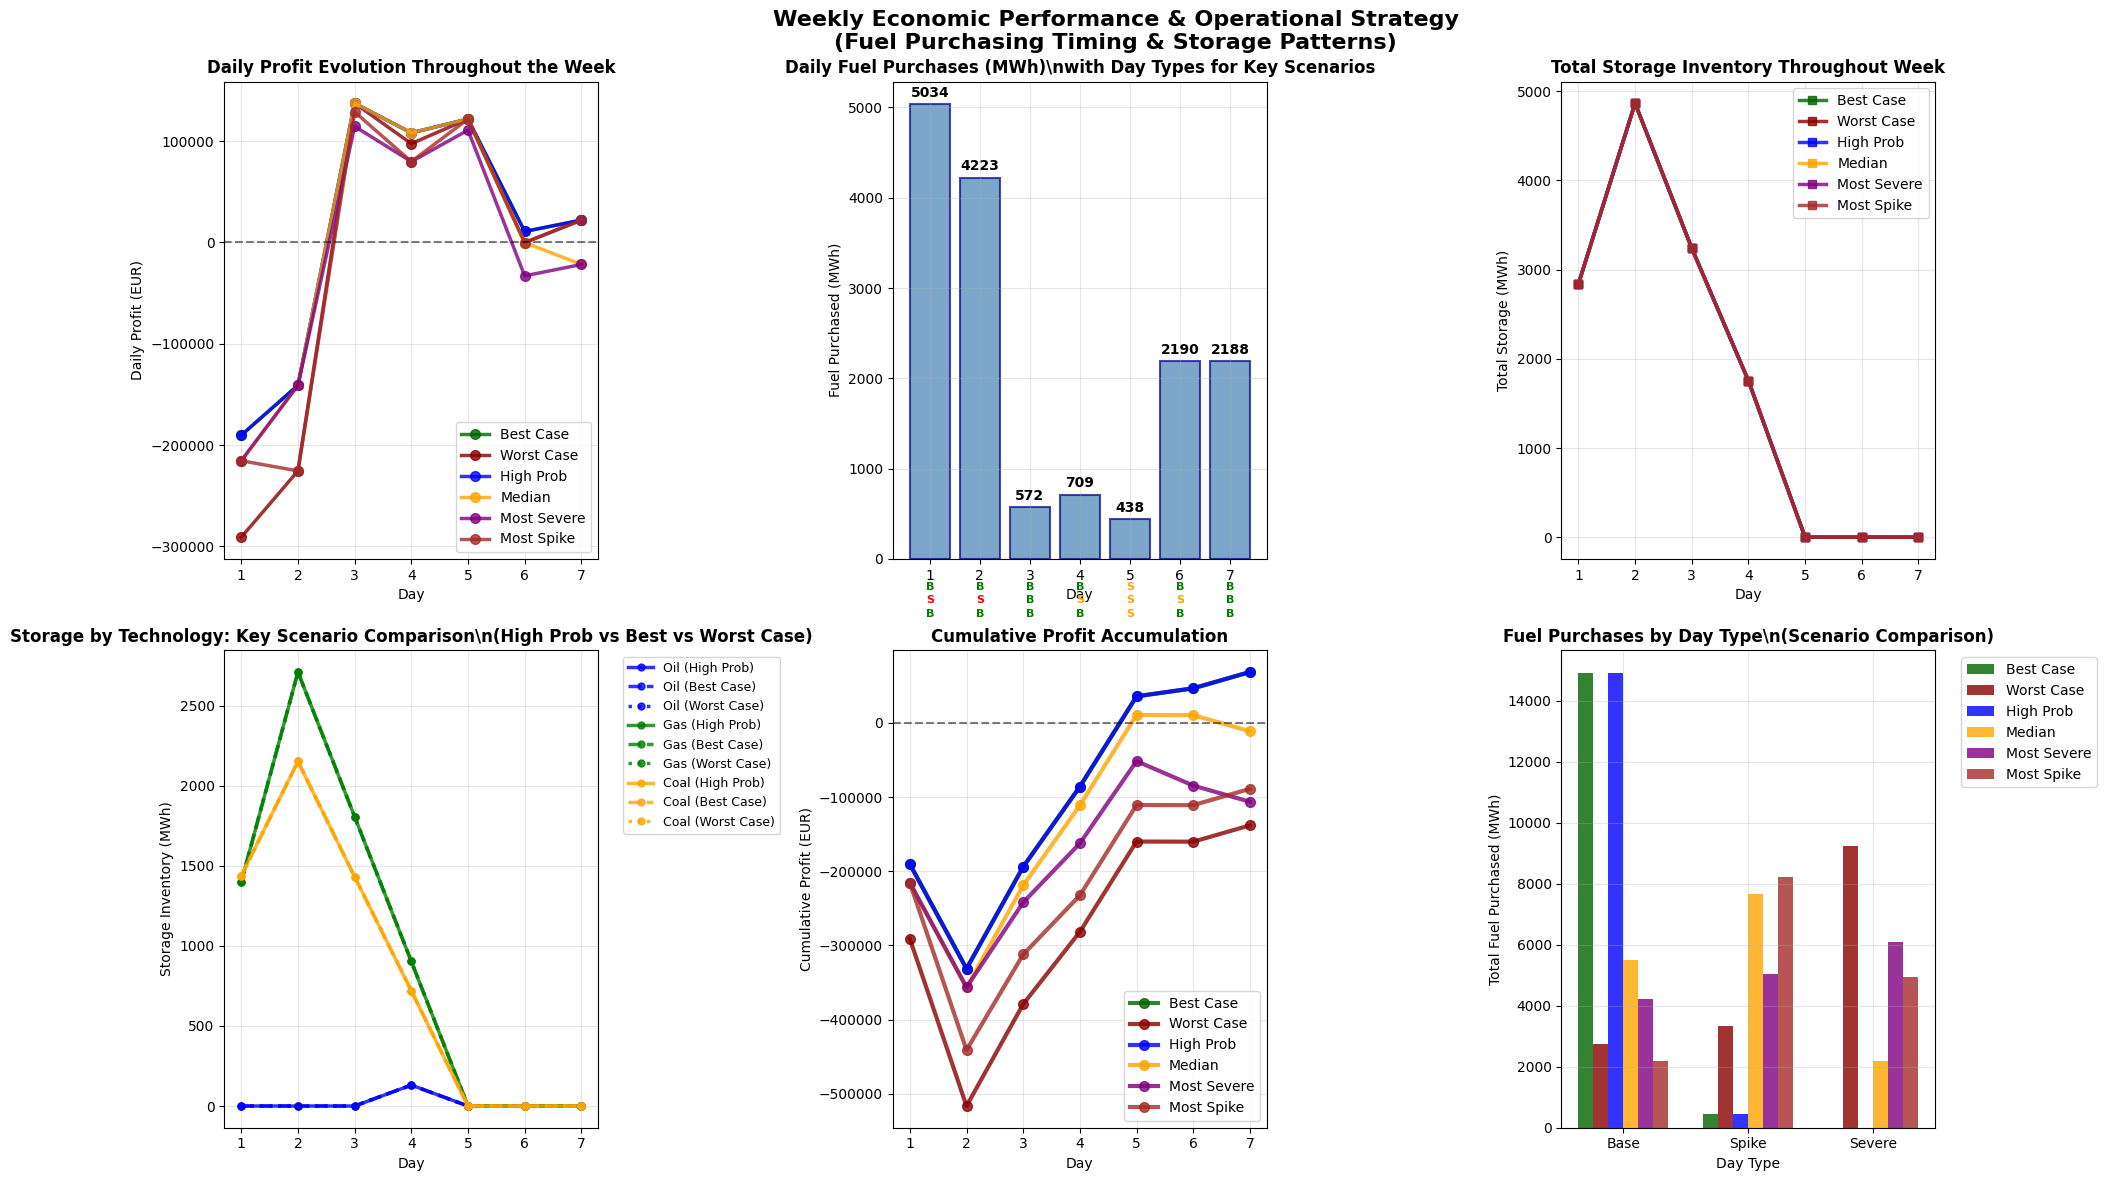

\n=== Fuel Purchase & Storage Strategy Analysis ===
\nFuel Purchase Timing (Same Across All Scenarios):
  Day 1: 5034.3 MWh total [Oil-Oil_Supplier_1: 573.3 MWh, Gas-Gas_Supplier_2: 2304.0 MWh, Coal-Coal_Supplier_2: 2157.0 MWh]
  Day 2: 4222.9 MWh total [Oil-Oil_Supplier_2: 572.2 MWh, Gas-Gas_Supplier_2: 2215.5 MWh, Coal-Coal_Supplier_2: 1435.3 MWh]
  Day 3: 571.7 MWh total [Oil-Oil_Supplier_3: 571.7 MWh]
  Day 4: 709.0 MWh total [Oil-Oil_Supplier_3: 701.3 MWh, Coal-Coal_Supplier_2: 7.7 MWh]
  Day 5: 438.0 MWh total [Oil-Oil_Supplier_3: 438.0 MWh]
  Day 6: 2189.9 MWh total [Oil-Oil_Supplier_3: 566.9 MWh, Gas-Gas_Supplier_2: 903.0 MWh, Coal-Coal_Supplier_2: 720.0 MWh]
  Day 7: 2188.3 MWh total [Oil-Oil_Supplier_3: 565.5 MWh, Gas-Gas_Supplier_2: 902.7 MWh, Coal-Coal_Supplier_2: 720.0 MWh]
  Total Weekly Purchase: 15354.1 MWh
\n=== Storage Utilization by Scenario ===
\nBest Case - Scenario Week_1:
  Peak Storage: 4863.3 MWh on Day 2
  Average Storage: 1813.4 MWh
    Oil: Max=130.8 MWh, Av

In [80]:
# -------------------------------------------------------
# Additional Analysis: Weekly Economic Performance, Fuel Purchasing & Storage
# -------------------------------------------------------

if m.status == GRB.OPTIMAL:
    print("=== Weekly Economic Performance & Operational Analysis ===")
    
    # Create additional comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Weekly Economic Performance & Operational Strategy\n(Fuel Purchasing Timing & Storage Patterns)', 
                 fontsize=16, fontweight='bold')
    
    # -------------------------------------------------------
    # 1. Daily Revenue vs Costs by Scenario (Top Left)
    # -------------------------------------------------------
    ax = axes[0, 0]
    
    for i, (label, w) in enumerate(focus_scenarios.items()):
        daily_revenues = []
        daily_fuel_costs = []
        daily_storage_costs = []
        daily_deviation_costs = []
        
        for d in DAYS:
            # Daily revenue
            daily_revenue = sum(
                elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w].X
                for t in TECHS for h in HOURS
            )
            daily_revenues.append(daily_revenue)
            
            # Daily fuel cost (day-type specific)
            daily_fuel_cost = 0
            day_type = scenario_day_types[w][d]
            for t in TECHS:
                for s in SUPPLIERS[t]:
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    daily_fuel_cost += price_td * purchase[t, s, d].X
            daily_fuel_costs.append(daily_fuel_cost)
            
            # Daily storage cost
            daily_storage_cost = sum(
                storage_rent[t] * inventory[t, d, w].X for t in TECHS
            )
            daily_storage_costs.append(daily_storage_cost)
            
            # Daily deviation cost
            daily_deviation_cost = (
                sum(load_deviation_penalty["under_generation"] * under_generation_w[d, h, w].X for h in HOURS) +
                sum(load_deviation_penalty["over_generation"] * over_generation_w[d, h, w].X for h in HOURS)
            )
            daily_deviation_costs.append(daily_deviation_cost)
        
        # Calculate daily profits
        daily_profits = [rev - fuel - storage - dev for rev, fuel, storage, dev in 
                        zip(daily_revenues, daily_fuel_costs, daily_storage_costs, daily_deviation_costs)]
        
        ax.plot(range(1, num_days+1), daily_profits, 
               marker='o', linewidth=2.5, markersize=7, 
               label=label, color=scenario_colors[label], alpha=0.8)
    
    ax.set_title('Daily Profit Evolution Throughout the Week', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Daily Profit (EUR)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # -------------------------------------------------------
    # 2. Fuel Purchasing Pattern by Day (Top Center)
    # -------------------------------------------------------
    ax = axes[0, 1]
    
    # Calculate daily fuel purchases (same for all scenarios)
    daily_fuel_purchases = []
    daily_fuel_costs_by_type = {'Base': [], 'Spike': [], 'Severe': []}
    
    for d in DAYS:
        daily_purchase = 0
        for t in TECHS:
            for s in SUPPLIERS[t]:
                daily_purchase += purchase[t, s, d].X
        daily_fuel_purchases.append(daily_purchase)
    
    # Show fuel purchases as bars
    bars = ax.bar(range(1, num_days+1), daily_fuel_purchases, 
                  color='steelblue', alpha=0.7, edgecolor='navy', linewidth=1.5)
    
    # Add purchase amounts on bars
    for i, (bar, purchase_amt) in enumerate(zip(bars, daily_fuel_purchases)):
        if purchase_amt > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(daily_fuel_purchases)*0.01,
                    f'{purchase_amt:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Add day type annotations for different scenarios
    for i, (label, w) in enumerate(list(focus_scenarios.items())[:3]):  # Show only first 3 to avoid clutter
        day_types_sequence = scenario_day_types[w]
        for d, day_type in enumerate(day_types_sequence):
            color_map = {'Base': 'green', 'Spike': 'orange', 'Severe': 'red'}
            ax.text(d+1, -max(daily_fuel_purchases)*0.05 - i*max(daily_fuel_purchases)*0.03, 
                   day_type[0], ha='center', va='top', 
                   color=color_map[day_type], fontweight='bold', fontsize=8)
    
    ax.set_title('Daily Fuel Purchases (MWh)\\nwith Day Types for Key Scenarios', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Fuel Purchased (MWh)')
    ax.grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 3. Storage Utilization Patterns (Top Right)
    # -------------------------------------------------------
    ax = axes[0, 2]
    
    for i, (label, w) in enumerate(focus_scenarios.items()):
        # Calculate total storage across all technologies for each day
        daily_total_storage = []
        for d in DAYS:
            total_storage = sum(inventory[t, d, w].X for t in TECHS)
            daily_total_storage.append(total_storage)
        
        ax.plot(range(1, num_days+1), daily_total_storage, 
               marker='s', linewidth=2.5, markersize=6, 
               label=label, color=scenario_colors[label], alpha=0.8)
    
    ax.set_title('Total Storage Inventory Throughout Week', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Total Storage (MWh)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 4. Technology-Specific Storage Patterns (Bottom Left)
    # -------------------------------------------------------
    ax = axes[1, 0]
    
    # Compare storage across High Prob, Best, and Worst scenarios
    key_scenarios_for_storage = {
        'High Prob': high_prob_scenario,
        'Best Case': best_scenario,
        'Worst Case': worst_scenario
    }
    
    # Create subplot for each technology
    tech_colors = ['blue', 'green', 'orange', 'red'][:len(TECHS)]
    line_styles = {'High Prob': '-', 'Best Case': '--', 'Worst Case': ':'}
    
    for tech_idx, t in enumerate(TECHS):
        for scenario_label, w in key_scenarios_for_storage.items():
            daily_storage_tech = []
            for d in DAYS:
                daily_storage_tech.append(inventory[t, d, w].X)
            
            # Skip plotting if storage is negligible for this tech
            if max(daily_storage_tech) < 0.1:
                continue
                
            ax.plot(range(1, num_days+1), daily_storage_tech,
                   color=tech_colors[tech_idx], linestyle=line_styles[scenario_label],
                   marker='o', linewidth=2.5, markersize=5, 
                   label=f'{t} ({scenario_label})', alpha=0.8)
    
    ax.set_title('Storage by Technology: Key Scenario Comparison\\n(High Prob vs Best vs Worst Case)', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Storage Inventory (MWh)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # -------------------------------------------------------
    # 5. Weekly Financial Performance Summary (Bottom Center)
    # -------------------------------------------------------
    ax = axes[1, 1]
    
    # Calculate cumulative profits for each scenario
    for i, (label, w) in enumerate(focus_scenarios.items()):
        daily_profits = []
        cumulative_profits = []
        cumulative = 0
        
        for d in DAYS:
            # Calculate daily profit
            daily_revenue = sum(
                elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w].X
                for t in TECHS for h in HOURS
            )
            
            daily_fuel_cost = 0
            day_type = scenario_day_types[w][d]
            for t in TECHS:
                for s in SUPPLIERS[t]:
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    daily_fuel_cost += price_td * purchase[t, s, d].X
            
            daily_storage_cost = sum(storage_rent[t] * inventory[t, d, w].X for t in TECHS)
            
            daily_deviation_cost = (
                sum(load_deviation_penalty["under_generation"] * under_generation_w[d, h, w].X for h in HOURS) +
                sum(load_deviation_penalty["over_generation"] * over_generation_w[d, h, w].X for h in HOURS)
            )
            
            daily_profit = daily_revenue - daily_fuel_cost - daily_storage_cost - daily_deviation_cost
            daily_profits.append(daily_profit)
            cumulative += daily_profit
            cumulative_profits.append(cumulative)
        
        ax.plot(range(1, num_days+1), cumulative_profits,
               marker='o', linewidth=3, markersize=7, 
               label=label, color=scenario_colors[label], alpha=0.8)
    
    ax.set_title('Cumulative Profit Accumulation', fontweight='bold')
    ax.set_xlabel('Day')
    ax.set_ylabel('Cumulative Profit (EUR)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # -------------------------------------------------------
    # 6. Fuel Purchase vs Day Types Analysis (Bottom Right)
    # -------------------------------------------------------
    ax = axes[1, 2]
    
    # Analyze fuel purchase costs by day type for each scenario
    scenario_purchase_by_day_type = {}
    
    for label, w in focus_scenarios.items():
        scenario_purchase_by_day_type[label] = {'Base': 0, 'Spike': 0, 'Severe': 0}
        
        for d in DAYS:
            day_type = scenario_day_types[w][d]
            daily_purchase = sum(purchase[t, s, d].X for t in TECHS for s in SUPPLIERS[t])
            scenario_purchase_by_day_type[label][day_type] += daily_purchase
    
    # Create grouped bar chart
    day_types = ['Base', 'Spike', 'Severe']
    x_pos = np.arange(len(day_types))
    width = 0.12
    
    for i, (label, w) in enumerate(focus_scenarios.items()):
        purchases_by_type = [scenario_purchase_by_day_type[label][dt] for dt in day_types]
        offset = (i - 2.5) * width
        ax.bar(x_pos + offset, purchases_by_type, width, 
               label=label, color=scenario_colors[label], alpha=0.8)
    
    ax.set_title('Fuel Purchases by Day Type\\n(Scenario Comparison)', fontweight='bold')
    ax.set_xlabel('Day Type')
    ax.set_ylabel('Total Fuel Purchased (MWh)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(day_types)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------------------
    # Detailed Operational Summary
    # -------------------------------------------------------
    print(f"\\n=== Fuel Purchase & Storage Strategy Analysis ===")
    
    # Fuel purchasing summary
    print(f"\\nFuel Purchase Timing (Same Across All Scenarios):")
    total_weekly_purchase = 0
    for d in DAYS:
        daily_total = 0
        purchase_details = []
        for t in TECHS:
            for s in SUPPLIERS[t]:
                purchase_val = purchase[t, s, d].X
                if purchase_val > 0.01:
                    purchase_details.append(f"{t}-{s}: {purchase_val:.1f} MWh")
                daily_total += purchase_val
        
        if daily_total > 0.01:
            print(f"  Day {d+1}: {daily_total:.1f} MWh total [{', '.join(purchase_details)}]")
        total_weekly_purchase += daily_total
    
    print(f"  Total Weekly Purchase: {total_weekly_purchase:.1f} MWh")
    
    # Storage analysis by scenario
    print(f"\\n=== Storage Utilization by Scenario ===")
    for label, w in focus_scenarios.items():
        print(f"\\n{label} - Scenario {w}:")
        
        # Peak storage day
        daily_storage_totals = []
        for d in DAYS:
            daily_total = sum(inventory[t, d, w].X for t in TECHS)
            daily_storage_totals.append(daily_total)
        
        max_storage = max(daily_storage_totals)
        max_storage_day = daily_storage_totals.index(max_storage) + 1
        
        print(f"  Peak Storage: {max_storage:.1f} MWh on Day {max_storage_day}")
        print(f"  Average Storage: {np.mean(daily_storage_totals):.1f} MWh")
        
        # Storage by technology
        for t in TECHS:
            tech_storage = [inventory[t, d, w].X for d in DAYS]
            max_tech_storage = max(tech_storage)
            avg_tech_storage = np.mean(tech_storage)
            if max_tech_storage > 0.01:
                print(f"    {t}: Max={max_tech_storage:.1f} MWh, Avg={avg_tech_storage:.1f} MWh")
    
    # Economic performance summary
    print(f"\\n=== Daily Economic Performance Summary ===")
    for label, w in focus_scenarios.items():
        print(f"\\n{label} - Scenario {w}:")
        
        best_day_profit = -float('inf')
        worst_day_profit = float('inf')
        best_day = 0
        worst_day = 0
        
        for d in DAYS:
            # Calculate daily profit
            daily_revenue = sum(
                elec_price_hourly[d][h] * revenue_factor[t] * generate[t, d, h, w].X
                for t in TECHS for h in HOURS
            )
            
            daily_fuel_cost = 0
            day_type = scenario_day_types[w][d]
            for t in TECHS:
                for s in SUPPLIERS[t]:
                    price_td = fuel_bids[t][s]["price_EUR_per_MWh"][day_type][d]
                    daily_fuel_cost += price_td * purchase[t, s, d].X
            
            daily_storage_cost = sum(storage_rent[t] * inventory[t, d, w].X for t in TECHS)
            daily_deviation_cost = (
                sum(load_deviation_penalty["under_generation"] * under_generation_w[d, h, w].X for h in HOURS) +
                sum(load_deviation_penalty["over_generation"] * over_generation_w[d, h, w].X for h in HOURS)
            )
            
            daily_profit = daily_revenue - daily_fuel_cost - daily_storage_cost - daily_deviation_cost
            
            if daily_profit > best_day_profit:
                best_day_profit = daily_profit
                best_day = d + 1
                
            if daily_profit < worst_day_profit:
                worst_day_profit = daily_profit
                worst_day = d + 1
        
        print(f"  Best Day: Day {best_day} with {best_day_profit:.2f} EUR profit ({scenario_day_types[w][best_day-1]} day)")
        print(f"  Worst Day: Day {worst_day} with {worst_day_profit:.2f} EUR profit ({scenario_day_types[w][worst_day-1]} day)")
    
else:
    print(f"Optimization failed with status: {m.status}")

In [81]:
#plot the results and the fuel purchase dor the following cases (best, worst, high prob, median, most severe, most spike)